# Configuración del Entorno

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import silhouette_score # Para K-Means
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Para Regresión
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report # Para Clasificación

import gc # Para la recolección de basura

pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', None)  # Display full content of columns


In [ ]:
#Instalación e importación de las librerías necesarias para leer nuestro dataset directamente desde Kaggle
!pip install opendatasets
import opendatasets as od

In [ ]:
dataset_link="https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps/data"
od.download(dataset_link)

In [ ]:
import os
os.chdir("google-playstore-apps")
os.listdir()

In [ ]:
import pandas as pd
#Ponemos nuestro dataset en un dataframe
df = pd.read_csv("Google-Playstore.csv")

In [66]:
sample_size = 250000  # Nos quedamos con poco más del 10% de los datos

# Muestreo estratificado por la variable 'Free'
df_sample = df.groupby('Free', group_keys=False).apply(
    lambda x: x.sample(int(sample_size * len(x) / len(df)), random_state=42)
).reset_index(drop=True)


<ipython-input-66-0ba1905ff0f8>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('Free', group_keys=False).apply(


In [67]:
import gc
del df  # Liberamos memoria eliminando el DataFrame original
gc.collect()  # Forzar la recolección de basura

227

## Funciones

In [68]:
import pandas as pd
import numpy as np
import re

def analizar_dataframe_efficient(df, scl=2.327):
    """
    Analiza un DataFrame y devuelve estadísticas clave para cada columna (Efficient Version).

    Parámetros:
        df (pd.DataFrame): DataFrame a analizar.
        scl (float): Umbral para detectar valores extremos (basado en desviación estándar).

    Retorna:
        pd.DataFrame con información clave de cada columna.
    """

    # Define helper functions internally for scope and clarity
    def moda(x):
        """ Calcula la moda de una serie, manejando nulos correctamente. """
        x = x.dropna()
        # Use try-except in case mode() returns an empty Series (all unique/NA after dropna)
        try:
            return x.mode().iloc[0]
        except IndexError:
            return "Todos NA" if x.empty else "No unique mode" # More specific return

    def es_posible_fecha(serie):
        """Detecta si una columna de tipo 'object' contiene fechas en formato de cadena."""
        if serie.dtype != 'object' or serie.empty:
             return "No"
        # Sample a subset for performance if the series is very large
        sample_size = min(1000, len(serie))
        sample_serie = serie.sample(sample_size, random_state=42) if len(serie) > 1000 else serie

        try:
            # Use infer_datetime_format=True for potential speed up
            serie_convertida = pd.to_datetime(sample_serie, errors='coerce', dayfirst=True, infer_datetime_format=True)
            porcentaje_convertido = serie_convertida.notna().sum() / len(sample_serie) * 100
            return "Sí" if porcentaje_convertido > 90 else "No"
        except Exception: # Catch broader exceptions just in case
            return "No"

    def es_posible_numero(serie):
        """Detecta si una columna de tipo 'object' contiene valores numéricos en formato de texto."""
        if serie.dtype != 'object' or serie.empty:
             return "No"

        # Sample a subset for performance if the series is very large
        sample_size = min(1000, len(serie))
        sample_serie = serie.sample(sample_size, random_state=42) if len(serie) > 1000 else serie

        # Ensure sample is string type before replace
        sample_serie_str = sample_serie.astype(str)

        # Eliminar caracteres comunes en números (símbolos de moneda, %, espacios)
        # Use .str.replace directly on the string series
        serie_sin_simbolos = sample_serie_str.str.replace(r'[^0-9.,-]', '', regex=True)

        # Attempt to convert to numeric
        serie_convertida = pd.to_numeric(serie_sin_simbolos, errors='coerce')

        porcentaje_convertido = serie_convertida.notna().sum() / len(sample_serie) * 100
        return "Sí" if porcentaje_convertido > 90 else "No"


    posibles_NA = ['999', '9999', "NA", "N/A", "NULL", "None", ""]

    columnas_info = [
        'Tipo', 'cant_NA', '% NA', 'pos_NA', 'Uniq', '% Uniq', 'Moda', 'Pcat',
        'Bias', 'Extremos', 'Min', 'Max', 'Rango', 'Media', 'Mediana', 'Desv.Std',
        'CV', 'P5', 'P25', 'P75', 'P95', 'ID_posible', 'Long_texto_prom', 'Top_5_Valores', 'Posible_Fecha', 'Posible_Numero'
    ]

    mat = pd.DataFrame(index=df.columns, columns=columnas_info)

    # --- Efficient Calculation of Basic and Numeric Describe Stats ---

    # Get basic info for all columns efficiently
    mat['Tipo'] = df.dtypes.astype(str)
    mat['cant_NA'] = df.isnull().sum()
    mat['% NA'] = round(mat['cant_NA'] / len(df) * 100, 2)
    mat['Uniq'] = df.nunique()
    mat['% Uniq'] = round(mat['Uniq'] / len(df) * 100, 2)

    # Use describe for core numeric stats
    try:
        desc_numeric = df.describe().transpose()
        # Map describe columns to our output columns
        describe_map = {
            'mean': 'Media',
            '50%': 'Mediana', # 50% is the median
            'std': 'Desv.Std',
            'min': 'Min',
            'max': 'Max',
            '5%': 'P5',
            '25%': 'P25',
            '75%': 'P75',
            '95%': 'P95'
        }
        for desc_col, mat_col in describe_map.items():
             if desc_col in desc_numeric.columns:
                # Assign directly, handle rounding later if needed, or just use describe's output
                # describe output is already float/int, so no need for round() checks here
                mat[mat_col] = desc_numeric[desc_col].round(2)

    except Exception:
        # Handle case where describe fails (e.g., no numeric columns)
        pass # The columns will remain NaN, which is fine before fillna


    # --- Iterate to Fill In Remaining Column-Specific Stats ---

    for col in df.columns:
        serie = df[col]
        tipo_dato = mat.at[col, 'Tipo'] # Use the dtype already populated

        # Calculate pos_NA (requires iterating/applying isin)
        mat.at[col, 'pos_NA'] = serie.astype(str).isin(posibles_NA).sum()

        # Calculate Moda (column-specific)
        mat.at[col, 'Moda'] = moda(serie)

        # Calculate Pcat (based on % Uniq already populated)
        mat.at[col, 'Pcat'] = "Pos. Cat." if (mat.at[col, '% Uniq'] < 10) else "Pos. No Cat."

        # Calculate Bias, Extremos, Rango, CV for numeric columns (using already calculated stats)
        if pd.api.types.is_numeric_dtype(serie) and not serie.dropna().empty:
            # Retrieve already calculated basic stats
            media = mat.at[col, 'Media']
            mediana = mat.at[col, 'Mediana']
            std_dev = mat.at[col, 'Desv.Std']
            min_val = mat.at[col, 'Min']
            max_val = mat.at[col, 'Max']


            # Calculate Bias (requires valid media and mediana)
            if pd.notna(media) and pd.notna(mediana):
                 mat.at[col, 'Bias'] = (
                    'right bias' if media > mediana else
                    ('left bias' if media < mediana else 'simétrica')
                )
            else:
                 mat.at[col, 'Bias'] = "N/A"


            # Calculate Extremos (requires valid media and std_dev)
            if pd.notna(media) and pd.notna(std_dev) and std_dev > 0:
                 mat.at[col, 'Extremos'] = np.sum(((serie - media) / std_dev).abs() > scl)
            else:
                 mat.at[col, 'Extremos'] = 0 # Or 'N/A' if preferred


            # Calculate Rango (requires valid min and max)
            if pd.notna(min_val) and pd.notna(max_val):
                 mat.at[col, 'Rango'] = round(max_val - min_val, 2)
            else:
                 mat.at[col, 'Rango'] = "N/A"

            # CV is already calculated from describe, but let's recalculate if needed based on media/std_dev validity
            if pd.notna(media) and pd.notna(std_dev) and media != 0 :
                mat.at[col, 'CV'] = round(std_dev / media, 2)
            else:
                 mat.at[col, 'CV'] = "N/A" # describe might give NaN, ensure our logic overrides


        else: # Non-numeric columns or all NaNs
            mat.at[col, 'Bias'] = "N/A"
            mat.at[col, 'Extremos'] = "N/A"
            mat.at[col, 'Rango'] = "N/A"
            mat.at[col, 'CV'] = "N/A"
            # Other numeric fields (Min, Max, Media, etc.) were handled by describe or are N/A

        # Detect if the column is a possible unique ID (based on % Uniq already populated)
        mat.at[col, 'ID_posible'] = "Sí" if mat.at[col, 'Uniq'] > 0 and mat.at[col, '% Uniq'] > 95 else "No"
        # Added check Uniq > 0 to avoid ID for empty columns

        # Handle object columns
        if tipo_dato == "object":
            # Ensure not empty before string operations
            if not serie.empty:
                mat.at[col, 'Posible_Fecha'] = es_posible_fecha(serie)
                mat.at[col, 'Posible_Numero'] = es_posible_numero(serie)

                # Calculate Long_texto_prom (requires conversion to string)
                # Added try-except for safety with mixed types in object column
                try:
                   mat.at[col, 'Long_texto_prom'] = round(serie.astype(str).str.len().mean(), 2)
                except Exception:
                   mat.at[col, 'Long_texto_prom'] = "Error"

                # Calculate Top_5_Valores (requires value_counts)
                # Added try-except for safety with mixed types or problematic values
                try:
                    top_5_values = serie.value_counts().nlargest(5).index.tolist()
                    mat.at[col, 'Top_5_Valores'] = ", ".join(map(str, top_5_values))
                except Exception:
                     mat.at[col, 'Top_5_Valores'] = "Error"
            else:
                 mat.at[col, 'Posible_Fecha'] = "No"
                 mat.at[col, 'Posible_Numero'] = "No"
                 mat.at[col, 'Long_texto_prom'] = "N/A"
                 mat.at[col, 'Top_5_Valores'] = "N/A"

        else: # Non-object types don't need these checks/calcs
            mat.at[col, 'Posible_Fecha'] = "No"
            mat.at[col, 'Posible_Numero'] = "No"
            mat.at[col, 'Long_texto_prom'] = "N/A"
            mat.at[col, 'Top_5_Valores'] = "N/A"


    # --- Final Cleanup ---
    return mat.fillna('')

In [69]:
import pandas as pd
from scipy import stats
import numpy as np

def analizar_mecanismo_faltantes_mejorado(df, variable_a_analizar, alpha=0.05, verbose=True):
    """
    Analiza el posible mecanismo (MCAR o MAR) de los datos faltantes
    para una variable específica en un DataFrame, con respecto a otras variables observadas.

    Args:
        df (pd.DataFrame): El DataFrame de entrada.
        variable_a_analizar (str): El nombre de la columna con datos faltantes a analizar.
        alpha (float, optional): El umbral de significancia para las pruebas estadísticas.
                                 Defaults to 0.05.
        verbose (bool, optional): Si es True, imprime los resultados detallados y conclusiones.
                                  Defaults to True.

    Returns:
        dict: Un diccionario que contiene:
            - 'variable_analizada': Nombre de la variable con faltantes.
            - 'tiene_faltantes': Boolean, si la variable tiene datos faltantes.
            - 'resultados_pruebas': Lista de diccionarios, cada uno con los resultados
                                    de la prueba para una 'otra_variable'. Incluye:
                                    'otra_variable', 'test_type', 'statistic',
                                    'p_value', 'effect_size_type', 'effect_size'.
            - 'conclusion_general': String con la conclusión sobre el mecanismo.
            - 'variables_mar_asociadas': Lista de variables que sugieren MAR.
            - 'variables_mcar_consistentes': Lista de variables consistentes con MCAR.
            - 'nota_multiple_comparaciones': Advertencia sobre múltiples pruebas.

    Notes:
        - MCAR (Missing Completely at Random): La probabilidad de que falte un dato
          no está relacionada ni con los valores observados ni con los no observados.
          Esta función prueba si la ausencia está relacionada con *otras variables observadas*.
        - MAR (Missing at Random): La probabilidad de que falte un dato está relacionada
          con otras variables *observadas* en el dataset, pero no con los valores
          no observados de la propia variable faltante.
        - MNAR (Missing Not at Random): La probabilidad de que falte un dato está
          relacionada con los valores no observados de la propia variable faltante.
          Esta función *no puede detectar MNAR*.
        - Un p-valor <= alpha para una 'otra_variable' sugiere que la ausencia en
          'variable_a_analizar' está relacionada con 'otra_variable', indicando MAR.
        - Un p-valor > alpha sugiere que no hay evidencia de relación con esa
          'otra_variable', lo que es consistente con MCAR respecto a esa variable.
        - Efecto de Múltiples Comparaciones: Realizar múltiples pruebas estadísticas
          incrementa la probabilidad de obtener falsos positivos (errores Tipo I).
          Considere ajustar los p-valores o el nivel alfa si realiza muchas pruebas
          (e.g., usando la corrección de Bonferroni).
    """
    if variable_a_analizar not in df.columns:
        raise ValueError(f"La columna '{variable_a_analizar}' no se encuentra en el DataFrame.")

    df_copy = df.copy() # Trabajar sobre una copia para no modificar el original externamente
    indicador_faltantes = f'Faltante_{variable_a_analizar.replace(" ", "_")}'
    df_copy[indicador_faltantes] = df_copy[variable_a_analizar].isnull().astype(int)

    resultados_completos = {
        'variable_analizada': variable_a_analizar,
        'tiene_faltantes': False,
        'resultados_pruebas': [],
        'conclusion_general': f"La variable '{variable_a_analizar}' no tiene datos faltantes.",
        'variables_mar_asociadas': [],
        'variables_mcar_consistentes': [],
        'nota_multiple_comparaciones': (
            "Advertencia: Se realizaron múltiples pruebas estadísticas. "
            "Esto aumenta la probabilidad de falsos positivos (errores Tipo I). "
            "Considere métodos de corrección (e.g., Bonferroni) si es necesario."
        )
    }

    if df_copy[indicador_faltantes].sum() == 0:
        if verbose:
            print(f"\nLa variable '{variable_a_analizar}' no tiene datos faltantes.")
        if indicador_faltantes in df_copy.columns: # Debería estar, pero por si acaso
             df_copy.drop(columns=[indicador_faltantes], inplace=True)
        return resultados_completos

    resultados_completos['tiene_faltantes'] = True
    if verbose:
        print(f"\nAnalizando si '{variable_a_analizar}' tiene mecanismo MCAR/MAR (alpha = {alpha}):")

    otras_variables = df_copy.columns.drop([variable_a_analizar, indicador_faltantes]).tolist()

    if not otras_variables:
        resultados_completos['conclusion_general'] = (
            f"No hay otras variables en el DataFrame para comparar con '{variable_a_analizar}'. "
            "No se puede determinar el mecanismo."
        )
        if verbose:
            print(resultados_completos['conclusion_general'])
        if indicador_faltantes in df_copy.columns:
             df_copy.drop(columns=[indicador_faltantes], inplace=True)
        return resultados_completos

    for otra_var in otras_variables:
        if otra_var == indicador_faltantes: # Doble chequeo, aunque drop debería manejarlo
            continue

        resultado_test = {'otra_variable': otra_var, 'test_type': 'N/A', 'statistic': 'N/A',
                          'p_value': 'N/A', 'effect_size_type': 'N/A', 'effect_size': 'N/A'}

        df_missing = df_copy[df_copy[indicador_faltantes] == 1]
        df_not_missing = df_copy[df_copy[indicador_faltantes] == 0]

        # Asegurarse que haya datos en ambos grupos y en la otra_var
        if df_missing[otra_var].dropna().empty or df_not_missing[otra_var].dropna().empty:
            resultado_test['p_value'] = 'Datos insuficientes en uno o ambos grupos'
            resultados_completos['resultados_pruebas'].append(resultado_test)
            continue

        try:
            if pd.api.types.is_numeric_dtype(df_copy[otra_var]):
                resultado_test['test_type'] = 't-test (Welch)'
                # Asegurar al menos 2 observaciones no NaN en cada grupo
                group1 = df_missing[otra_var].dropna()
                group2 = df_not_missing[otra_var].dropna()

                if len(group1) < 2 or len(group2) < 2:
                    resultado_test['p_value'] = 'Muy pocos datos (n<2) en un grupo para t-test'
                elif group1.nunique() < 2 and group2.nunique() < 2 and group1.iloc[0] == group2.iloc[0]: # Ambos grupos constantes y iguales
                    resultado_test['statistic'] = 0
                    resultado_test['p_value'] = 1.0 # No hay diferencia
                    resultado_test['effect_size_type'] = "Cohen's d"
                    resultado_test['effect_size'] = 0.0
                elif group1.var() == 0 and group2.var() == 0 and group1.mean() != group2.mean(): # Ambos grupos constantes pero diferentes
                    resultado_test['statistic'] = np.inf # Diferencia clara
                    resultado_test['p_value'] = 0.0 # Significativo
                    resultado_test['effect_size_type'] = "Cohen's d"
                    resultado_test['effect_size'] = np.inf # Efecto máximo
                else:
                    stat, p_value = stats.ttest_ind(group1, group2, equal_var=False, nan_policy='omit')
                    resultado_test['statistic'] = stat
                    resultado_test['p_value'] = p_value

                    # Calcular Cohen's d (para varianzas desiguales)
                    # d = (mean1 - mean2) / sqrt((std1^2 + std2^2) / 2)
                    # Usar ddof=1 para std para que coincida con la mayoría de las calculadoras de Cohen's d
                    if len(group1) > 1 and len(group2) > 1 :
                        mean1, mean2 = group1.mean(), group2.mean()
                        std1, std2 = group1.std(ddof=1), group2.std(ddof=1)
                        if std1 == 0 and std2 == 0: # Ambos grupos tienen varianza cero
                             cohen_d = 0 if mean1 == mean2 else np.inf # o alguna otra indicación
                        else:
                            pooled_std_approximation = np.sqrt((std1**2 + std2**2) / 2)
                            if pooled_std_approximation == 0: # Evita división por cero si ambas std son cero
                                cohen_d = 0 if mean1 == mean2 else np.inf
                            else:
                                cohen_d = (mean1 - mean2) / pooled_std_approximation
                        resultado_test['effect_size_type'] = "Cohen's d"
                        resultado_test['effect_size'] = cohen_d
                    else:
                        resultado_test['effect_size_type'] = "Cohen's d"
                        resultado_test['effect_size'] = 'No calculable (n<2 en un grupo)'


            elif pd.api.types.is_object_dtype(df_copy[otra_var]) or \
                 pd.api.types.is_categorical_dtype(df_copy[otra_var]) or \
                 pd.api.types.is_bool_dtype(df_copy[otra_var]):

                resultado_test['test_type'] = 'chi-squared'
                # Convertir booleanos a string para crosstab si es necesario, o manejar como 0/1
                temp_otra_var = df_copy[otra_var].astype(str) if pd.api.types.is_bool_dtype(df_copy[otra_var]) else df_copy[otra_var]

                contingency_table = pd.crosstab(df_copy[indicador_faltantes], temp_otra_var, dropna=True)

                # Eliminar columnas/filas con sumas cero para evitar errores en chi2_contingency
                contingency_table = contingency_table.loc[contingency_table.sum(axis=1) > 0, contingency_table.sum(axis=0) > 0]


                if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2 or contingency_table.sum().sum() == 0:
                     resultado_test['p_value'] = 'Tabla de contingencia degenerada (dims < 2x2 o vacía)'
                else:
                    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
                    resultado_test['statistic'] = chi2
                    resultado_test['p_value'] = p_value

                    # Calcular Cramer's V
                    n_obs = contingency_table.sum().sum()
                    phi2 = chi2 / n_obs
                    r, k = contingency_table.shape
                    if min(r - 1, k - 1) == 0: # Evitar división por cero si una dimensión es 1 después de filtrar
                        cramers_v = np.nan # o 0 si se considera que no hay asociación medible
                    else:
                        cramers_v = np.sqrt(phi2 / min(r - 1, k - 1))
                    resultado_test['effect_size_type'] = "Cramer's V"
                    resultado_test['effect_size'] = cramers_v
            else:
                resultado_test['test_type'] = 'Skipped'
                resultado_test['p_value'] = 'Tipo de dato no soportado para prueba automática'

        except Exception as e: # Captura más genérica para errores inesperados en tests
            resultado_test['p_value'] = f"Error en cálculo: {str(e)}"

        resultados_completos['resultados_pruebas'].append(resultado_test)

        # Clasificar variables
        if isinstance(resultado_test['p_value'], (float, np.float64)) and not np.isnan(resultado_test['p_value']):
            if resultado_test['p_value'] <= alpha:
                resultados_completos['variables_mar_asociadas'].append(otra_var)
            else:
                resultados_completos['variables_mcar_consistentes'].append(otra_var)

    # Generar conclusión
    if resultados_completos['variables_mar_asociadas']:
        vars_str = ", ".join(resultados_completos['variables_mar_asociadas'])
        resultados_completos['conclusion_general'] = (
            f"Los datos faltantes en '{variable_a_analizar}' tienen indicios de ser MAR (Missing at Random), "
            f"ya que su ausencia parece estar relacionada con la(s) variable(s) observada(s): {vars_str}."
        )
    elif resultados_completos['variables_mcar_consistentes']: # Solo si no hay MAR y sí hay MCAR consistentes
        resultados_completos['conclusion_general'] = (
            f"Los datos faltantes en '{variable_a_analizar}' tienen indicios de ser MCAR (Missing Completely at Random) "
            f"con respecto a las variables observadas analizadas, ya que no se encontró relación significativa."
        )
    else: # Ni MAR ni MCAR consistentes (e.g., todas las pruebas fallaron o no hubo otras variables)
        if not otras_variables: # Ya manejado arriba, pero por si acaso
             pass # Conclusión ya está puesta
        elif all(isinstance(res['p_value'], str) for res in resultados_completos['resultados_pruebas']):
            resultados_completos['conclusion_general'] = (
                f"No se pudo determinar el mecanismo de los datos faltantes para '{variable_a_analizar}' "
                "de manera concluyente, debido a errores o datos insuficientes en todas las pruebas realizadas."
            )
        else: # Caso mixto donde algunas pruebas no dieron p-valor numérico, pero ninguna fue < alpha
             resultados_completos['conclusion_general'] = (
                f"La evidencia no es concluyente para determinar el mecanismo de los datos faltantes en '{variable_a_analizar}'. "
                "Algunas pruebas no se pudieron realizar o no mostraron relación significativa."
            )


    if verbose:
        print("\nResultados detallados de las pruebas estadísticas:")
        print(f"(Significancia (alpha) = {alpha})")
        print("(Un p-valor alto (> alpha) sugiere que no hay diferencia significativa, consistente con MCAR respecto a esa variable)")
        print("(Un p-valor bajo (<= alpha) sugiere una diferencia significativa, consistente con MAR respecto a esa variable)")
        print(resultados_completos['nota_multiple_comparaciones'])

        for res in resultados_completos['resultados_pruebas']:
            p_val_str = f"{res['p_value']:.4f}" if isinstance(res['p_value'], (float, np.float64)) and not np.isnan(res['p_value']) else res['p_value']
            ef_size_str = f"{res['effect_size']:.4f}" if isinstance(res['effect_size'], (float, np.float64)) and not np.isnan(res['effect_size']) else res['effect_size']

            print(f"- Comparando con '{res['otra_variable']}':")
            print(f"  Test: {res['test_type']}, Estadístico: {res['statistic']}, p-valor: {p_val_str}")
            if res['effect_size_type'] != 'N/A':
                 print(f"  Tipo de Tamaño del Efecto: {res['effect_size_type']}, Tamaño del Efecto: {ef_size_str}")

        print(f"\nResumen para '{variable_a_analizar}':")
        print(f"Variables para las cuales la ausencia en '{variable_a_analizar}' parece MAR (p <= {alpha}):")
        if resultados_completos['variables_mar_asociadas']:
            print(resultados_completos['variables_mar_asociadas'])
        else:
            print("Ninguna.")

        print(f"\nVariables para las cuales la ausencia en '{variable_a_analizar}' parece consistente con MCAR (p > {alpha}):")
        if resultados_completos['variables_mcar_consistentes']:
            print(resultados_completos['variables_mcar_consistentes'])
        else:
            print("Ninguna (o no se pudieron realizar pruebas válidas).")

        print(f"\n{resultados_completos['conclusion_general']}")

    # Limpiar la columna indicadora temporal de la copia
    if indicador_faltantes in df_copy.columns:
        df_copy.drop(columns=[indicador_faltantes], inplace=True)

    return resultados_completos

In [70]:
import pandas as pd
import numpy as np

def visualizar_resultados_con_color(resultados_completos, alpha_usado_en_analisis):
    """
    Muestra los resultados del análisis de datos faltantes en una tabla con
    colores para indicar la significancia de los valores p.

    Args:
        resultados_completos (dict): El diccionario devuelto por
                                     analizar_mecanismo_faltantes_mejorado.
        alpha_usado_en_analisis (float): El valor alfa que se utilizó al generar
                                         los resultados_completos.
    """
    variable_analizada = resultados_completos.get('variable_analizada', 'Desconocida')
    print(f"--- Tabla de Resultados para: {variable_analizada} ---")

    if not resultados_completos['tiene_faltantes']:
        print(f"La variable '{variable_analizada}' no tiene datos faltantes. No hay tabla de pruebas que mostrar.")
        return

    lista_de_pruebas = resultados_completos.get('resultados_pruebas', [])

    if not lista_de_pruebas:
        print("No se realizaron pruebas (quizás no había otras variables para comparar).")
        return

    df_resultados = pd.DataFrame(lista_de_pruebas)

    # Seleccionar y reordenar columnas para una mejor visualización
    columnas_a_mostrar = ['otra_variable', 'test_type', 'statistic', 'p_value', 'effect_size_type', 'effect_size']
    # Filtrar para mantener solo las columnas que existen en el DataFrame
    columnas_existentes = [col for col in columnas_a_mostrar if col in df_resultados.columns]
    df_visual = df_resultados[columnas_existentes]


    def colorear_significancia(valor_p, alpha):
        estilo = 'background-color: white; color: black;' # Estilo por defecto para texto
        if isinstance(valor_p, (float, np.floating)) and not np.isnan(valor_p):
            if valor_p <= alpha:
                estilo = 'background-color: lightcoral; color: black;'  # Sugiere MAR
            else:
                estilo = 'background-color: lightgreen; color: black;' # Consistente con MCAR
        elif isinstance(valor_p, str): # Para mensajes como "Datos insuficientes"
            estilo = 'background-color: lightyellow; color: dimgray;'
        return estilo

    # Aplicar formato y estilo
    # Nota: display() es ideal para notebooks Jupyter. Si no estás en Jupyter,
    # la tabla HTML se imprimirá, o podrías guardarla en un archivo.
    styled_df = df_visual.style.map(
        lambda x: colorear_significancia(x, alpha_usado_en_analisis),
        subset=['p_value']
    ).format({
        'statistic': lambda x: f"{x:.3f}" if isinstance(x, (float, np.floating)) and not np.isnan(x) else str(x),
        'p_value': lambda x: f"{x:.4f}" if isinstance(x, (float, np.floating)) and not np.isnan(x) else str(x),
        'effect_size': lambda x: f"{x:.3f}" if isinstance(x, (float, np.floating)) and not np.isnan(x) else str(x)
    }).set_caption(f"Análisis de significancia para '{variable_analizada}' (alpha = {alpha_usado_en_analisis})")

    # Para que se muestre en entornos que no son notebooks (como este), necesitamos "renderizarlo"
    # o simplemente devolver el objeto con estilo. En un notebook, `display(styled_df)` sería lo usual.
    # Aquí, el entorno a menudo maneja la visualización de DataFrames estilizados directamente.
    return styled_df

In [71]:
df_resumen =  analizar_dataframe_efficient(df_sample, scl=2.327)


<ipython-input-68-405567d4000a>:37: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  serie_convertida = pd.to_datetime(sample_serie, errors='coerce', dayfirst=True, infer_datetime_format=True)
<ipython-input-68-405567d4000a>:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  serie_convertida = pd.to_datetime(sample_serie, errors='coerce', dayfirst=True, infer_datetime_format=True)
<ipython-input-68-405567d4000a>:37: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html.

# Exploración Inicial de Datos y Limpieza Básica

---



## Variables Numéricas

### Variable Price

In [ ]:
df_resumen.T['Price']

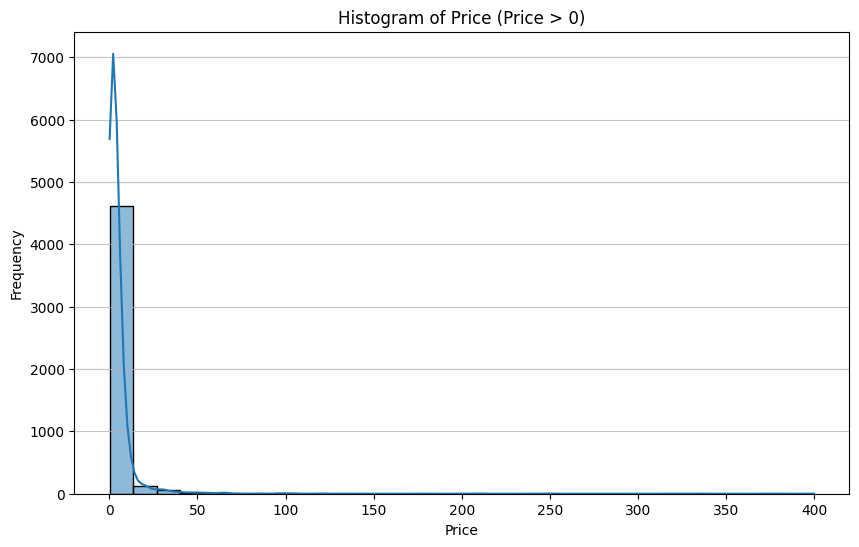

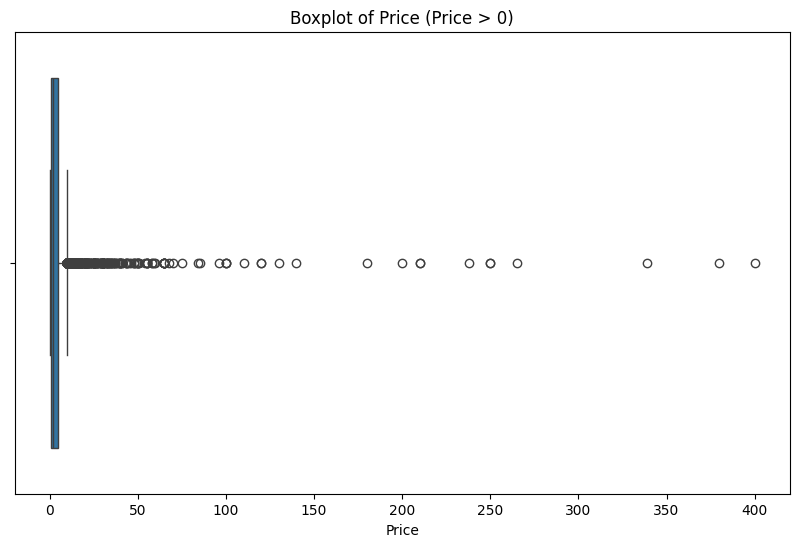

In [78]:
# Filter out prices that are 0 or less
df_price_positive = df_sample[df_sample['Price'] > 0]

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_price_positive['Price'], kde=True, bins=30)

plt.title('Histogram of Price (Price > 0)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_price_positive['Price'])
plt.title('Boxplot of Price (Price > 0)')
plt.xlabel('Price')
plt.show()

del df_price_positive

### Variable Size

In [ ]:
import numpy as np

def clean_size(size_str):
    if pd.isna(size_str):
        return np.nan

    size_str = str(size_str).replace(',', '.')

    if 'M' in size_str:
        return float(size_str.replace('M', ''))
    elif 'k' in size_str:
        return float(size_str.replace('k', '')) / 1000
    elif 'G' in size_str:
        return float(size_str.replace('G', '')) * 1000
    elif size_str == 'Varies with device':
        return np.nan
    else:
        try:
            return float(size_str)
        except ValueError:
             return np.nan # Return NaN for any string that still can't be converted

df_sample['Size'] = df_sample['Size'].apply(clean_size)

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df_sample['Size'].dropna(), bins=30, edgecolor='black')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of App Size')
plt.grid(True)
plt.show()

In [ ]:
Size_resumen = analizar_dataframe_efficient(pd.DataFrame( df_sample['Size']))
Size_resumen.T

In [79]:
visualizar_resultados_con_color(analizar_mecanismo_faltantes_mejorado(df_sample,'Size'))


Analizando si 'Size' tiene mecanismo MCAR/MAR (alpha = 0.05):

Resultados detallados de las pruebas estadísticas:
(Significancia (alpha) = 0.05)
(Un p-valor alto (> alpha) sugiere que no hay diferencia significativa, consistente con MCAR respecto a esa variable)
(Un p-valor bajo (<= alpha) sugiere una diferencia significativa, consistente con MAR respecto a esa variable)
Advertencia: Se realizaron múltiples pruebas estadísticas. Esto aumenta la probabilidad de falsos positivos (errores Tipo I). Considere métodos de corrección (e.g., Bonferroni) si es necesario.
- Comparando con 'App Name':
  Test: chi-squared, Estadístico: 246994.62259583332, p-valor: 0.0869
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 0.9940
- Comparando con 'App Id':
  Test: chi-squared, Estadístico: 249998.99999999985, p-valor: 0.4991
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 1.0000
- Comparando con 'Category':
  Test: chi-squared, Estadístico: 1768.9625458643407, p-valor: 0.0000
  

{'variable_analizada': 'Size',
 'tiene_faltantes': True,
 'resultados_pruebas': [{'otra_variable': 'App Name',
   'test_type': 'chi-squared',
   'statistic': np.float64(246994.62259583332),
   'p_value': np.float64(0.08690621662254958),
   'effect_size_type': "Cramer's V",
   'effect_size': np.float64(0.9939750471085718)},
  {'otra_variable': 'App Id',
   'test_type': 'chi-squared',
   'statistic': np.float64(249998.99999999985),
   'p_value': np.float64(0.4990596819420835),
   'effect_size_type': "Cramer's V",
   'effect_size': np.float64(0.9999999999999997)},
  {'otra_variable': 'Category',
   'test_type': 'chi-squared',
   'statistic': np.float64(1768.9625458643407),
   'p_value': np.float64(0.0),
   'effect_size_type': "Cramer's V",
   'effect_size': np.float64(0.08411824110721354)},
  {'otra_variable': 'Rating',
   'test_type': 't-test (Welch)',
   'statistic': np.float64(33.018400061041525),
   'p_value': np.float64(9.85933556542153e-220),
   'effect_size_type': "Cohen's d",
   '

In [80]:
from sklearn.impute import KNNImputer

# Check the number of missing values in 'Size' before imputation
print(f"Missing values in 'Size' before imputation: {df_sample['Size'].isnull().sum()}")

# Initialize the KNNImputer
# n_neighbors is the number of neighbors to consider
# weights can be 'uniform' or 'distance'
# metric can be 'nan_euclidean' (default for numerical data with NaNs)
imputer = KNNImputer(n_neighbors=5) # You can adjust n_neighbors

# Apply the imputer to the 'Size' column
# Note: KNNImputer expects a 2D array, so we reshape the column
# The imputer will return a NumPy array, we convert it back to a Pandas Series
df_sample['Size'] = imputer.fit_transform(df_sample[['Size']])

# Check the number of missing values in 'Size' after imputation
print(f"Missing values in 'Size' after imputation: {df_sample['Size'].isnull().sum()}")

# Display the first few rows to see the imputed values
print("\nDataFrame head after imputing 'Size' with KNN:")
print(df_sample[['Size']].head())



Missing values in 'Size' before imputation: 7957
Missing values in 'Size' after imputation: 0

DataFrame head after imputing 'Size' with KNN:
   Size
0  23.0
1   6.4
2   8.6
3  12.0
4  52.0


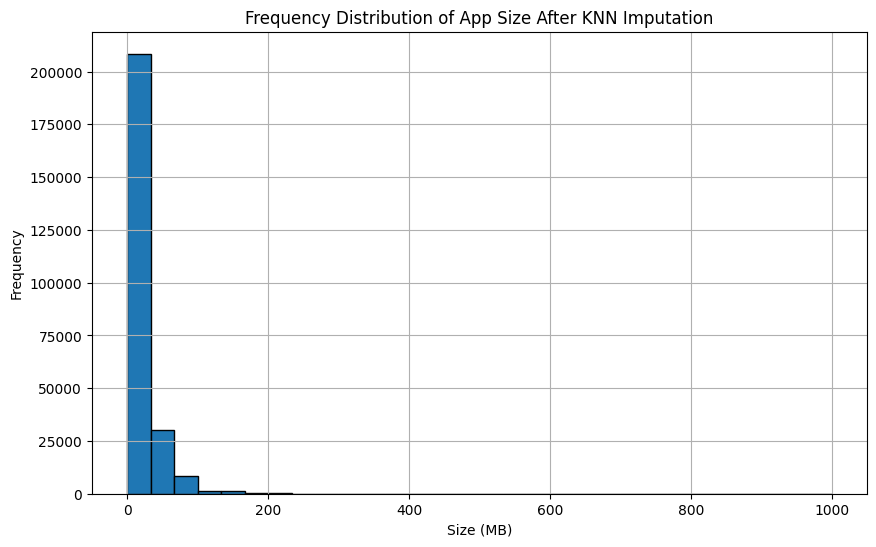

In [81]:
import matplotlib.pyplot as plt

plt.close('all')
# Plot the distribution again to see the effect of imputation
plt.figure(figsize=(10, 6))
plt.hist(df_sample['Size'], bins=30, edgecolor='black')
plt.xlabel('Size (MB)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of App Size After KNN Imputation')
plt.grid(True)
plt.show()


In [82]:
df_sample['Size_log'] = np.log(df_sample['Size'])

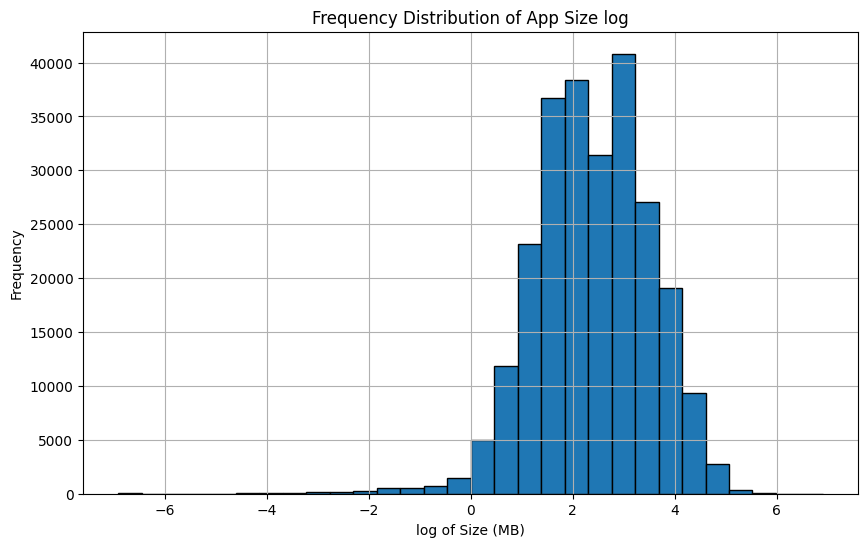

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df_sample['Size_log'], bins=30, edgecolor='black')
plt.xlabel('log of Size (MB)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of App Size log')
plt.grid(True)
plt.show()



Number of outliers in 'Size_log' detected by Z-score (> 3): 1738

Outliers detected by Z-score (first 10):
      Size  Size_log
34   0.279 -1.276543
44   0.029 -3.540459
53   0.103 -2.273026
66   0.084 -2.476938
85   0.121 -2.111965
88   0.052 -2.956512
104  0.153 -1.877317
127  0.010 -4.605170
144  0.017 -4.074542
149  0.074 -2.603690

Number of outliers in 'Size_log' detected by IQR (1.5 * IQR): 2246

Outliers detected by IQR (first 10):
      Size  Size_log
34   0.279 -1.276543
44   0.029 -3.540459
53   0.103 -2.273026
66   0.084 -2.476938
85   0.121 -2.111965
88   0.052 -2.956512
104  0.153 -1.877317
109  0.478 -0.738145
127  0.010 -4.605170
144  0.017 -4.074542


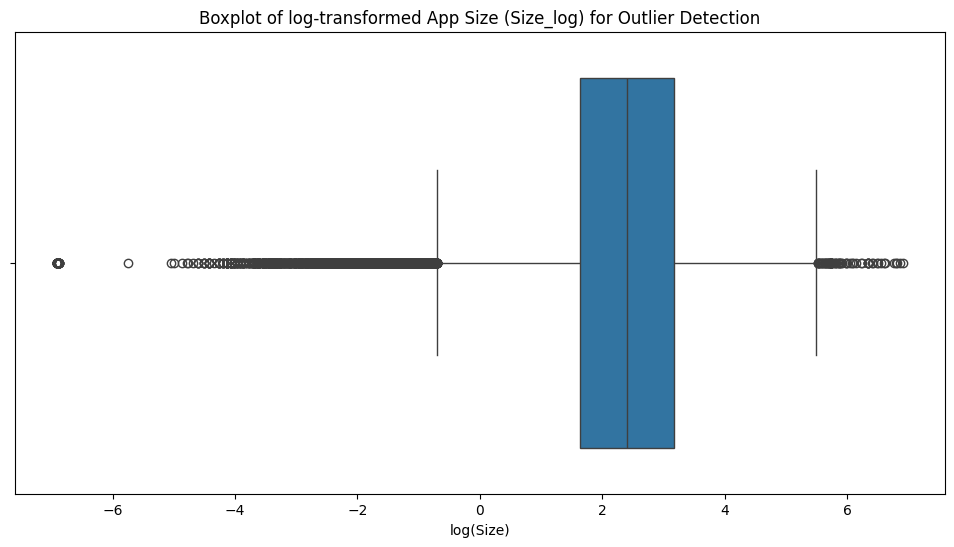

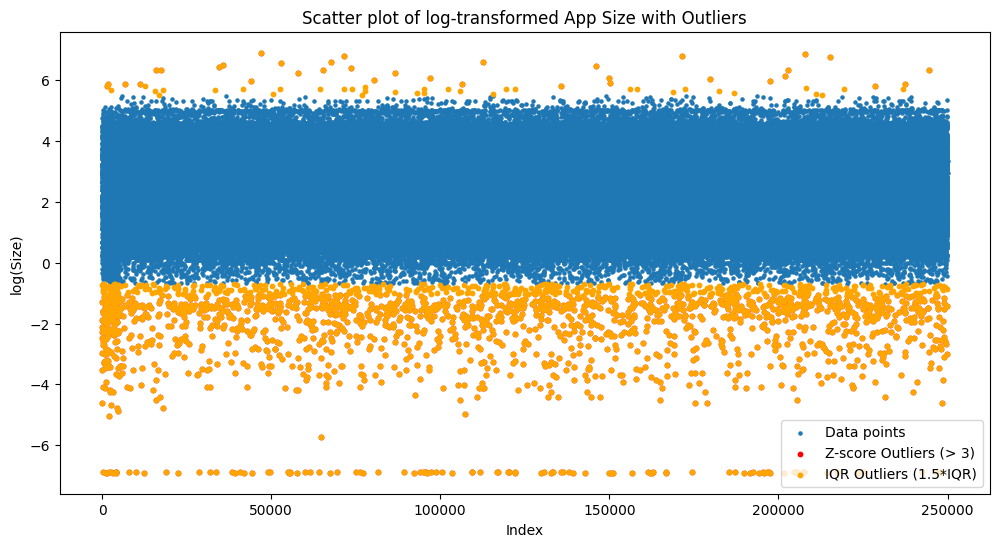

In [84]:
# Outlier analysis for Size_log using Z-score
z_scores = np.abs(stats.zscore(df_sample['Size_log']))
threshold = 3 # A common threshold for outlier detection

# Identify outliers based on Z-score
outliers_zscore_indices = np.where(z_scores > threshold)[0]
outliers_zscore = df_sample.iloc[outliers_zscore_indices]

print(f"\nNumber of outliers in 'Size_log' detected by Z-score (> {threshold}): {len(outliers_zscore)}")
print("\nOutliers detected by Z-score (first 10):")
print(outliers_zscore[['Size', 'Size_log']].head(10))

# Outlier analysis for Size_log using IQR
Q1 = df_sample['Size_log'].quantile(0.25)
Q3 = df_sample['Size_log'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers based on IQR
outliers_iqr = df_sample[(df_sample['Size_log'] < lower_bound) | (df_sample['Size_log'] > upper_bound)]

print(f"\nNumber of outliers in 'Size_log' detected by IQR (1.5 * IQR): {len(outliers_iqr)}")
print("\nOutliers detected by IQR (first 10):")
print(outliers_iqr[['Size', 'Size_log']].head(10))

# Visualize outliers using a boxplot on the log-transformed data
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_sample['Size_log'])
plt.title('Boxplot of log-transformed App Size (Size_log) for Outlier Detection')
plt.xlabel('log(Size)')
plt.show()

# Visualize distribution with outliers highlighted (optional, more complex)
# A scatter plot with original index vs log(Size) might show outliers visually

plt.figure(figsize=(12, 6))
plt.scatter(df_sample.index, df_sample['Size_log'], s=5, label='Data points')
plt.scatter(outliers_zscore_indices, outliers_zscore['Size_log'], color='red', s=10, label=f'Z-score Outliers (> {threshold})')
plt.scatter(outliers_iqr.index, outliers_iqr['Size_log'], color='orange', s=10, label='IQR Outliers (1.5*IQR)')
plt.title('Scatter plot of log-transformed App Size with Outliers')
plt.xlabel('Index')
plt.ylabel('log(Size)')
plt.legend()
plt.show()

# You can decide whether to remove, cap, or transform these outliers based on your analysis goals.
# For example, to remove outliers detected by IQR:
# df_sample_cleaned = df_sample[(df_sample['Size_log'] >= lower_bound) & (df_sample['Size_log'] <= upper_bound)].copy()
# print(f"\nShape after removing IQR outliers: {df_sample_cleaned.shape}")



Jarque-Bera Test Statistic: 93501.3724
P-value: 0.0000

Reject the null hypothesis: 'Size_log' does not appear to be normally distributed (based on Jarque-Bera test).


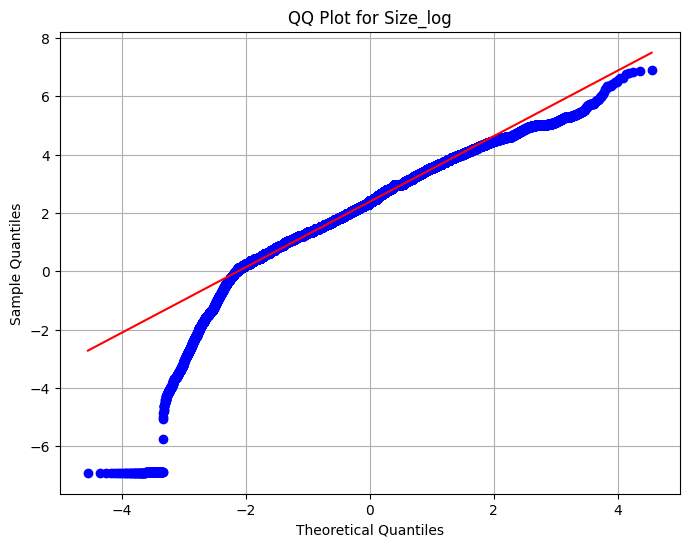

In [189]:
# Ho: 'Size_log' has a normal distribution (its skewness and kurtosis match a normal distribution).
# Ha: 'Size_log' does not have a normal distribution.
# We will use the Jarque-Bera test for normality.

# The Jarque-Bera test is suitable for larger samples and tests whether
# the sample data has skewness and kurtosis matching a normal distribution.
# Like other normality tests with large samples, it can be sensitive to
# small deviations from normality.
# We will also look at the QQ plot visually.

# Perform the Jarque-Bera test
# stats.jarque_bera returns the test statistic and the p-value
stat, p_value = stats.jarque_bera(df_sample['Size_log'])

print(f"Jarque-Bera Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}") # This p-value is for the chi-squared distribution with 2 degrees of freedom.

alpha = 0.05 # Significance level

if p_value <= alpha:
  print("\nReject the null hypothesis: 'Size_log' does not appear to be normally distributed (based on Jarque-Bera test).")
else:
  print("\nFail to reject the null hypothesis: 'Size_log' appears to be normally distributed (based on Jarque-Bera test).")

# Plot the QQ plot to visually assess normality
plt.figure(figsize=(8, 6))
stats.probplot(df_sample['Size_log'], dist="norm", plot=plt)
plt.title('QQ Plot for Size_log')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

# Interpretation of QQ plot:
# If the data points largely follow the straight line, it suggests normality.
# Deviations from the line indicate deviations from normality.
# Given the large sample size, small deviations might lead to a significant p-value
# in the Jarque-Bera test, while the QQ plot might still show a reasonable
# approximation of normality for practical purposes.
# The Jarque-Bera test specifically checks if skewness and kurtosis are close to 0 and 3 (or 0 for excess kurtosis), respectively.

### Variable Rating

In [ ]:
df_resumen.T['Rating']

In [87]:
resultados_Rating = visualizar_resultados_con_color(analizar_mecanismo_faltantes_mejorado(df_sample,'Rating',verbose=False), 0.05)
resultados_Rating

--- Tabla de Resultados para: Rating ---


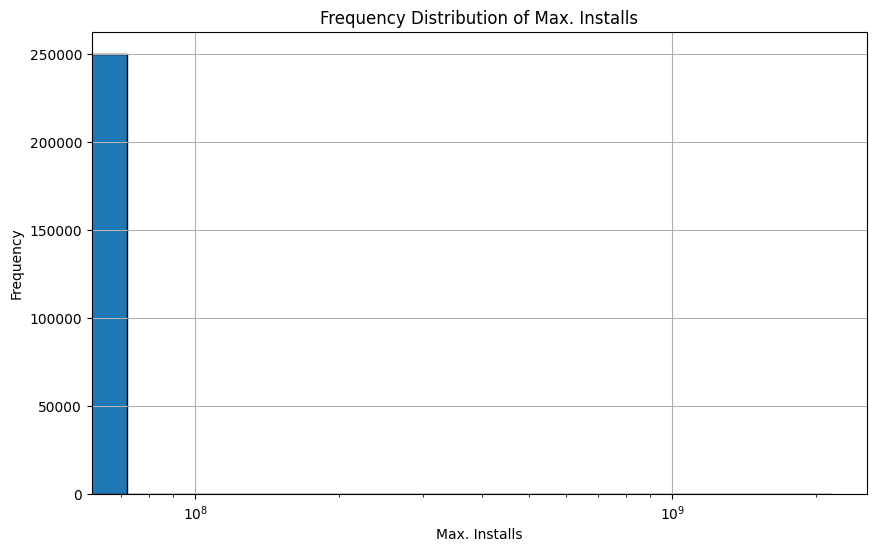

In [88]:
plt.close('all')  # Close all previous plots
gc.collect()  # Clear memory
# Frequency Distribution of Minimum Installs
plt.figure(figsize=(10, 6))
plt.hist(df_sample['Maximum Installs'], bins=30, edgecolor='black')
plt.xlabel('Max. Installs')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Max. Installs')
plt.grid(True)

plt.show()

In [89]:
df_sample['max_installs_log'] = np.log1p(df_sample['Maximum Installs'])

In [90]:
Max_installs_resumen = analizar_dataframe_efficient(df_sample, scl=2.327).T['Maximum Installs']
Max_installs_resumen

<ipython-input-68-405567d4000a>:37: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  serie_convertida = pd.to_datetime(sample_serie, errors='coerce', dayfirst=True, infer_datetime_format=True)
<ipython-input-68-405567d4000a>:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  serie_convertida = pd.to_datetime(sample_serie, errors='coerce', dayfirst=True, infer_datetime_format=True)
<ipython-input-68-405567d4000a>:37: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html.

Tipo                      int64
cant_NA                       0
% NA                        0.0
pos_NA                       13
Uniq                      55265
% Uniq                    22.11
Moda                          3
Pcat               Pos. No Cat.
Bias                 right bias
Extremos                    357
Min                         0.0
Max                2158959897.0
Rango              2158959897.0
Media                 260692.75
Mediana                   697.0
Desv.Std             9608350.68
CV                        36.86
P5                             
P25                        84.0
P75                      7367.5
P95                            
ID_posible                   No
Long_texto_prom             N/A
Top_5_Valores               N/A
Posible_Fecha                No
Posible_Numero               No
Name: Maximum Installs, dtype: object

<Axes: xlabel='max_installs_log', ylabel='Count'>

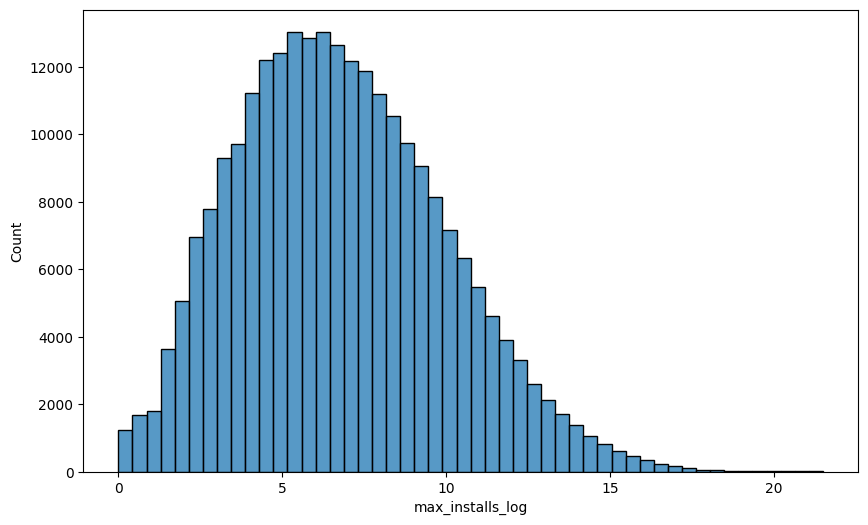

In [91]:
import seaborn as sns

plt.close('all')
gc.collect()

plt.figure(figsize=(10, 6))
sns.histplot(df_sample['max_installs_log'], bins=50)


In [92]:
df_sample['Rating_NaN_Mask'] = df_sample['Rating'].isna().astype(int)

Text(0.5, 1.0, 'Distribución de Maximum Installs según Rating NaN')

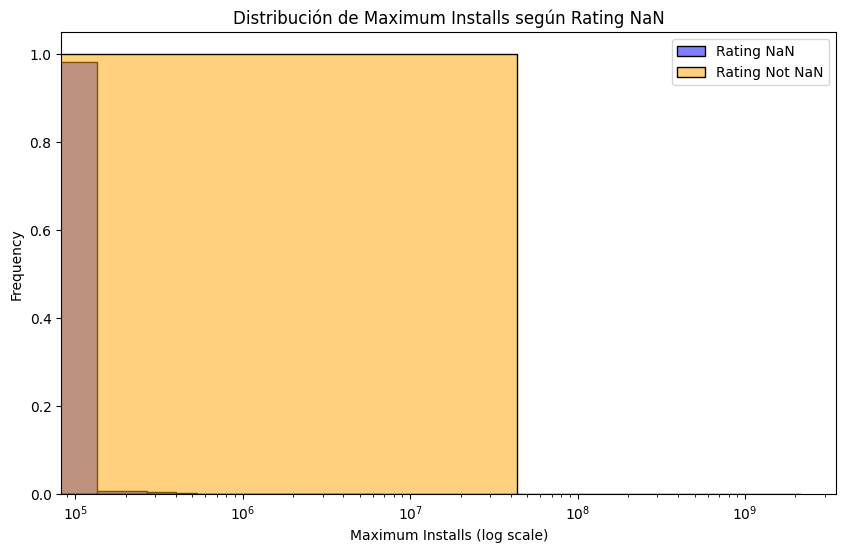

In [93]:
plt.close('all')

plt.figure(figsize=(10, 6))
sns.histplot(df_sample[df_sample['Rating_NaN_Mask']==1]['Maximum Installs'], bins=50, color='blue', alpha=0.5, label='Rating NaN', stat = 'probability')
plt.legend()
sns.histplot(df_sample[df_sample['Rating_NaN_Mask']==0]['Maximum Installs'], bins=50, color='orange', alpha=0.5, label='Rating Not NaN', stat = 'probability')
plt.legend()
plt.xlabel('Maximum Installs (log scale)')
plt.xscale('log')
plt.ylabel('Frequency')
plt.title('Distribución de Maximum Installs según Rating NaN')


Text(0.5, 1.0, 'Distribución de Maximum Installs según Rating NaN')

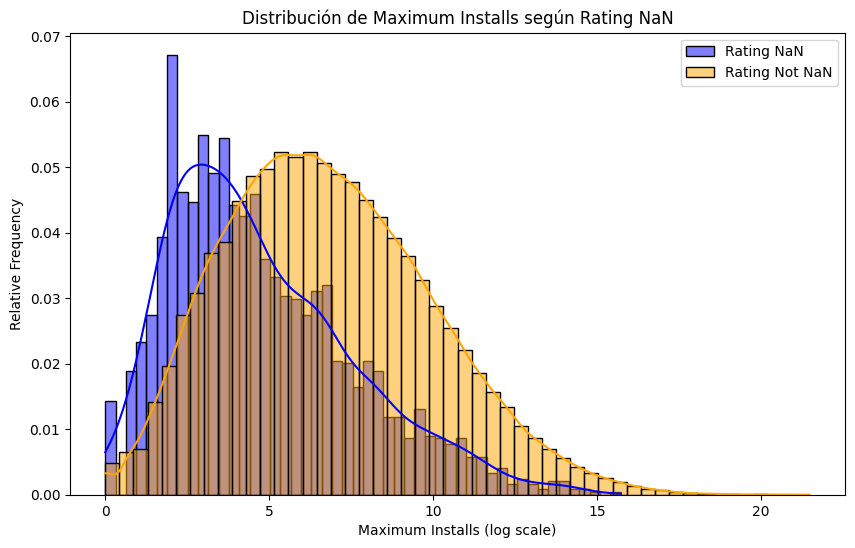

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.close('all')

plt.figure(figsize=(10, 6))
sns.histplot(
    df_sample[df_sample['Rating_NaN_Mask']==1]['max_installs_log'],
    bins=50,
    color='blue',
    alpha=0.5,
    label='Rating NaN',
    stat='probability',
    kde=True
    )
plt.legend()
sns.histplot(df_sample[df_sample['Rating_NaN_Mask']==0]['max_installs_log'],
             bins=50,
             color='orange',
             alpha=0.5,
             label='Rating Not NaN',
             stat='probability',
             kde=True
             )
plt.legend()
plt.xlabel('Maximum Installs (log scale)')
#plt.xscale('log')
plt.ylabel('Relative Frequency')
plt.title('Distribución de Maximum Installs según Rating NaN')


<ipython-input-95-7915d01c3ea7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


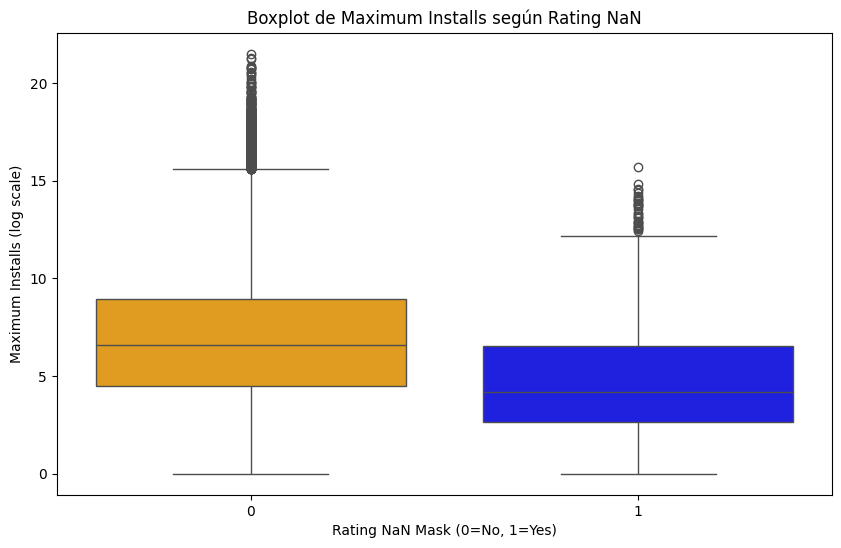

In [95]:
plt.close('all')

plt.figure(figsize=(10, 6))
# Convert the mask column to string to match palette keys
sns.boxplot(
	x=df_sample['Rating_NaN_Mask'].astype(str),
	y='max_installs_log',
	data=df_sample,
	palette={'0': 'orange', '1': 'blue'}
)
plt.title('Boxplot de Maximum Installs según Rating NaN')
plt.xlabel('Rating NaN Mask (0=No, 1=Yes)')
plt.ylabel('Maximum Installs (log scale)')
plt.show()

In [96]:
df_rating_loginstalls = df_sample[['Rating', 'max_installs_log']]

visualizar_resultados_con_color(analizar_mecanismo_faltantes_mejorado(df_rating_loginstalls,'Rating'), 0.05)


Analizando si 'Rating' tiene mecanismo MCAR/MAR (alpha = 0.05):

Resultados detallados de las pruebas estadísticas:
(Significancia (alpha) = 0.05)
(Un p-valor alto (> alpha) sugiere que no hay diferencia significativa, consistente con MCAR respecto a esa variable)
(Un p-valor bajo (<= alpha) sugiere una diferencia significativa, consistente con MAR respecto a esa variable)
Advertencia: Se realizaron múltiples pruebas estadísticas. Esto aumenta la probabilidad de falsos positivos (errores Tipo I). Considere métodos de corrección (e.g., Bonferroni) si es necesario.
- Comparando con 'max_installs_log':
  Test: t-test (Welch), Estadístico: -35.66314037972001, p-valor: 0.0000
  Tipo de Tamaño del Efecto: Cohen's d, Tamaño del Efecto: -0.6848

Resumen para 'Rating':
Variables para las cuales la ausencia en 'Rating' parece MAR (p <= 0.05):
['max_installs_log']

Variables para las cuales la ausencia en 'Rating' parece consistente con MCAR (p > 0.05):
Ninguna (o no se pudieron realizar pruebas

In [98]:
del df_rating_loginstalls

In [97]:
from sklearn.impute import KNNImputer

print(f"Missing values in 'Rating' before imputation: {df_sample['Rating'].isnull().sum()}")

imputer = KNNImputer(n_neighbors=5)

df_sample['Rating'] = imputer.fit_transform(df_sample[['Rating']])

print(f"Missing values in 'Rating' after imputation: {df_sample['Rating'].isnull().sum()}")

Missing values in 'Rating' before imputation: 2442
Missing values in 'Rating' after imputation: 0


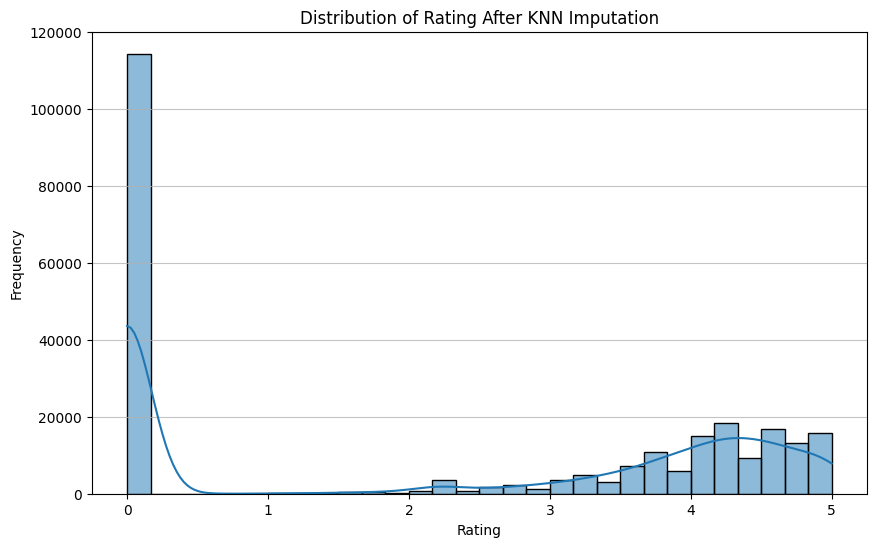

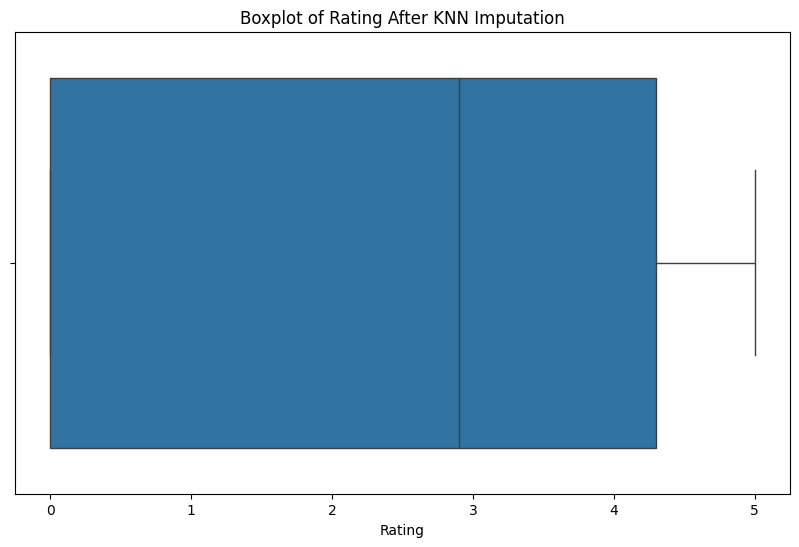

In [99]:
plt.close('all')
gc.collect()

plt.figure(figsize=(10, 6))
sns.histplot(df_sample['Rating'], bins=30, kde=True)
plt.title('Distribution of Rating After KNN Imputation')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Rating'])
plt.title('Boxplot of Rating After KNN Imputation')
plt.xlabel('Rating')
plt.show()

### Variable Rating Count

In [100]:
from statsmodels.stats.contingency_tables import mcnemar

# Create missing value masks for 'Rating' and 'Rating Count'
rating_missing_mask = df_sample['Rating'].isna().astype(int)
rating_count_missing_mask = df_sample['Rating Count'].isna().astype(int)

# Correlation between missingness
correlation = rating_missing_mask.corr(rating_count_missing_mask)
print(f"Correlation between missingness in 'Rating' and 'Rating Count': {correlation:.4f}")

# Test H0: The missingness distributions are the same (McNemar's test for paired binary data)

# Build contingency table
contingency = pd.crosstab(rating_missing_mask, rating_count_missing_mask)
print("\nContingency table of missingness:\n", contingency)

# McNemar's test (only works if there are discordant pairs)
result = mcnemar(contingency, exact=True)
print(f"\nMcNemar's test statistic: {result.statistic}, p-value: {result.pvalue:.4f}")

if result.pvalue < 0.05:
    print("Reject H0: The distributions of missing values are significantly different.")
else:
    print("Fail to reject H0: No significant difference in the distributions of missing values.")

Correlation between missingness in 'Rating' and 'Rating Count': nan

Contingency table of missingness:
 Rating Count       0     1
Rating                    
0             247557  2442

McNemar's test statistic: 0.0, p-value: 0.0000
Reject H0: The distributions of missing values are significantly different.


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [101]:
print(f"Missing values in 'Rating Count' before imputation: {df_sample['Rating Count'].isnull().sum()}")

imputer = KNNImputer(n_neighbors=5)

df_sample['Rating Count'] = imputer.fit_transform(df_sample[['Rating Count']])

print(f"Missing values in 'Rating Count' after imputation: {df_sample['Rating Count'].isnull().sum()}")

Missing values in 'Rating Count' before imputation: 2442
Missing values in 'Rating Count' after imputation: 0


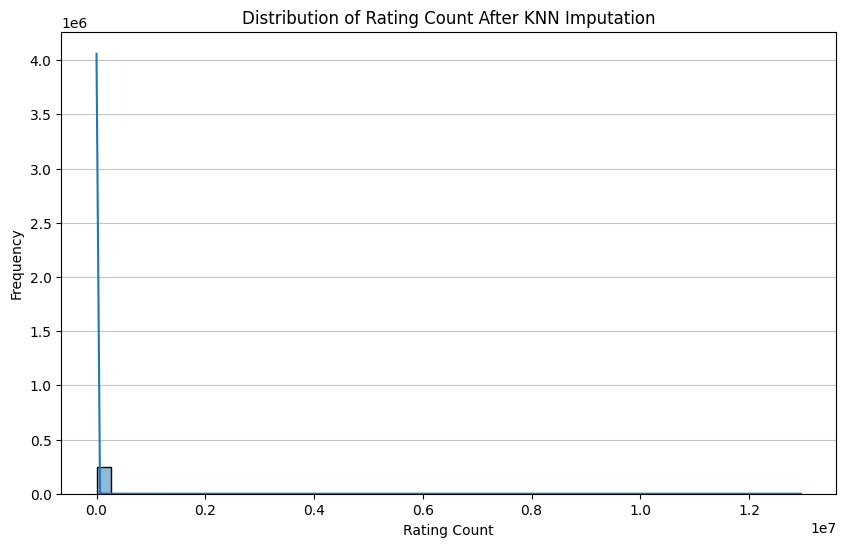

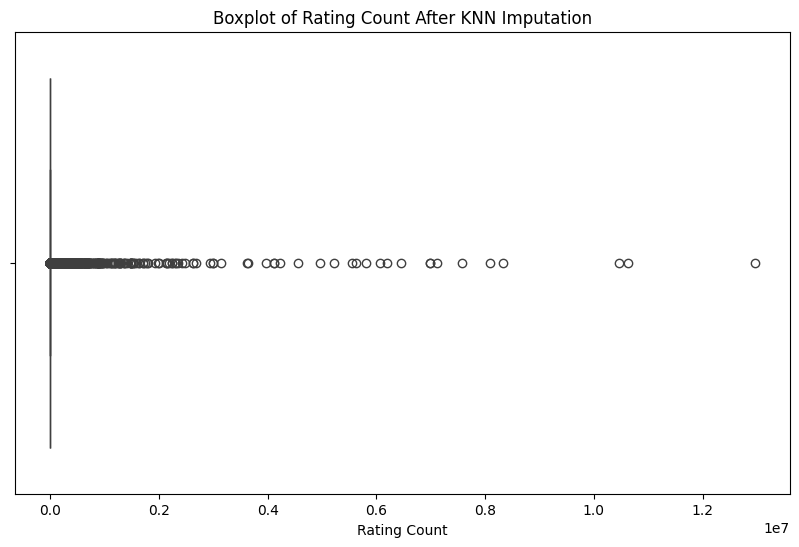

In [102]:
plt.close('all')
gc.collect()

plt.figure(figsize=(10, 6))
sns.histplot(df_sample['Rating Count'], bins=50, kde=True)
plt.title('Distribution of Rating Count After KNN Imputation')
plt.xlabel('Rating Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
#plt.xscale('log') # Log scale is likely appropriate for count data with a wide range
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Rating Count'])
plt.title('Boxplot of Rating Count After KNN Imputation')
plt.xlabel('Rating Count')
#plt.xscale('log')
plt.show()

Al ver que la densidad es alta en el cero, creamos una variable binaria donde se separa por apps con y sin ratings.

In [103]:
df_sample['No_Ratings'] = (df_sample['Rating Count'] == 0).astype(int)

# Display the first few rows to verify the new column
print(df_sample[['Rating Count', 'No_Ratings']].head())

# Display the value counts for the new column
print("\nValue counts for 'No_Ratings':")
print(df_sample['No_Ratings'].value_counts())


   Rating Count  No_Ratings
0           0.0           1
1         217.0           0
2           0.0           1
3         122.0           0
4           0.0           1

Value counts for 'No_Ratings':
No_Ratings
0    135557
1    114442
Name: count, dtype: int64


<ipython-input-104-f5b3daef4228>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_ratings_percentage.index, y=no_ratings_percentage.values, palette='viridis')


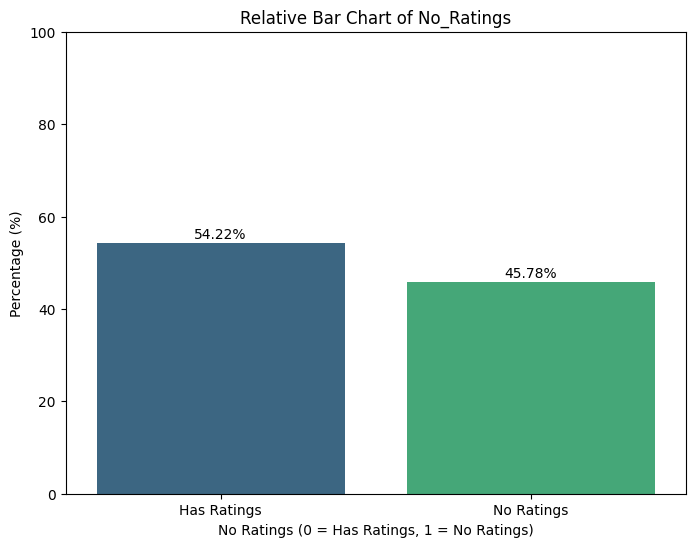

In [104]:
# Calculate the percentage of apps with no ratings
no_ratings_percentage = df_sample['No_Ratings'].value_counts(normalize=True) * 100

# Plotting the relative bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=no_ratings_percentage.index, y=no_ratings_percentage.values, palette='viridis')

plt.title('Relative Bar Chart of No_Ratings')
plt.xlabel('No Ratings (0 = Has Ratings, 1 = No Ratings)')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Has Ratings', 'No Ratings']) # Improve readability of x-axis labels
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
for index, value in enumerate(no_ratings_percentage.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center')

plt.show()

Esto separa la muestra casi a la mitad.

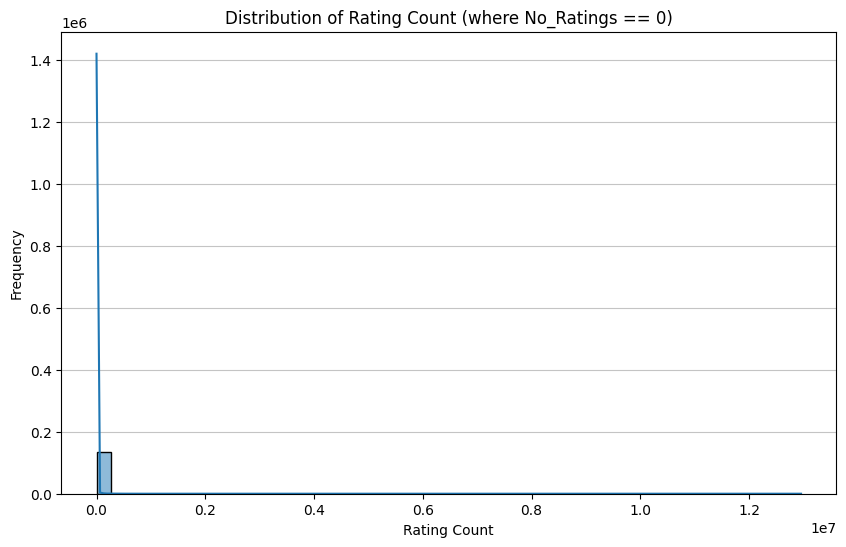

In [105]:
plt.figure(figsize=(10, 6))
sns.histplot(
    df_sample[df_sample['No_Ratings'] == 0]['Rating Count'],
    bins=50,
    kde=True
)
plt.title('Distribution of Rating Count (where No_Ratings == 0)')
plt.xlabel('Rating Count')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
# You might still want a log scale depending on the distribution of apps that *do* have ratings
# plt.xscale('log')
plt.show()

La asimetría es muy marcada por lo que usaremos su transformación logarítmica.

        Rating Count  Rating_Count_log
14758            7.0          2.079442
133951        2005.0          7.603898
4450             0.0          0.000000
82303            6.0          1.945910
58856           58.0          4.077537


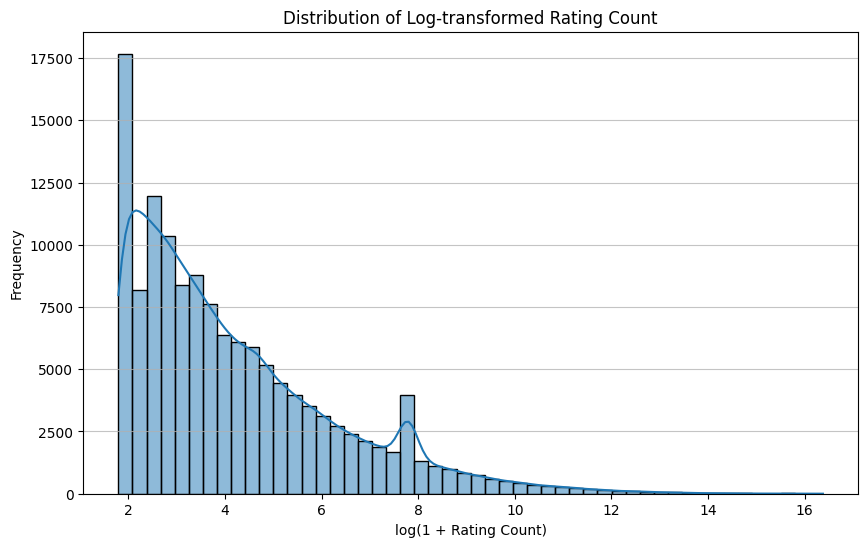

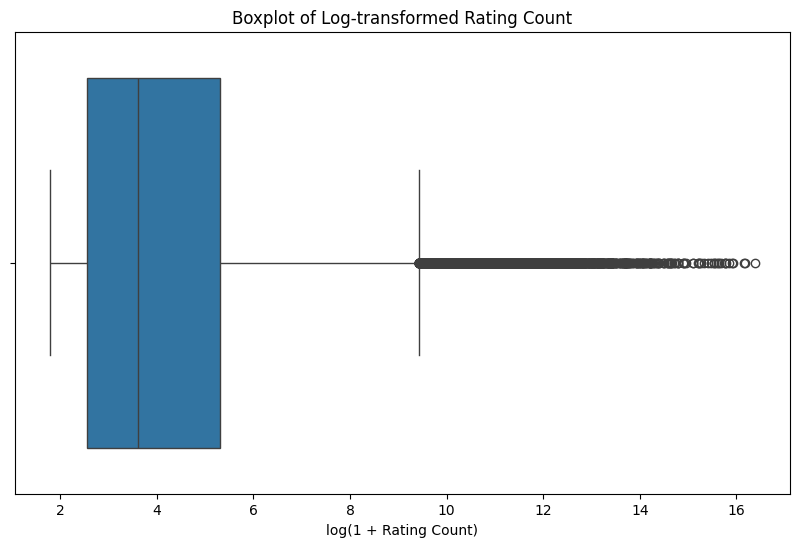

In [190]:
df_sample['Rating_Count_log'] = np.log1p(df_sample['Rating Count'])

# Display the first few rows to verify the new column
print(df_sample[['Rating Count', 'Rating_Count_log']].head())

plt.close('all')
gc.collect()
# Plot the distribution of the log-transformed Rating Count
plt.figure(figsize=(10, 6))
sns.histplot(df_sample[df_sample['No_Ratings']==0]['Rating_Count_log'], bins=50, kde=True)
plt.title('Distribution of Log-transformed Rating Count')
plt.xlabel('log(1 + Rating Count)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample[df_sample['No_Ratings']==0]['Rating_Count_log'])
plt.title('Boxplot of Log-transformed Rating Count')
plt.xlabel('log(1 + Rating Count)')
plt.show()


La asimetría marcada persiste a pesar de la transformación.

In [107]:
print(f"NaN count in 'Rating_Count_log': {df_sample['Rating_Count_log'].isna().sum()}")

NaN count in 'Rating_Count_log': 0


### Variable Maximun Installs

Gran parte de la exploración de esta variable se hizo a la par con Rating ya que son ambas variables resultado de interés.

In [ ]:
#df_resumen = analizar_dataframe_efficient(df_sample, scl=2.327)

df_resumen2.T['Maximum Installs']


Value counts for 'No_Installs':
No_Installs
0    248770
1      1229
Name: count, dtype: int64


<ipython-input-108-03e9afbb4657>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_installs_percentage.index, y=no_installs_percentage.values, palette='viridis')


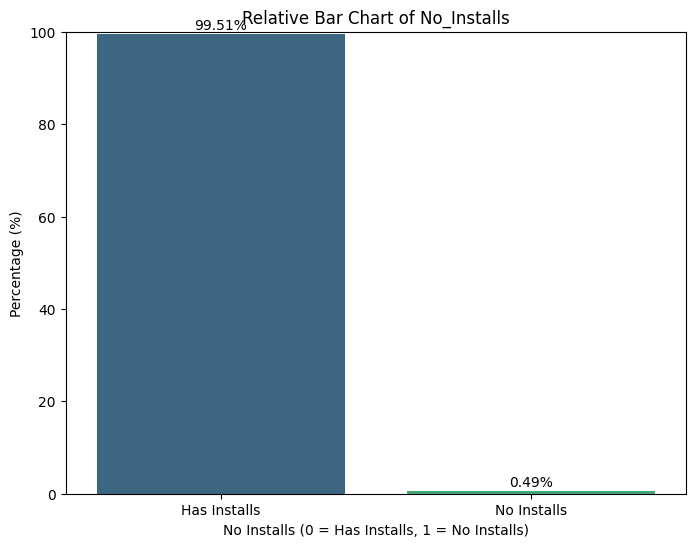

In [108]:
df_sample['No_Installs'] = (df_sample['Maximum Installs'] == 0).astype(int)


# Display the value counts for the new column
print("\nValue counts for 'No_Installs':")
print(df_sample['No_Installs'].value_counts())


# Calculate the percentage of apps with no installs
no_installs_percentage = df_sample['No_Installs'].value_counts(normalize=True) * 100

# Plotting the relative bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=no_installs_percentage.index, y=no_installs_percentage.values, palette='viridis')

plt.title('Relative Bar Chart of No_Installs')
plt.xlabel('No Installs (0 = Has Installs, 1 = No Installs)')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Has Installs', 'No Installs']) # Improve readability of x-axis labels
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
for index, value in enumerate(no_installs_percentage.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center')

plt.show()


### Variable Minimum Installs

In [109]:
df_resumen.T['Minimum Installs']

Tipo                    float64
cant_NA                      13
% NA                       0.01
pos_NA                        0
Uniq                         20
% Uniq                     0.01
Moda                      100.0
Pcat                  Pos. Cat.
Bias                 right bias
Extremos                    152
Min                         0.0
Max                1000000000.0
Rango              1000000000.0
Media                 152341.88
Mediana                   500.0
Desv.Std             6440768.87
CV                        42.28
P5                             
P25                        50.0
P75                      5000.0
P95                            
ID_posible                   No
Long_texto_prom             N/A
Top_5_Valores               N/A
Posible_Fecha                No
Posible_Numero               No
Name: Minimum Installs, dtype: object

In [110]:
visualizar_resultados_con_color(analizar_mecanismo_faltantes_mejorado(df_sample,'Minimum Installs'), 0.05)


Analizando si 'Minimum Installs' tiene mecanismo MCAR/MAR (alpha = 0.05):


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Resultados detallados de las pruebas estadísticas:
(Significancia (alpha) = 0.05)
(Un p-valor alto (> alpha) sugiere que no hay diferencia significativa, consistente con MCAR respecto a esa variable)
(Un p-valor bajo (<= alpha) sugiere una diferencia significativa, consistente con MAR respecto a esa variable)
Advertencia: Se realizaron múltiples pruebas estadísticas. Esto aumenta la probabilidad de falsos positivos (errores Tipo I). Considere métodos de corrección (e.g., Bonferroni) si es necesario.
- Comparando con 'App Name':
  Test: chi-squared, Estadístico: 249998.0000000001, p-valor: 0.0000
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 1.0000
- Comparando con 'App Id':
  Test: chi-squared, Estadístico: 249998.9999999999, p-valor: 0.4991
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 1.0000
- Comparando con 'Category':
  Test: chi-squared, Estadístico: 377.7212218840253, p-valor: 0.0000
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 0.0389
-

In [111]:
# Imputar valores faltantes de 'Minimum Installs' con la mediana (distribución lognormal)
mediana_min_installs = df_sample['Minimum Installs'].median()
df_sample['Minimum Installs'].fillna(mediana_min_installs, inplace=True)

# Verificar que ya no hay valores faltantes
print(f"Valores faltantes en 'Minimum Installs' después de imputar: {df_sample['Minimum Installs'].isnull().sum()}")

Valores faltantes en 'Minimum Installs' después de imputar: 0


<ipython-input-111-a2940a564b51>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sample['Minimum Installs'].fillna(mediana_min_installs, inplace=True)


Esta variable describe lo mismo que Maximum Installs pero aparenta estar más "sucia", por lo que la dejamos a un lado.

## Variables Categóricas

### Variable Scraped Time

In [ ]:
df_resumen.T['Scraped Time']

In [112]:
df_sample['Scraped Time'] = pd.to_datetime(df_sample['Scraped Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_sample['Scraped Time'].describe()

count                           249999
mean     2021-06-16 05:18:49.061616128
min                2021-06-15 20:19:35
25%                2021-06-16 01:01:11
50%                2021-06-16 05:18:51
75%                2021-06-16 09:37:45
max                2021-06-16 15:10:42
Name: Scraped Time, dtype: object

### Variable Last Updated

In [ ]:
df_resumen.T['Last Updated']

In [113]:
# Convert 'Last Updated' to datetime (date only, no time)
df_sample['Last Updated'] = pd.to_datetime(df_sample['Last Updated'], errors='coerce').dt.date
df_sample['Last Updated'].describe()

count         249999
unique          3295
top       2021-06-10
freq            1251
Name: Last Updated, dtype: object

In [114]:
print(df_sample['Last Updated'].isna().sum())

0


### Variable Released

In [115]:
df_sample['Released'] = pd.to_datetime(df_sample['Released'], errors='coerce').dt.date
df_sample['Released'].describe()
print(df_sample['Released'].isna().sum())

7660


In [ ]:
df_resumen.T['Released']

In [116]:
visualizar_resultados_con_color(analizar_mecanismo_faltantes_mejorado(df_sample,'Released'), 0.05)


Analizando si 'Released' tiene mecanismo MCAR/MAR (alpha = 0.05):


<ipython-input-69-a3fc0ed916ff>:157: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(df_copy[otra_var]) or \



Resultados detallados de las pruebas estadísticas:
(Significancia (alpha) = 0.05)
(Un p-valor alto (> alpha) sugiere que no hay diferencia significativa, consistente con MCAR respecto a esa variable)
(Un p-valor bajo (<= alpha) sugiere una diferencia significativa, consistente con MAR respecto a esa variable)
Advertencia: Se realizaron múltiples pruebas estadísticas. Esto aumenta la probabilidad de falsos positivos (errores Tipo I). Considere métodos de corrección (e.g., Bonferroni) si es necesario.
- Comparando con 'App Name':
  Test: chi-squared, Estadístico: 248375.27551714642, p-valor: 0.0005
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 0.9967
- Comparando con 'App Id':
  Test: chi-squared, Estadístico: 249999.00000000006, p-valor: 0.4991
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 1.0000
- Comparando con 'Category':
  Test: chi-squared, Estadístico: 2206.1960255208396, p-valor: 0.0000
  Tipo de Tamaño del Efecto: Cramer's V, Tamaño del Efecto: 0.093

Imputamos los faltantes de Released con el último valor no nulo ordenando por Last Updated que no tiene nulos.

In [117]:
df_sample = df_sample.sort_values(by='Last Updated')
df_sample['Released'].ffill(inplace=True)
print(df_sample['Released'].isna().sum())

<ipython-input-117-0624d04ebcb4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sample['Released'].ffill(inplace=True)


0


Creamos variables numéricas de interés a partir de las fechas.

In [118]:
# Ensure 'Released' and 'Last Updated' are datetime.date objects
# (Already converted in previous cells, but let's check and convert if needed)
if df_sample['Released'].dtype != 'O' or not isinstance(df_sample['Released'].dropna().iloc[0], (pd.Timestamp, type(pd.to_datetime('2020-01-01').date()))):
    df_sample['Released'] = pd.to_datetime(df_sample['Released'], errors='coerce').dt.date
if df_sample['Last Updated'].dtype != 'O' or not isinstance(df_sample['Last Updated'].dropna().iloc[0], (pd.Timestamp, type(pd.to_datetime('2020-01-01').date()))):
    df_sample['Last Updated'] = pd.to_datetime(df_sample['Last Updated'], errors='coerce').dt.date

# Calculate the difference in days as float
df_sample['Active_Life'] = (
    (pd.to_datetime(df_sample['Last Updated']) - pd.to_datetime(df_sample['Released']))
    .dt.total_seconds() / 86400
)

In [119]:
AL_Resumen = analizar_dataframe_efficient(pd.DataFrame( df_sample['Active_Life']))
AL_Resumen.T

<ipython-input-68-405567d4000a>:212: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return mat.fillna('')


Active_Life
Tipo                float64
cant_NA                   0
% NA                    0.0
pos_NA                    0
Uniq                   4153
% Uniq                 1.66
Moda                    0.0
Pcat              Pos. Cat.
Bias             right bias
Extremos              10834
Min                 -1740.0
Max                  4148.0
Rango                5888.0
Media                461.71
Mediana               148.0
Desv.Std             668.95
CV                     1.45
P5                         
P25                     1.0
P75                   682.0
P95                        
ID_posible               No
Long_texto_prom         N/A
Top_5_Valores           N/A
Posible_Fecha            No
Posible_Numero           No

Text(0, 0.5, 'Frequency')

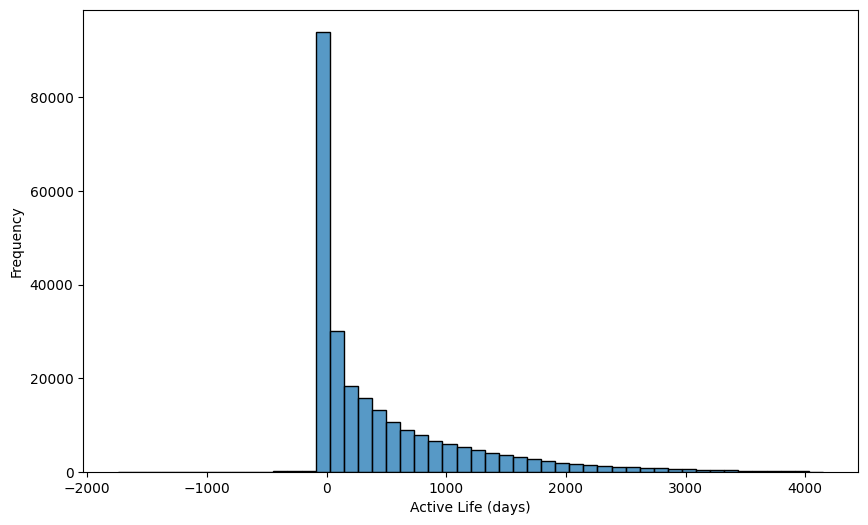

In [120]:
plt.close('all')
gc.collect()

plt.figure(figsize=(10, 6))
sns.histplot(df_sample['Active_Life'].dropna(), bins=50)
plt.xlabel('Active Life (days)')
plt.ylabel('Frequency')

In [121]:
# Filter rows where 'Active_Life' is negative
df_negative_active_life = df_sample[df_sample['Active_Life'] < 0][['Active_Life', 'Last Updated', 'Released']]

# Display the resulting DataFrame
df_negative_active_life

Active_Life Last Updated    Released
94163        -524.0   2009-11-05  2011-04-13
134831       -477.0   2009-12-22  2011-04-13
183369       -451.0   2010-01-17  2011-04-13
331          -450.0   2010-01-18  2011-04-13
85926        -402.0   2010-03-07  2011-04-13
42428       -1121.0   2012-11-19  2015-12-15
19479        -636.0   2013-07-25  2015-04-22
75344        -601.0   2013-09-11  2015-05-05
146693       -824.0   2013-10-09  2016-01-11
213678       -641.0   2013-10-22  2015-07-25
50670        -366.0   2013-11-06  2014-11-07
28551        -778.0   2013-12-02  2016-01-19
226867       -769.0   2014-01-02  2016-02-10
158465       -723.0   2014-01-15  2016-01-08
23428         -40.0   2014-01-19  2014-02-28
48853        -953.0   2014-03-19  2016-10-27
181436       -699.0   2014-03-26  2016-02-23
239467       -699.0   2014-03-26  2016-02-23
241760       -517.0   2014-08-31  2016-01-30
1195          -51.0   2014-09-09  2014-10-30
61088        -451.0   2014-09-15  2015-12-10
37058        -531.0   2014-09-24  2016-03-08
39259        -131.0   2014-10-19  2015-02-27
109248        -11.0   2014-10-20  2014-10-31
17190        -210.0   2014-10-21  2015-05-19
249580        -43.0   2014-10-27  2014-12-09
45689        -492.0   2014-10-28  2016-03-03
143587        -46.0   2014-10-30  2014-12-15
65650        -580.0   2014-11-12  2016-06-14
209771       -422.0   2014-11-14  2016-01-10
48632        -381.0   2014-11-24  2015-12-10
9680         -708.0   2014-11-25  2016-11-02
9163         -440.0   2014-11-25  2016-02-08
143076        -60.0   2014-12-11  2015-02-09
53683        -485.0   2015-01-21  2016-05-20
13917        -355.0   2015-01-23  2016-01-13
232456        -24.0   2015-02-19  2015-03-15
70029        -300.0   2015-02-25  2015-12-22
114956       -250.0   2015-03-24  2015-11-29
183915       -252.0   2015-03-24  2015-12-01
4832        -1014.0   2015-04-07  2018-01-15
208134      -1740.0   2015-04-10  2020-01-14
181105       -699.0   2015-04-15  2017-03-14
161914       -107.0   2015-04-16  2015-08-01
136608       -188.0   2015-04-22  2015-10-27
179031       -365.0   2015-04-26  2016-04-25
237614       -245.0   2015-05-13  2016-01-13
243382       -256.0   2015-05-15  2016-01-26
189224       -406.0   2015-05-18  2016-06-27
193527         -1.0   2015-05-27  2015-05-28
27581        -223.0   2015-06-04  2016-01-13
33719          -5.0   2015-06-05  2015-06-10
28942        -127.0   2015-06-12  2015-10-17
15751          -1.0   2015-06-15  2015-06-16
11623        -197.0   2015-06-17  2015-12-31
196101       -853.0   2015-07-01  2017-10-31
101268      -1425.0   2015-07-01  2019-05-26
155709       -321.0   2015-07-03  2016-05-19
82846        -576.0   2015-07-10  2017-02-05
185233       -882.0   2015-07-14  2017-12-12
12646         -77.0   2015-07-22  2015-10-07
190078         -2.0   2015-08-02  2015-08-04
210492         -4.0   2015-08-08  2015-08-12
222629         -1.0   2015-08-25  2015-08-26
200124       -746.0   2015-08-27  2017-09-11
240119       -745.0   2015-08-28  2017-09-11
242151       -745.0   2015-08-28  2017-09-11
169891       -734.0   2015-09-08  2017-09-11
243709       -241.0   2015-09-08  2016-05-06
216882       -733.0   2015-09-09  2017-09-11
215080       -733.0   2015-09-09  2017-09-11
86060        -733.0   2015-09-09  2017-09-11
68548        -728.0   2015-09-14  2017-09-11
53905         -64.0   2015-09-15  2015-11-18
34040        -724.0   2015-09-18  2017-09-11
221858       -714.0   2015-09-28  2017-09-11
189535       -714.0   2015-09-28  2017-09-11
47792       -1065.0   2015-09-29  2018-08-29
21375        -711.0   2015-10-01  2017-09-11
54194        -572.0   2015-10-01  2017-04-25
189788      -1036.0   2015-10-05  2018-08-06
58699        -171.0   2015-10-13  2016-04-01
80698        -697.0   2015-10-15  2017-09-11
158381       -510.0   2015-10-16  2017-03-09
32384       -1023.0   2015-10-18  2018-08-06
205602      -1080.0   2015-10-18  2018-10-02
183745      -1079.0   2015-10-20  2018-10-03
34685        -790.0   2015-10-26  2017-12-24
567

Eliminamos los registros imposibles.

In [122]:
df_sample.drop(df_sample[df_sample['Active_Life'] < 0].index, inplace=True)

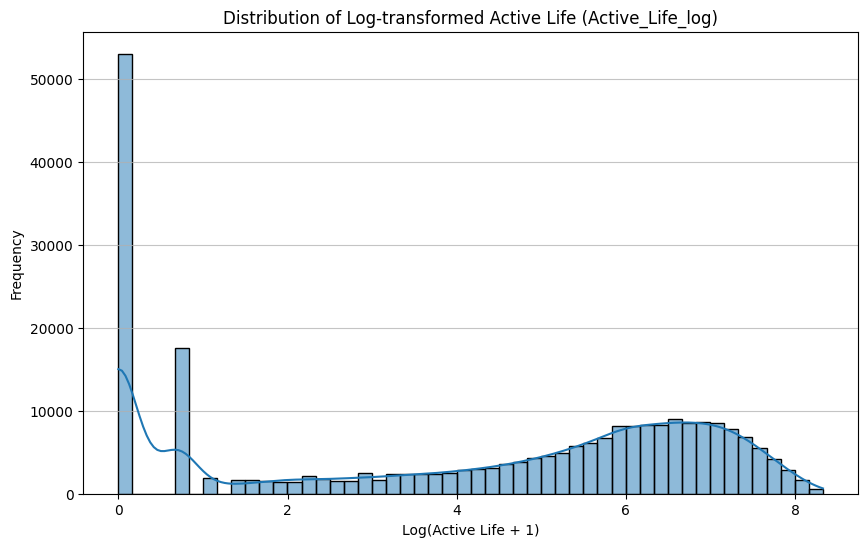

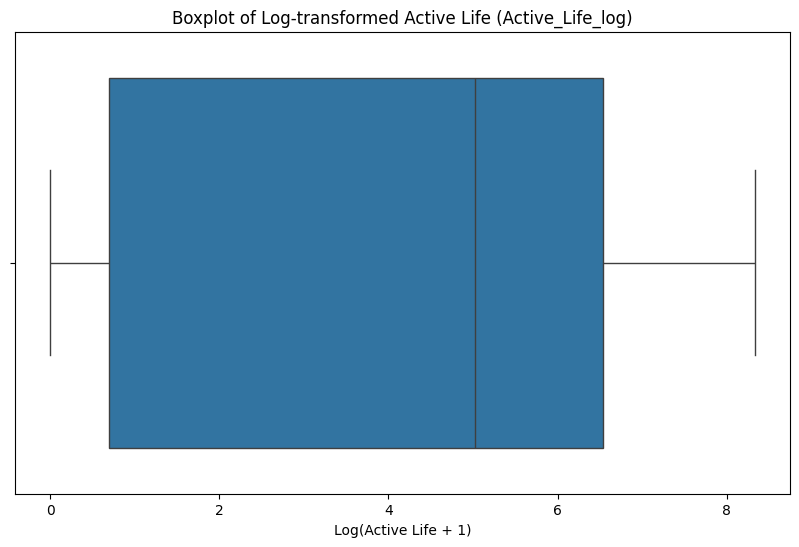

In [123]:
# Add 1 to Active_Life before taking the log to handle values of 0
df_sample['Active_Life_log'] = np.log(df_sample['Active_Life'] + 1)

# Visualize the distribution of the log-transformed 'Active_Life'
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['Active_Life_log'], bins=50, kde=True)
plt.title('Distribution of Log-transformed Active Life (Active_Life_log)')
plt.xlabel('Log(Active Life + 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Visualize the boxplot of the log-transformed 'Active_Life'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Active_Life_log'])
plt.title('Boxplot of Log-transformed Active Life (Active_Life_log)')
plt.xlabel('Log(Active Life + 1)')
plt.show()



Value counts for 'No_Active_Life':
No_Active_Life
0    195856
1     53011
Name: count, dtype: int64


<ipython-input-124-4ccd0e64cfdd>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_active_life_percentage.index, y=no_active_life_percentage.values, palette='viridis')


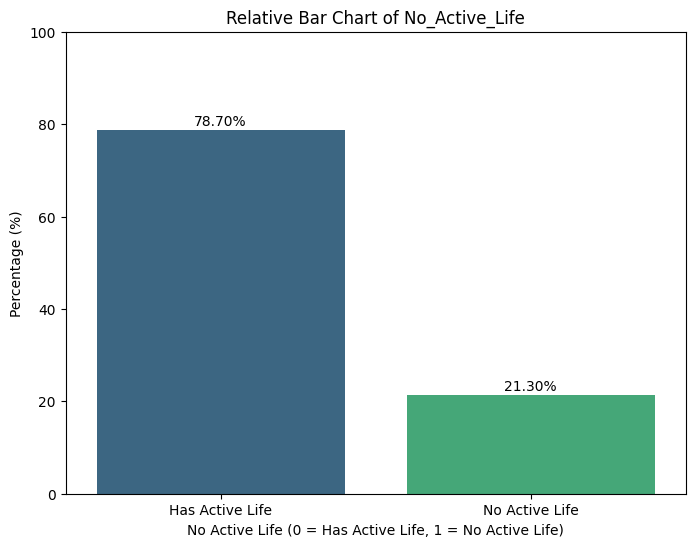

In [124]:
df_sample['No_Active_Life'] = (df_sample['Active_Life'] <= 0).astype(int)

# Display the value counts for the new column
print("\nValue counts for 'No_Active_Life':")
print(df_sample['No_Active_Life'].value_counts())

# Calculate the percentage of apps with no active life (<= 0 days)
no_active_life_percentage = df_sample['No_Active_Life'].value_counts(normalize=True) * 100

# Plotting the relative bar chart
plt.close('all')
gc.collect()

plt.figure(figsize=(8, 6))
sns.barplot(x=no_active_life_percentage.index, y=no_active_life_percentage.values, palette='viridis')

plt.title('Relative Bar Chart of No_Active_Life')
plt.xlabel('No Active Life (0 = Has Active Life, 1 = No Active Life)')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Has Active Life', 'No Active Life']) # Improve readability of x-axis labels
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
for index, value in enumerate(no_active_life_percentage.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center')

plt.show()


In [125]:
df_sample['Time_Inactive'] = (
    (pd.to_datetime(df_sample['Scraped Time']) - pd.to_datetime(df_sample['Last Updated']))
    .dt.total_seconds() / 86400
)

In [126]:
inactive_resumen = analizar_dataframe_efficient(pd.DataFrame( df_sample['Time_Inactive']))
inactive_resumen.T

<ipython-input-68-405567d4000a>:212: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return mat.fillna('')


Time_Inactive
Tipo                  float64
cant_NA                     0
% NA                      0.0
pos_NA                      0
Uniq                   248333
% Uniq                  99.79
Moda                58.401481
Pcat             Pos. No Cat.
Bias               right bias
Extremos                 9410
Min                      0.08
Max                   4081.48
Rango                  4081.4
Media                  557.74
Mediana                394.11
Desv.Std               555.52
CV                        1.0
P5                           
P25                    129.06
P75                    791.07
P95                          
ID_posible                 Sí
Long_texto_prom           N/A
Top_5_Valores             N/A
Posible_Fecha              No
Posible_Numero             No

Text(0, 0.5, 'Frequency')

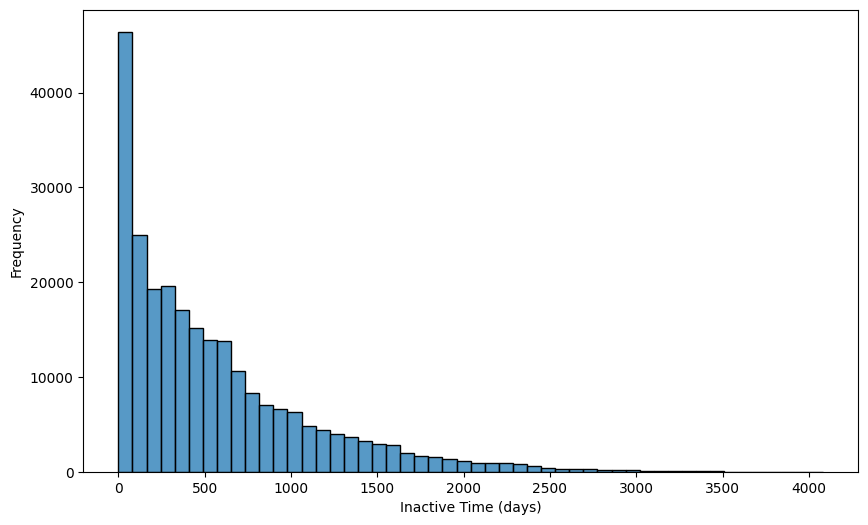

In [127]:
plt.close('all')
gc.collect()

plt.figure(figsize=(10, 6))
sns.histplot(df_sample['Time_Inactive'].dropna(), bins=50)
plt.xlabel('Inactive Time (days)')
plt.ylabel('Frequency')

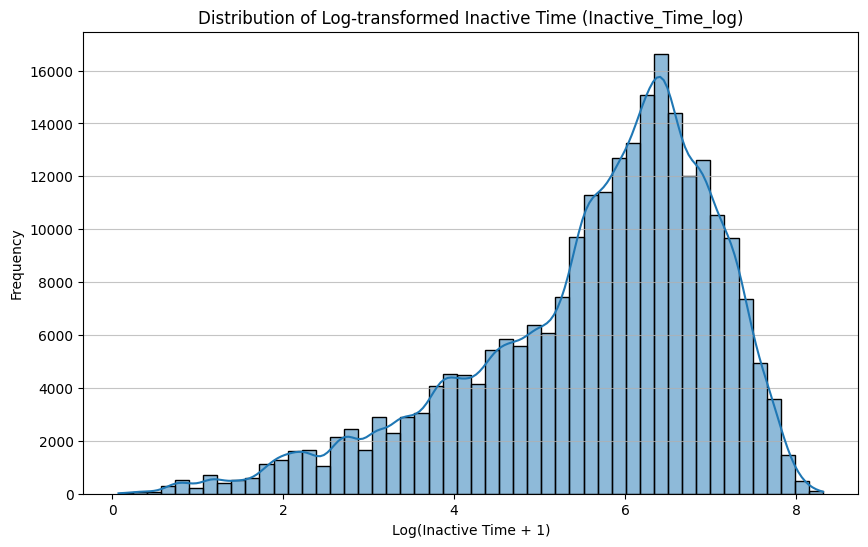

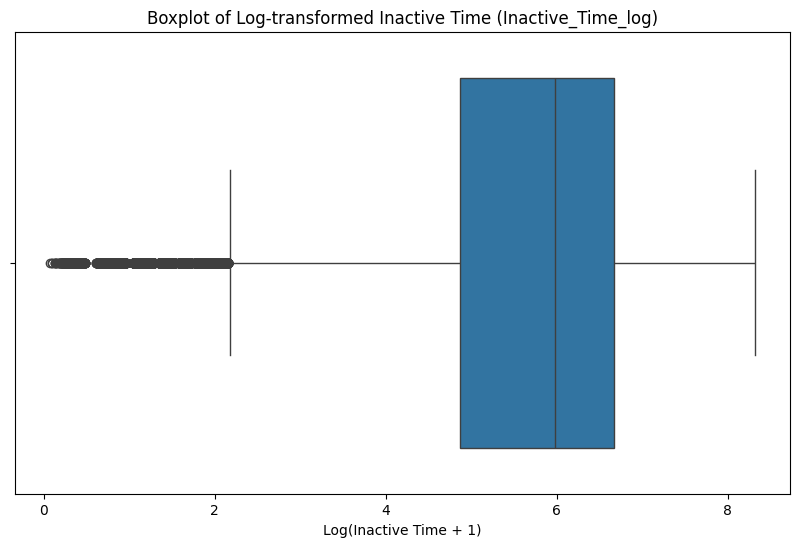


Value counts for 'No_Inactive_Time':
No_Inactive_Time
0    248867
Name: count, dtype: int64


<ipython-input-128-cbb79b83a97e>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=no_inactive_time_percentage.index, y=no_inactive_time_percentage.values, palette='viridis')


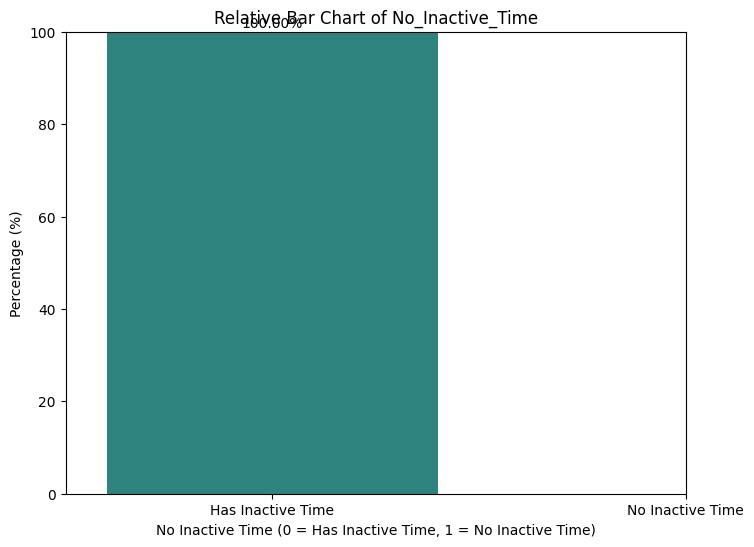

In [128]:
# prompt: generate the log transformed column Inactive_Time_log

# Create the log transformed column 'Inactive_Time_log'
# Add 1 to Time_Inactive before taking the log to handle values of 0
df_sample['Inactive_Time_log'] = np.log(df_sample['Time_Inactive'] + 1)

# Visualize the distribution of the log-transformed 'Time_Inactive'
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['Inactive_Time_log'], bins=50, kde=True)
plt.title('Distribution of Log-transformed Inactive Time (Inactive_Time_log)')
plt.xlabel('Log(Inactive Time + 1)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Visualize the boxplot of the log-transformed 'Time_Inactive'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_sample['Inactive_Time_log'])
plt.title('Boxplot of Log-transformed Inactive Time (Inactive_Time_log)')
plt.xlabel('Log(Inactive Time + 1)')
plt.show()

df_sample['No_Inactive_Time'] = (df_sample['Time_Inactive'] <= 0).astype(int)

# Display the value counts for the new column
print("\nValue counts for 'No_Inactive_Time':")
print(df_sample['No_Inactive_Time'].value_counts())

# Calculate the percentage of apps with no inactive time (<= 0 days)
no_inactive_time_percentage = df_sample['No_Inactive_Time'].value_counts(normalize=True) * 100

# Plotting the relative bar chart
plt.close('all')
gc.collect()

plt.figure(figsize=(8, 6))
sns.barplot(x=no_inactive_time_percentage.index, y=no_inactive_time_percentage.values, palette='viridis')

plt.title('Relative Bar Chart of No_Inactive_Time')
plt.xlabel('No Inactive Time (0 = Has Inactive Time, 1 = No Inactive Time)')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Has Inactive Time', 'No Inactive Time']) # Improve readability of x-axis labels
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
for index, value in enumerate(no_inactive_time_percentage.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center')

plt.show()

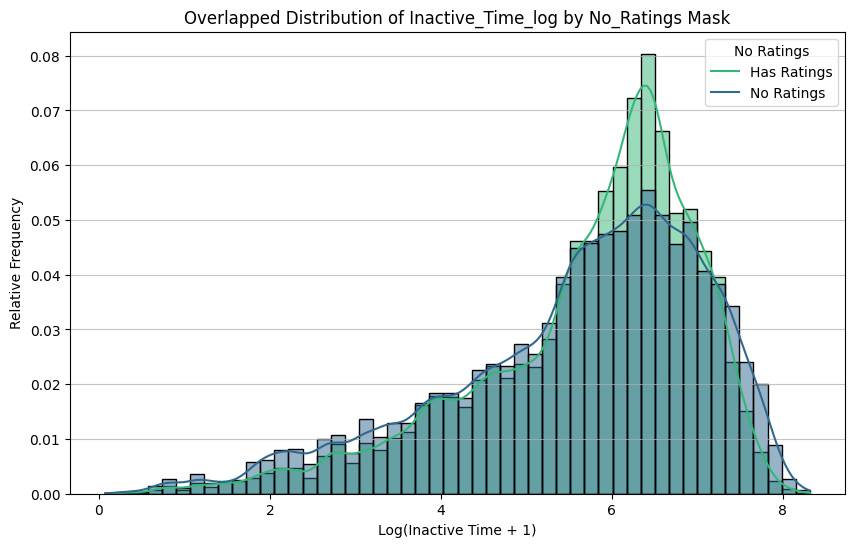

<ipython-input-129-24662e15d15f>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


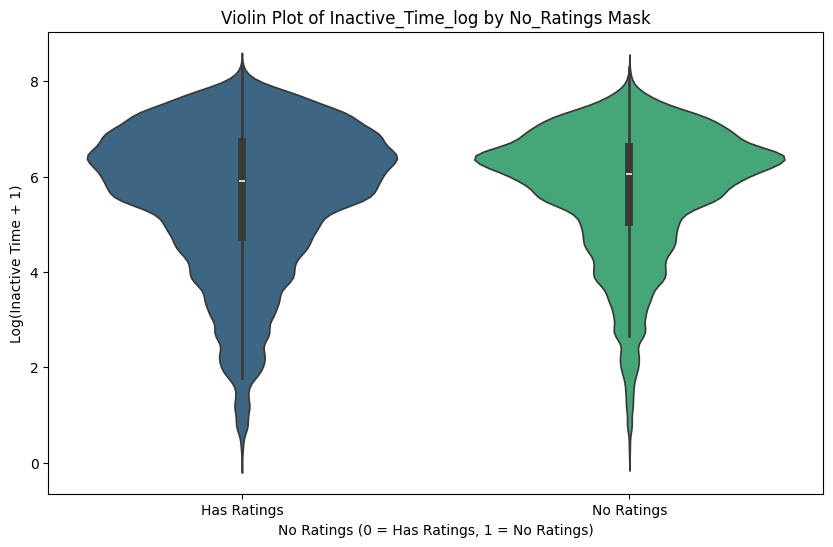

<ipython-input-129-24662e15d15f>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


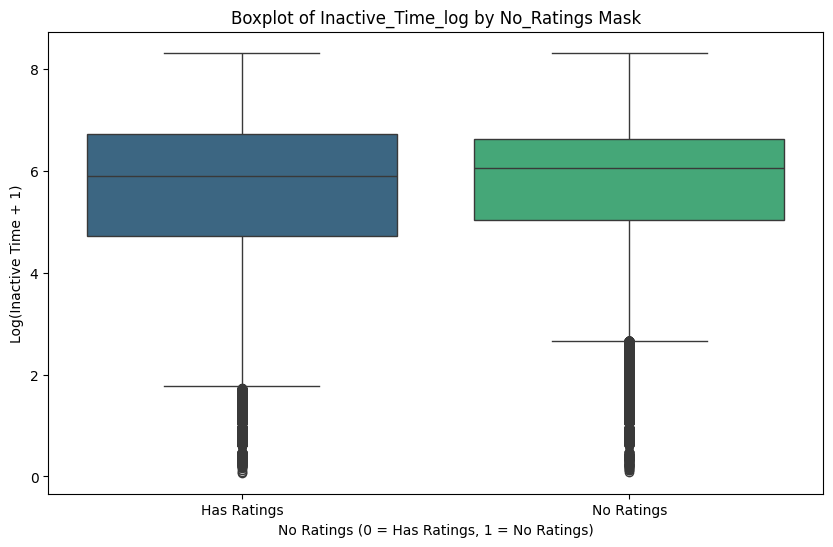

In [129]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_sample,
    x='Inactive_Time_log',
    hue='No_Ratings',  # Separate the distributions by 'No_Ratings'
    bins=50,
    kde=True,
    stat='probability', # Show probabilities (relative frequency)
    common_norm=False, # Normalize each histogram independently
    palette='viridis' # Choose a color palette
)

plt.title('Overlapped Distribution of Inactive_Time_log by No_Ratings Mask')
plt.xlabel('Log(Inactive Time + 1)')
plt.ylabel('Relative Frequency')
plt.legend(title='No Ratings', labels=['Has Ratings', 'No Ratings']) # Custom legend labels
plt.grid(axis='y', alpha=0.75)
plt.show()

# You can also use violin plots for a different view
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_sample,
    x='No_Ratings',
    y='Inactive_Time_log',
    palette='viridis'
)
plt.title('Violin Plot of Inactive_Time_log by No_Ratings Mask')
plt.xlabel('No Ratings (0 = Has Ratings, 1 = No Ratings)')
plt.ylabel('Log(Inactive Time + 1)')
plt.xticks(ticks=[0, 1], labels=['Has Ratings', 'No Ratings'])
plt.show()

# And a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_sample,
    x='No_Ratings',
    y='Inactive_Time_log',
    palette='viridis'
)
plt.title('Boxplot of Inactive_Time_log by No_Ratings Mask')
plt.xlabel('No Ratings (0 = Has Ratings, 1 = No Ratings)')
plt.ylabel('Log(Inactive Time + 1)')
plt.xticks(ticks=[0, 1], labels=['Has Ratings', 'No Ratings'])
plt.show()


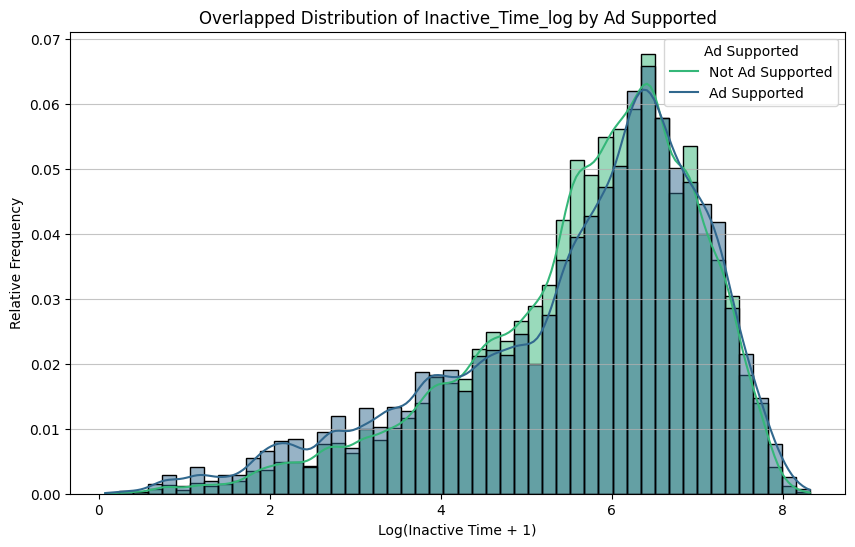

<ipython-input-130-33d9e4fecd08>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


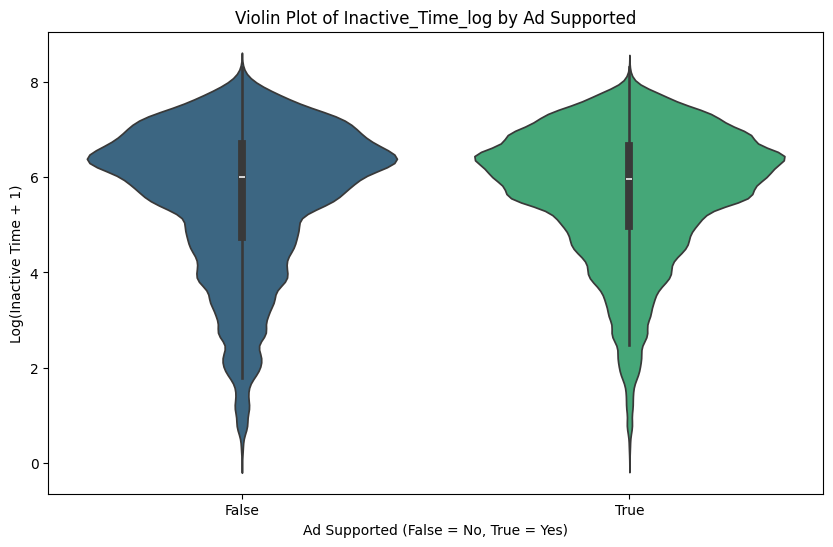

<ipython-input-130-33d9e4fecd08>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


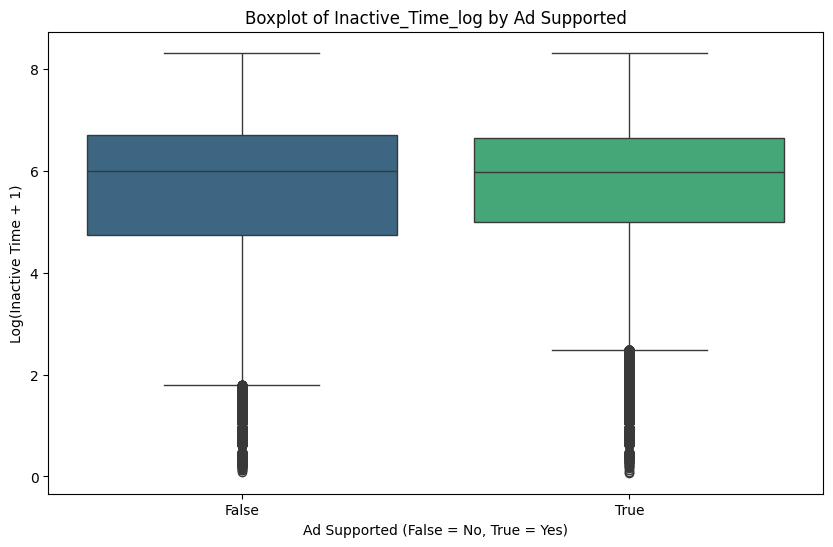

In [130]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_sample,
    x='Inactive_Time_log',
    hue='Ad Supported',  # Separate the distributions by 'Ad Supported'
    bins=50,
    kde=True,
    stat='probability', # Show probabilities (relative frequency)
    common_norm=False, # Normalize each histogram independently
    palette='viridis' # Choose a color palette
)

plt.title('Overlapped Distribution of Inactive_Time_log by Ad Supported')
plt.xlabel('Log(Inactive Time + 1)')
plt.ylabel('Relative Frequency')
plt.legend(title='Ad Supported', labels=['Not Ad Supported', 'Ad Supported']) # Custom legend labels
plt.grid(axis='y', alpha=0.75)
plt.show()

# You can also use violin plots for a different view
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_sample,
    x='Ad Supported',
    y='Inactive_Time_log',
    palette='viridis'
)
plt.title('Violin Plot of Inactive_Time_log by Ad Supported')
plt.xlabel('Ad Supported (False = No, True = Yes)')
plt.ylabel('Log(Inactive Time + 1)')
plt.show()

# And a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_sample,
    x='Ad Supported',
    y='Inactive_Time_log',
    palette='viridis'
)
plt.title('Boxplot of Inactive_Time_log by Ad Supported')
plt.xlabel('Ad Supported (False = No, True = Yes)')
plt.ylabel('Log(Inactive Time + 1)')
plt.show()

In [131]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_sample,
    x='Inactive_Time_log',
    hue='Cluster_Label',  # Separate the distributions by 'Cluster_Label'
    bins=50,
    kde=True,
    stat='probability', # Show probabilities (relative frequency)
    common_norm=False, # Normalize each histogram independently
    palette='viridis' # Choose a color palette
)

plt.title('Overlapped Distribution of Inactive_Time_log by Cluster_Label')
plt.xlabel('Log(Inactive Time + 1)')
plt.ylabel('Relative Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# You can also use violin plots for a different view
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_sample,
    x='Cluster_Label',
    y='Inactive_Time_log',
    palette='viridis'
)
plt.title('Violin Plot of Inactive_Time_log by Cluster_Label')
plt.xlabel('Cluster Label')
plt.ylabel('Log(Inactive Time + 1)')
plt.show()

# And a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_sample,
    x='Cluster_Label',
    y='Inactive_Time_log',
    palette='viridis'
)
plt.title('Boxplot of Inactive_Time_log by Cluster_Label')
plt.xlabel('Cluster Label')
plt.ylabel('Log(Inactive Time + 1)')
plt.show()

ValueError: Could not interpret value `Cluster_Label` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

### Variable Free

In [ ]:
df_resumen.T['Free']

<ipython-input-191-0ffd7dd201fc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Free', data=df_sample, palette='viridis')


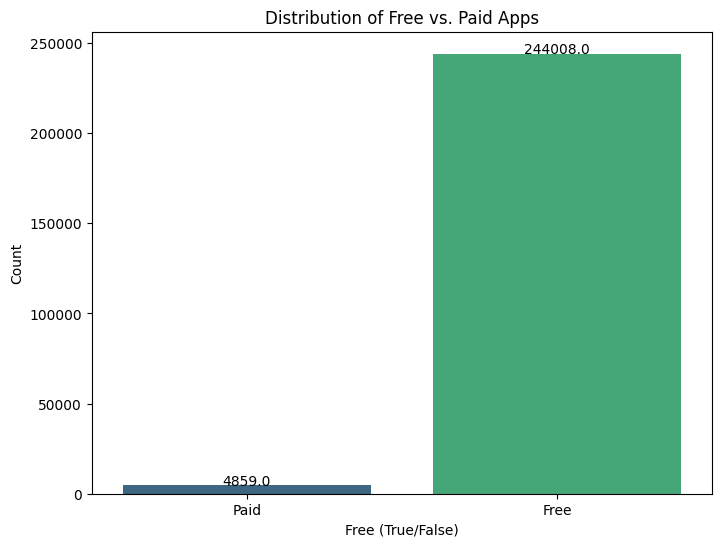

<ipython-input-191-0ffd7dd201fc>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentage.index, y=percentage.values, palette='viridis')


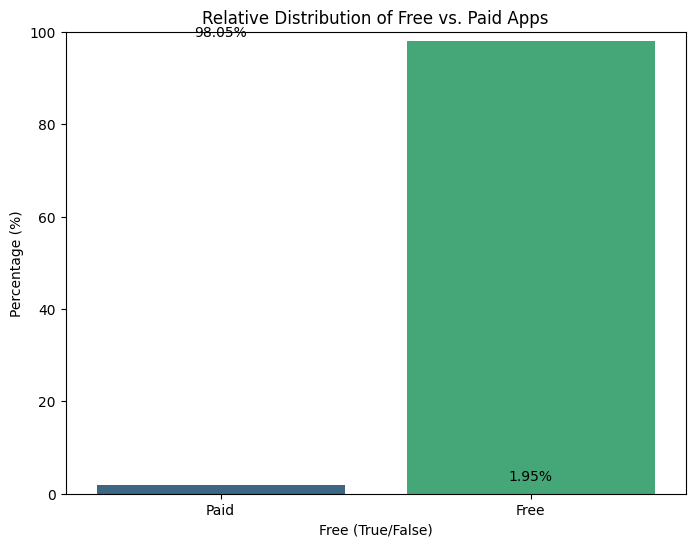

In [191]:
# prompt: plot the relative distribution for the bool column 'Free'

plt.figure(figsize=(8, 6))
sns.countplot(x='Free', data=df_sample, palette='viridis')

plt.title('Distribution of Free vs. Paid Apps')
plt.xlabel('Free (True/False)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Paid', 'Free']) # Assuming False=Paid, True=Free based on typical boolean column use

# Add count labels on the bars
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            f'{height}', ha="center")

plt.show()

# To show relative distribution (percentage)
plt.figure(figsize=(8, 6))
# Calculate percentage
percentage = df_sample['Free'].value_counts(normalize=True) * 100
sns.barplot(x=percentage.index, y=percentage.values, palette='viridis')

plt.title('Relative Distribution of Free vs. Paid Apps')
plt.xlabel('Free (True/False)')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Paid', 'Free']) # Assuming False=Paid, True=Free
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
ax = plt.gca()
for index, value in enumerate(percentage.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center')


plt.show()

La gran mayoría son gratuitas.

### Variable Content Rating

In [ ]:
df_resumen.T['Content Rating']

In [178]:
categorias_CR = df_sample['Content Rating'].unique()
print(f"Categorías únicas en 'Content Rating': {categorias_CR}")

Categorías únicas en 'Content Rating': ['Everyone' 'Teen' 'Mature 17+' 'Everyone 10+' 'Unrated' 'Adults only 18+']


Mapeamos a la edad mínima para respetar las distancias reales.

In [177]:
# Mapping for Content Rating to minimum age
content_rating_to_min_age = {
    'Everyone': 0,
    'Unrated': 0,
    'Mature 17+': 17,
    'Teen': 13,
    'Adults only 18+': 18,
    'Everyone 10+': 10
}

# Create the Min_Age column
df_sample['Min_Age'] = df_sample['Content Rating'].map(content_rating_to_min_age).astype('Int64')

### Variable Ad Supported

In [ ]:
df_resumen.T['Ad Supported']

<ipython-input-176-54ebd018be2d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentage.index, y=percentage.values, palette='viridis')


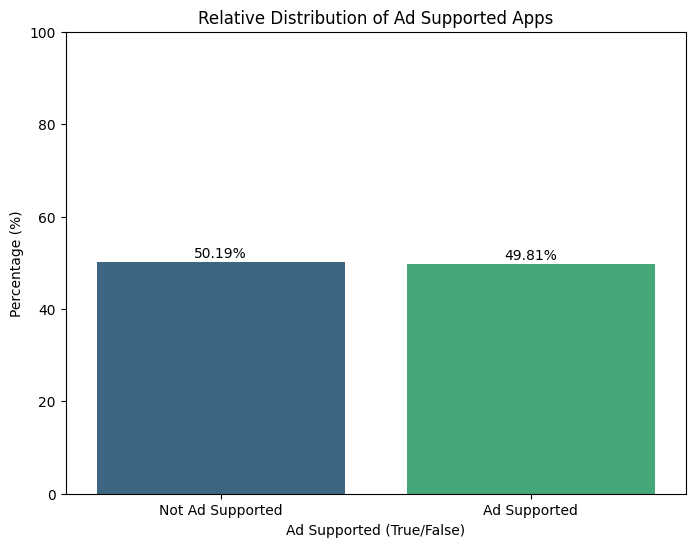

In [176]:
# To show relative distribution (percentage)
plt.figure(figsize=(8, 6))
# Calculate percentage
percentage = df_sample['Ad Supported'].value_counts(normalize=True) * 100
sns.barplot(x=percentage.index, y=percentage.values, palette='viridis')

plt.title('Relative Distribution of Ad Supported Apps')
plt.xlabel('Ad Supported (True/False)')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['Not Ad Supported', 'Ad Supported']) # Assuming False=Not Supported, True=Supported
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
ax = plt.gca()
for index, value in enumerate(percentage.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha="center")

plt.show()


Esta variable divide la muestra casi en dos.

### Variable In App Purchases

In [ ]:
df_resumen.T['In App Purchases']

<ipython-input-175-0d7ad65678d9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentage_iap.index, y=percentage_iap.values, palette='viridis')


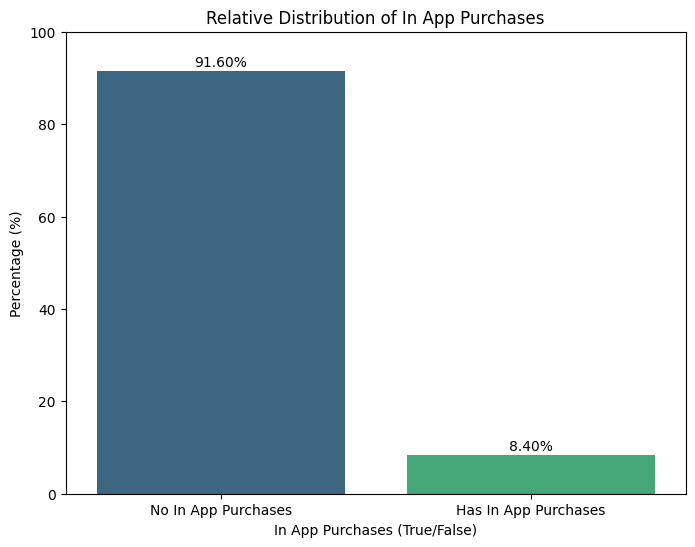

In [175]:
# Calculate the percentage of apps with In App Purchases
percentage_iap = df_sample['In App Purchases'].value_counts(normalize=True) * 100

# Plotting the proportional histogram (relative bar chart)
plt.figure(figsize=(8, 6))
sns.barplot(x=percentage_iap.index, y=percentage_iap.values, palette='viridis')

plt.title('Relative Distribution of In App Purchases')
plt.xlabel('In App Purchases (True/False)')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=['No In App Purchases', 'Has In App Purchases'])
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
ax = plt.gca()
for index, value in enumerate(percentage_iap.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha="center")

plt.show()

### Variable Editor Choice

In [ ]:
df_resumen.T['Editors Choice']

<ipython-input-174-0808f51adb29>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentage_editors_choice.index, y=percentage_editors_choice.values, palette='viridis')


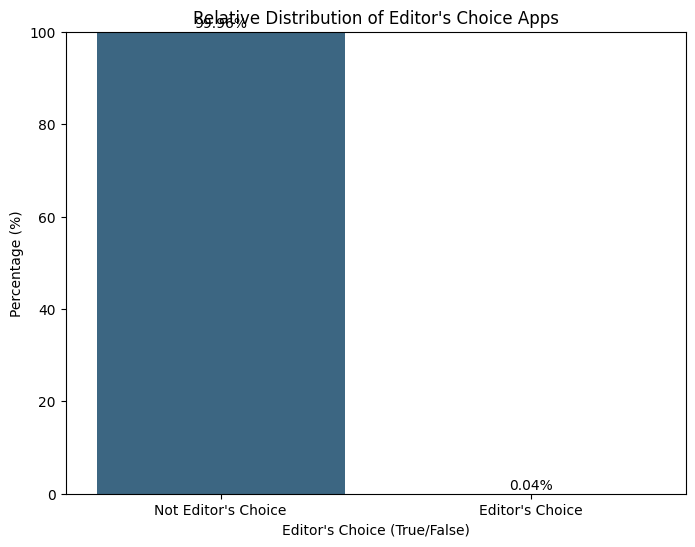

In [174]:
# prompt: Plot a proportional histogram for 'Editors Choice'

# Calculate the percentage of apps with Editors Choice
percentage_editors_choice = df_sample['Editors Choice'].value_counts(normalize=True) * 100

# Plotting the proportional histogram (relative bar chart)
plt.figure(figsize=(8, 6))
sns.barplot(x=percentage_editors_choice.index, y=percentage_editors_choice.values, palette='viridis')

plt.title("Relative Distribution of Editor's Choice Apps")
plt.xlabel("Editor's Choice (True/False)")
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1], labels=["Not Editor's Choice", "Editor's Choice"])
plt.ylim(0, 100) # Set y-axis limit from 0 to 100%

# Add percentage labels on the bars
ax = plt.gca()
for index, value in enumerate(percentage_editors_choice.values):
    plt.text(index, value + 1, f'{value:.2f}%', ha="center")

plt.show()

### Variable Category

In [ ]:
df_resumen.T['Category']

<ipython-input-169-f37daf0b6471>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sample, y='Category', order=df_sample['Category'].value_counts().index, palette='viridis')


Text(0.5, 1.0, 'Distribución de Categorías de Aplicaciones')

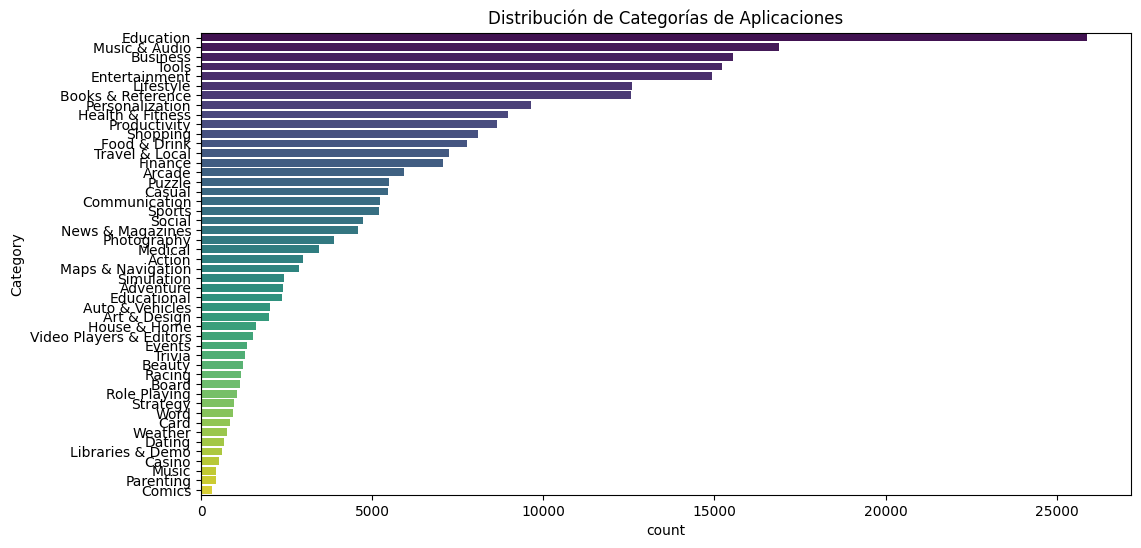

In [169]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_sample, y='Category', order=df_sample['Category'].value_counts().index, palette='viridis')
plt.title('Distribución de Categorías de Aplicaciones')

La cardinalidad es muy alta por lo que mapearemos las categorías a otras más generales.

Ambigüedad de "Sports": La categoría de app "Sports" de Google (para noticias deportivas, resultados, etc.) se mapea a SPORTS_APPS_INFO. La categoría "Sports" de la lista de géneros de juegos se mapearía a GAMES, separarlas es difícil y el efecto que esta ambigüedad tendrá en el clustering es bajo por lo que dejaré los juegos de deportes fuera de la categoría general GAMES.

In [170]:
unique_categories = df_sample['Category'].unique().tolist()
unique_categories.sort()
print("Lista de categorías únicas:")
for category in unique_categories:
  print(category)



Lista de categorías únicas:
Action
Adventure
Arcade
Art & Design
Auto & Vehicles
Beauty
Board
Books & Reference
Business
Card
Casino
Casual
Comics
Communication
Dating
Education
Educational
Entertainment
Events
Finance
Food & Drink
Health & Fitness
House & Home
Libraries & Demo
Lifestyle
Maps & Navigation
Medical
Music
Music & Audio
News & Magazines
Parenting
Personalization
Photography
Productivity
Puzzle
Racing
Role Playing
Shopping
Simulation
Social
Sports
Strategy
Tools
Travel & Local
Trivia
Video Players & Editors
Weather
Word


In [171]:
import pandas as pd

# --- 1. Datos Proporcionados y Extraídos ---
user_dataset_categories_list = unique_categories


#Fuente: https://support.google.com/googleplay/android-developer/answer/9859673?hl=en#zippy=%2Cgames%2Capps
google_official_game_categories_list = [ # Lista de Google para géneros de JUEGOS
    'Action', 'Adventure', 'Arcade', 'Board', 'Card', 'Casino', 'Casual', 'Educational',
    'Music', 'Puzzle', 'Racing', 'Role Playing', 'Simulation', 'Sports', 'Strategy',
    'Trivia', 'Word'
]

google_official_app_categories_raw = [
    'Art and Design', 'Auto and Vehicles', 'Beauty', 'Books and Reference', 'Business',
    'Comics', 'Communications', 'Dating', 'Education', 'Entertainment', 'Events',
    'Finance', 'Food and Drink', 'Health and Fitness', 'House and Home',
    'Libraries and Demo', 'Lifestyle', 'Maps and Navigation', 'Medical',
    'Music and Audio', 'News and Magazines', 'Parenting', 'Personalization',
    'Photography', 'Productivity', 'Shopping', 'Social', 'Sports', # Esta es la categoría APP de Google
    'Tools', 'Travel and Local', 'Video Players and Editors', 'Weather'
]


# Normalización y extracción de categorías de Google
def norm(s):
    s_str = str(s) # Asegurar que es un string
    s_replaced = s_str.replace('&', 'and') # Reemplazar '&' con 'and'
    return s_replaced.strip().lower()

# Conjuntos normalizados para búsqueda
user_dataset_categories_map = {norm(cat): cat for cat in user_dataset_categories_list}
google_game_categories_norm_set = {norm(cat) for cat in google_official_game_categories_list}
# google_official_app_categories_norm_map = {norm(cat): cat for cat in google_official_app_categories_raw} # Nombre original de Google

# --- 2. Definir Categorías Generales Amplias para Aplicaciones ---
# Este diccionario mapea las categorías de apps *oficiales de Google* (normalizadas)
# a nuestras categorías generales deseadas.
google_app_to_broad_map = {
    norm('Art and Design'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Auto and Vehicles'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Beauty'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Books and Reference'): 'INFORMATION_AND_REFERENCE',
    norm('Business'): 'PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS',
    norm('Comics'): 'MEDIA_AND_ENTERTAINMENT_APPS',
    norm('Communications'): 'COMMUNICATION_AND_SOCIAL', # Google usa "Communications"
    norm('Dating'): 'COMMUNICATION_AND_SOCIAL',
    norm('Education'): 'EDUCATION_APPS', # Categoría de App de Google
    norm('Entertainment'): 'MEDIA_AND_ENTERTAINMENT_APPS',
    norm('Events'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Finance'): 'PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS',
    norm('Food and Drink'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Health and Fitness'): 'HEALTH_MEDICAL_FITNESS',
    norm('House and Home'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Libraries and Demo'): 'PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS',
    norm('Lifestyle'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Maps and Navigation'): 'TRAVEL_MAPS_NAVIGATION_LOCAL',
    norm('Medical'): 'HEALTH_MEDICAL_FITNESS',
    norm('Music and Audio'): 'MEDIA_AND_ENTERTAINMENT_APPS',
    norm('News and Magazines'): 'INFORMATION_AND_REFERENCE',
    norm('Parenting'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Personalization'): 'LIFESTYLE_AND_CREATIVITY',
    norm('Photography'): 'MEDIA_AND_ENTERTAINMENT_APPS',
    norm('Productivity'): 'PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS',
    norm('Shopping'): 'LIFESTYLE_AND_CREATIVITY', # O 'SHOPPING_ECOMMERCE'
    norm('Social'): 'COMMUNICATION_AND_SOCIAL',
    norm('Sports'): 'SPORTS_APPS_INFO', # Categoría de App "Sports" de Google
    norm('Tools'): 'PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS',
    norm('Travel and Local'): 'TRAVEL_MAPS_NAVIGATION_LOCAL',
    norm('Video Players and Editors'): 'MEDIA_AND_ENTERTAINMENT_APPS',
    norm('Weather'): 'INFORMATION_AND_REFERENCE'
}

# --- 3. Mapear las Categorías del Dataset ---
final_category_mapping = {}
unmapped_for_review = []

for normalized_user_cat, original_user_cat_name in user_dataset_categories_map.items():
    # CASO ESPECIAL: "Sports" NO va a GAMES
    if normalized_user_cat == 'sports':
        final_category_mapping[original_user_cat_name] = 'SPORTS_APPS_INFO'
    # OTROS JUEGOS: Si es un género de juego oficial de Google (y no es "Sports")
    elif normalized_user_cat in google_game_categories_norm_set:
        final_category_mapping[original_user_cat_name] = 'GAMES'
    # APLICACIONES: Intentar mapear usando el `google_app_to_broad_map`
    elif normalized_user_cat in google_app_to_broad_map:
        final_category_mapping[original_user_cat_name] = google_app_to_broad_map[normalized_user_cat]
    # Manejo de variantes comunes o errores tipográficos menores
    elif normalized_user_cat == norm('Communication'): # El dataset tiene "Communication"
        final_category_mapping[original_user_cat_name] = 'COMMUNICATION_AND_SOCIAL'
    else:
        final_category_mapping[original_user_cat_name] = 'OTHER_APPS_MISC' # Fallback
        unmapped_for_review.append(original_user_cat_name)

if unmapped_for_review:
    print(f"ADVERTENCIA: Las siguientes categorías de tu dataset se mapearon a 'OTHER_APPS_MISC' y podrían necesitar revisión:")
    print(sorted(list(set(unmapped_for_review)))) # Mostrar únicos por si acaso
else:
    print("Todas las categorías de tu dataset se mapearon correctamente.")

Todas las categorías de tu dataset se mapearon correctamente.


In [172]:
df_sample['Category_General'] = df_sample['Category'].map(final_category_mapping)

print("\nConteo de las nuevas categorías generales propuestas:")
print(df_sample['Category_General'].value_counts().sort_index())


Conteo de las nuevas categorías generales propuestas:
Category_General
COMMUNICATION_AND_SOCIAL                   10653
EDUCATION_APPS                             25877
GAMES                                      35464
HEALTH_MEDICAL_FITNESS                     12415
INFORMATION_AND_REFERENCE                  17884
LIFESTYLE_AND_CREATIVITY                   46671
MEDIA_AND_ENTERTAINMENT_APPS               37526
PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS    47066
SPORTS_APPS_INFO                            5189
TRAVEL_MAPS_NAVIGATION_LOCAL               10122
Name: count, dtype: int64


<ipython-input-173-3dbf8cafc99c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sample, y='Category_General', order=df_sample['Category_General'].value_counts().index, palette='viridis')


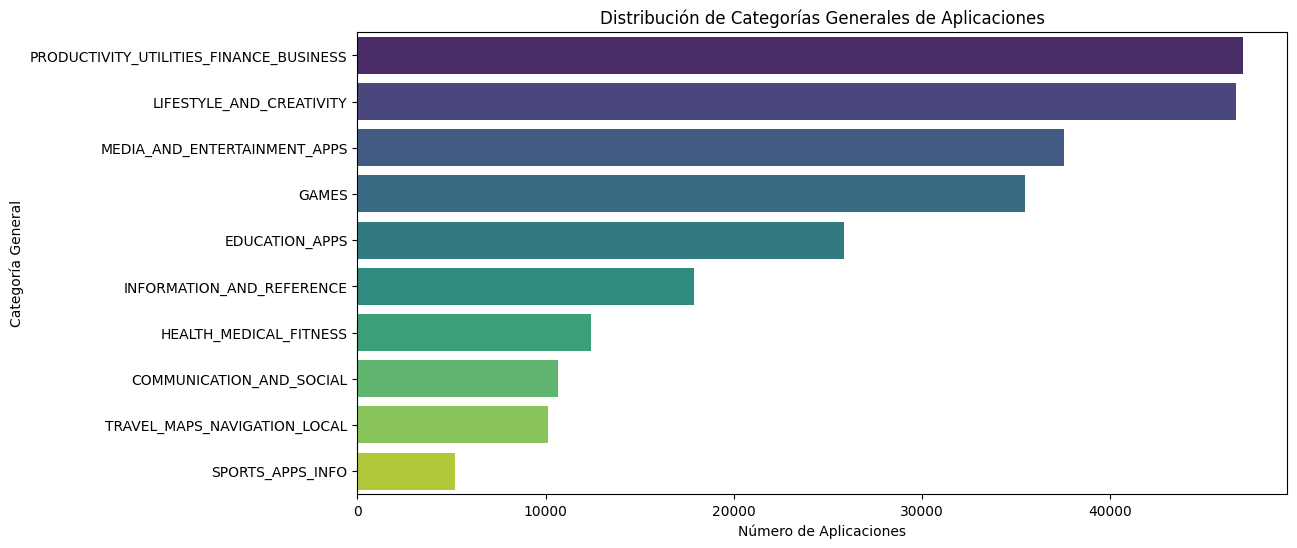

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.close('all')

plt.figure(figsize=(12, 6))
sns.countplot(data=df_sample, y='Category_General', order=df_sample['Category_General'].value_counts().index, palette='viridis')
plt.title('Distribución de Categorías Generales de Aplicaciones')
plt.xlabel('Número de Aplicaciones')
plt.ylabel('Categoría General')
plt.show()

# EDA

In [ ]:
print(df_sample.describe(include='all'))

## Correlaciones

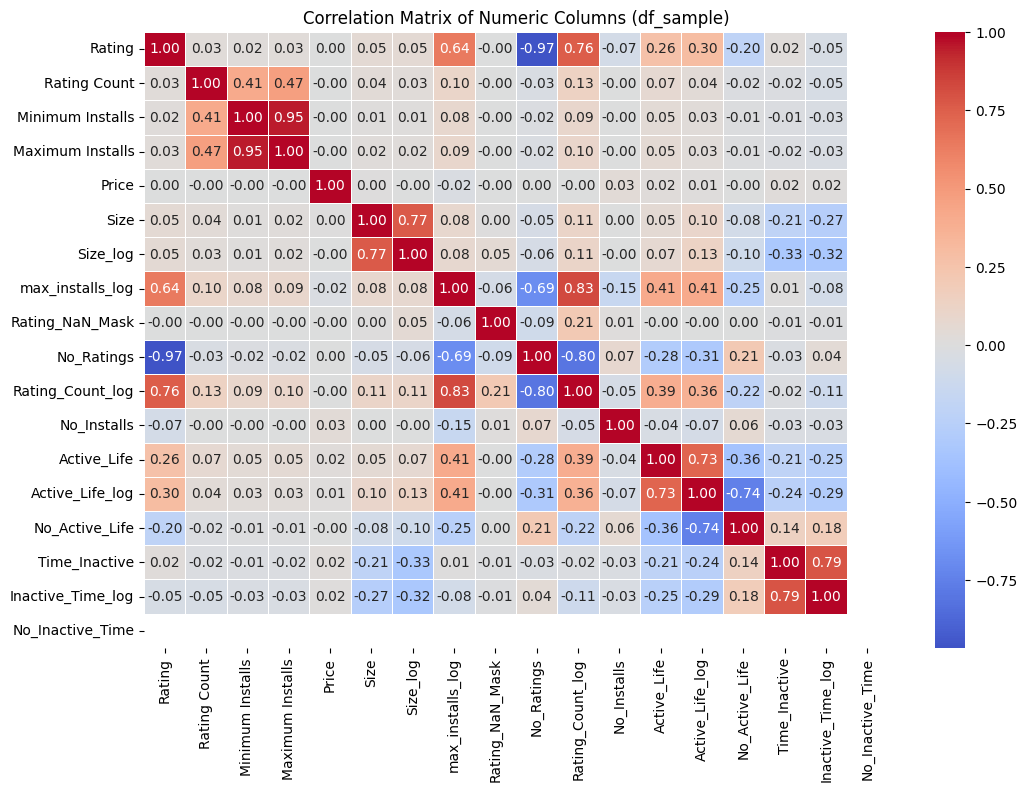

In [132]:
import seaborn as sns

import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = df_sample.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the correlation matrix with a color gradient
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Columns (df_sample)')
plt.show()


Meaningful correlations (absolute correlation >= 0.3):
           Variable_1         Variable_2  Correlation
37   Minimum Installs   Maximum Installs     0.946227
129  max_installs_log   Rating_Count_log     0.829115
271     Time_Inactive  Inactive_Time_log     0.790567
91               Size           Size_log     0.768952
10             Rating   Rating_Count_log     0.755033
217       Active_Life    Active_Life_log     0.727495
7              Rating   max_installs_log     0.643382
20       Rating Count   Maximum Installs     0.470303
19       Rating Count   Minimum Installs     0.413208
131  max_installs_log        Active_Life     0.412849
132  max_installs_log    Active_Life_log     0.412399
182  Rating_Count_log        Active_Life     0.392722
183  Rating_Count_log    Active_Life_log     0.363475
166        No_Ratings    Active_Life_log    -0.309950
118          Size_log  Inactive_Time_log    -0.322556
117          Size_log      Time_Inactive    -0.326208
218       Active_Life     

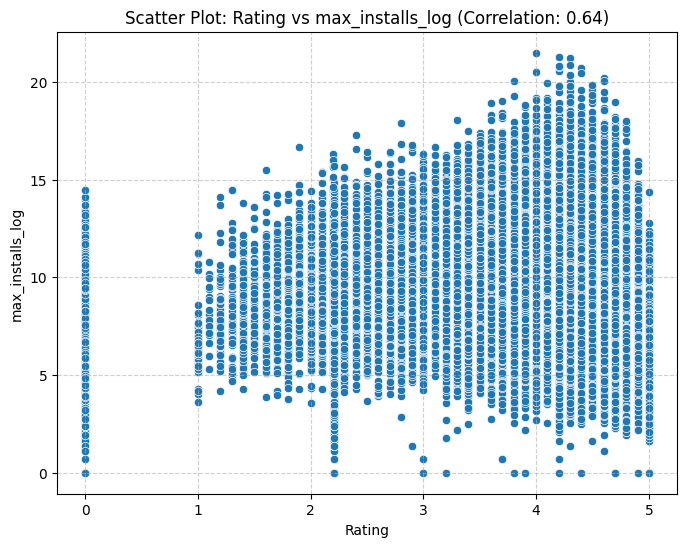

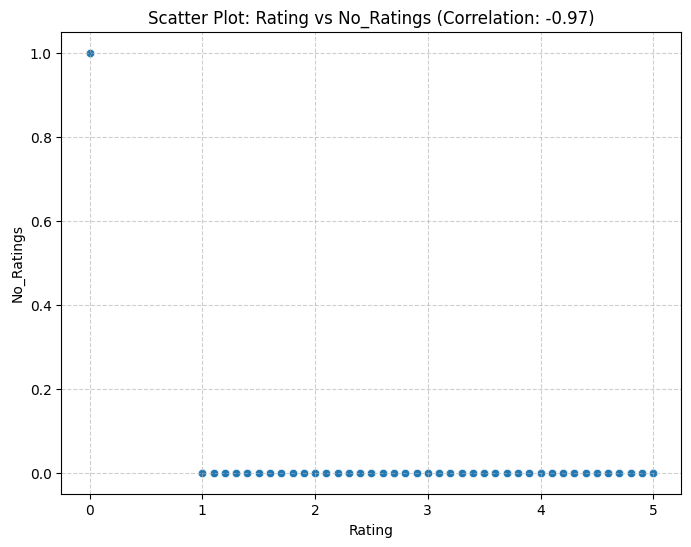

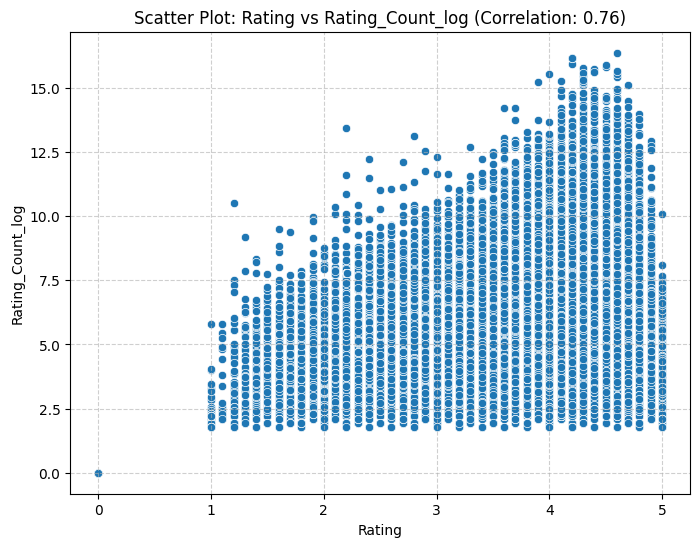

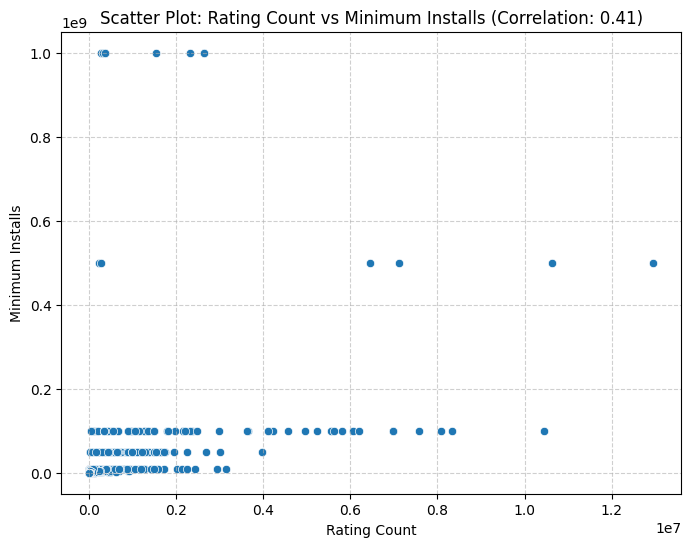

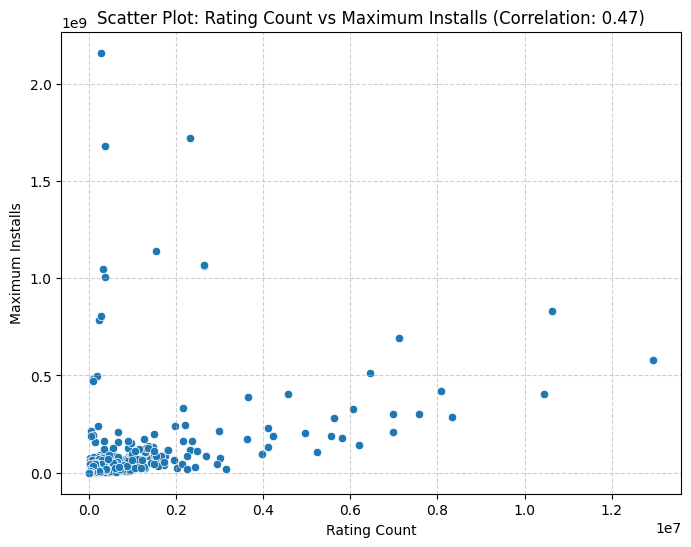

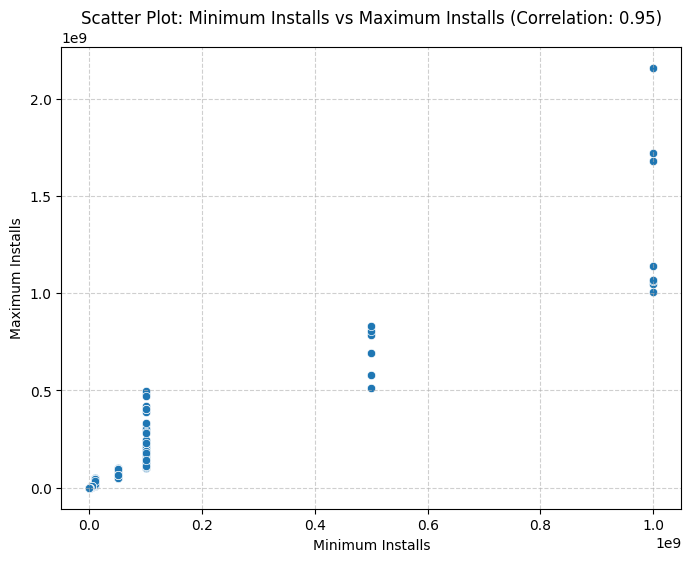

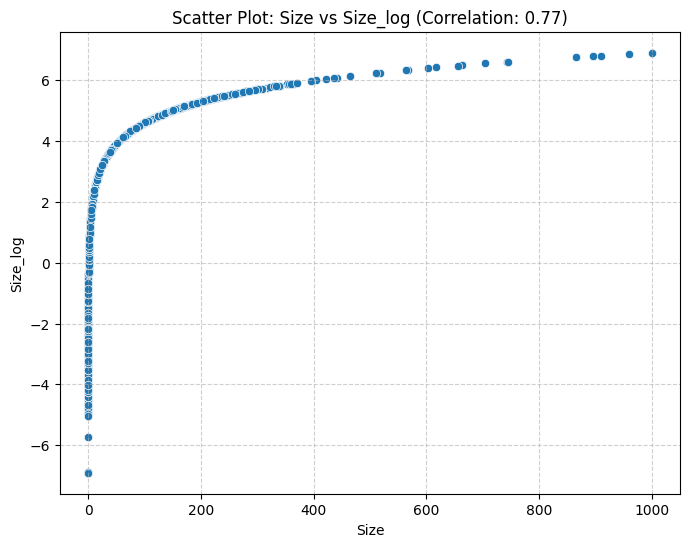

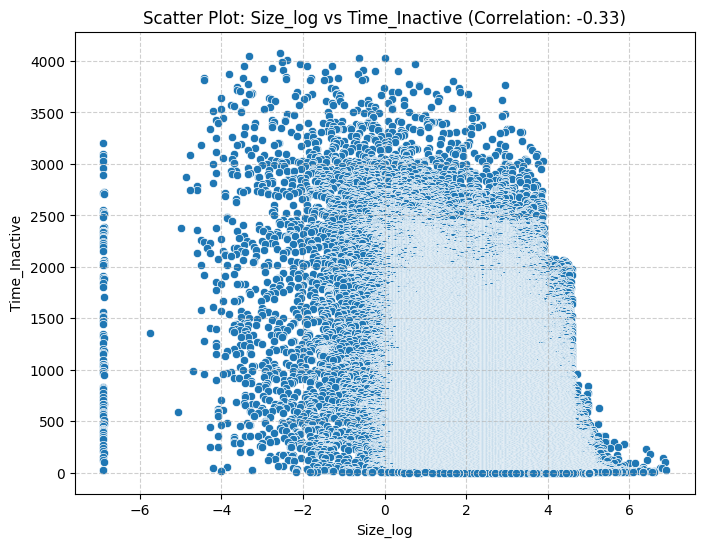

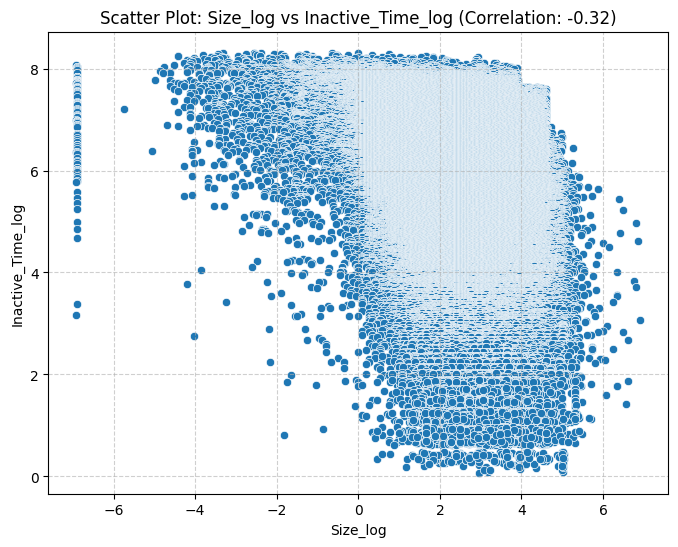

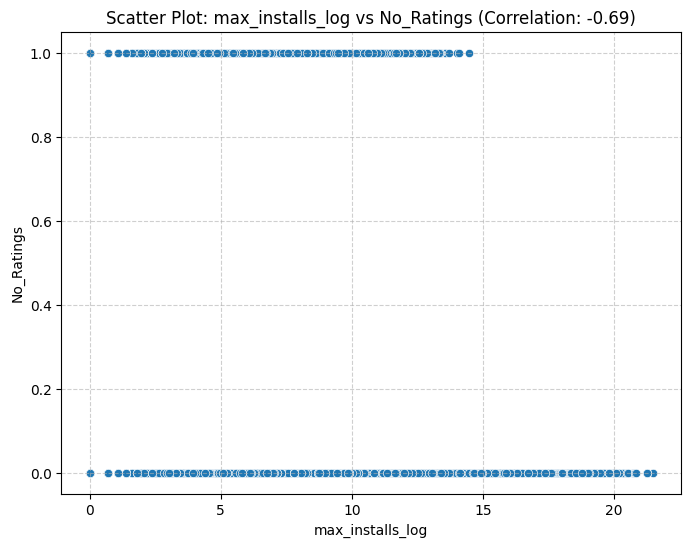

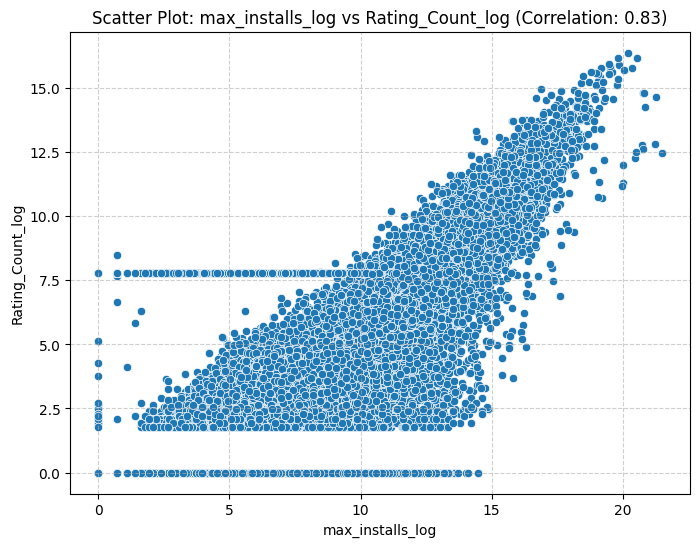

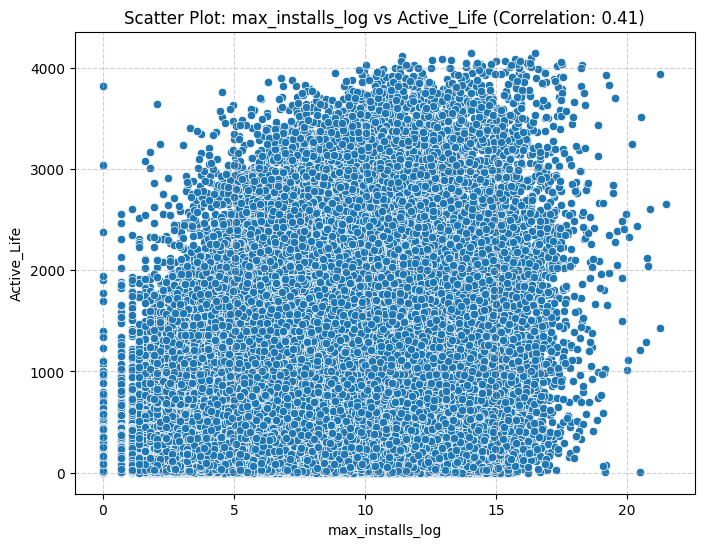

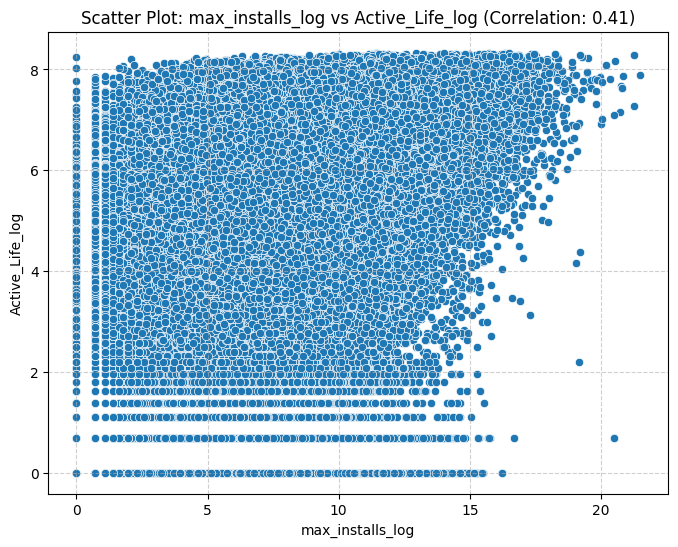

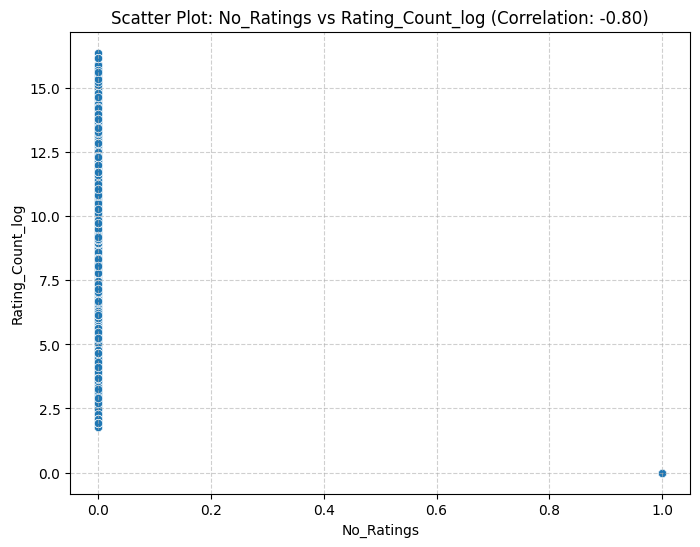

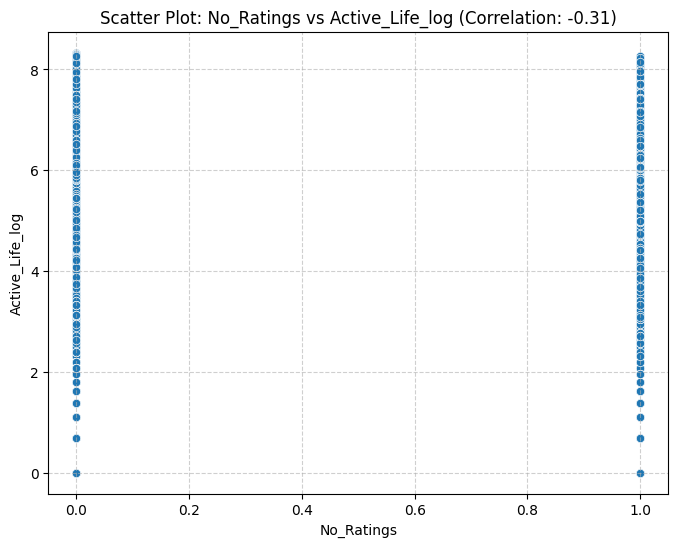

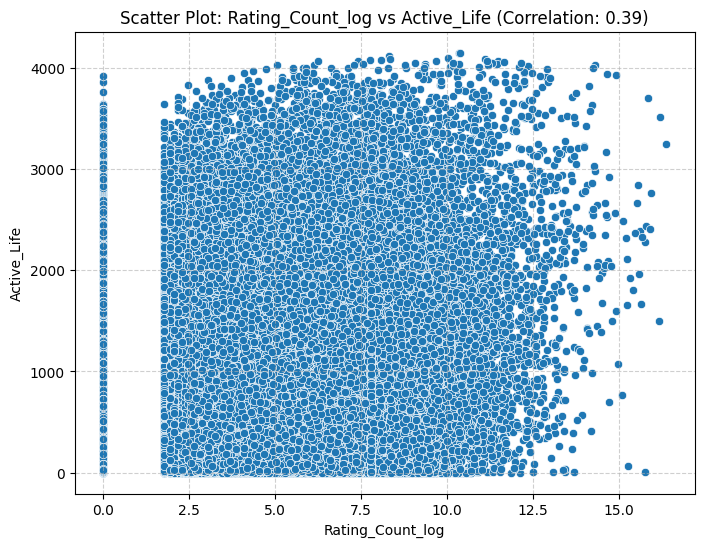

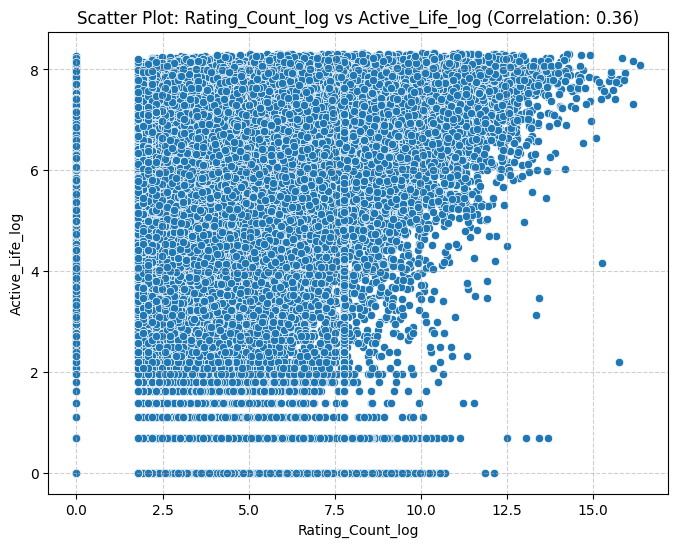

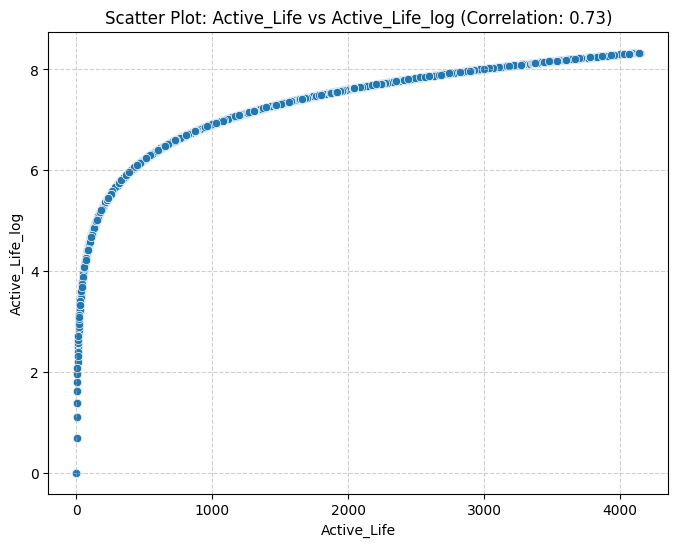

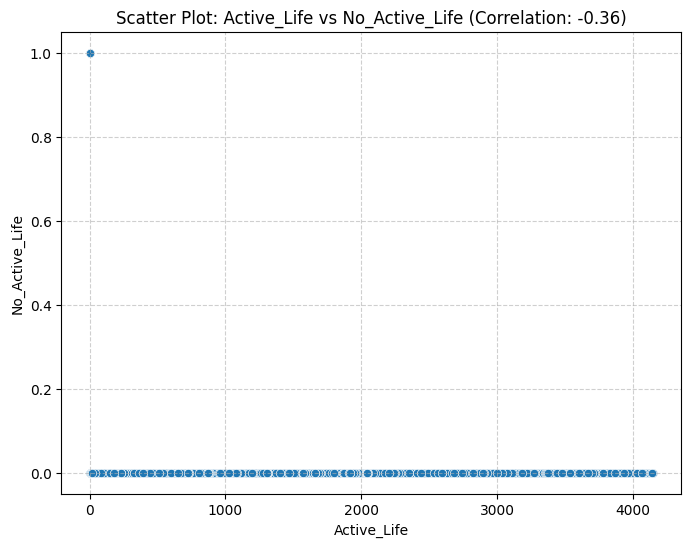

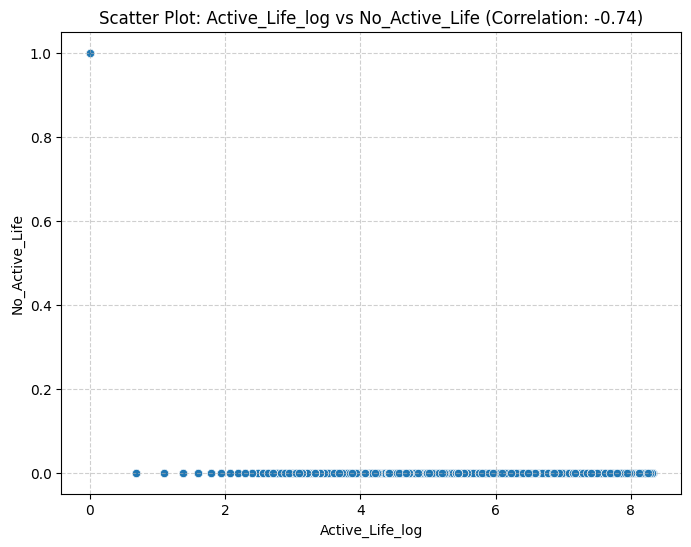

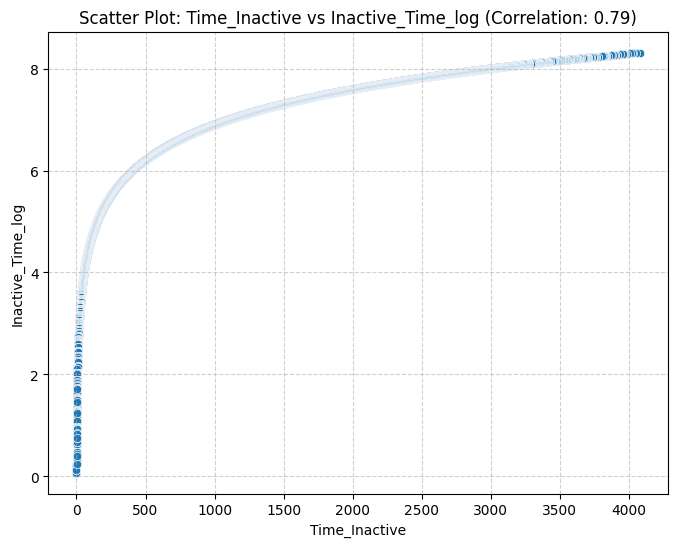

In [192]:
# prompt: Plot scatter plots for every meaningfull correlation found in the matrix

# Identify meaningful correlations (e.g., absolute correlation > a threshold, like 0.3 or 0.5)
# Let's use a threshold of 0.3 for demonstration
correlation_threshold = 0.3

# Stack the correlation matrix and remove self-correlations and duplicates
# Use .abs() to consider both positive and negative correlations
stacked_corr = corr_matrix.stack().reset_index()
stacked_corr.columns = ['Variable_1', 'Variable_2', 'Correlation']

# Remove self-correlations (where Variable_1 == Variable_2)
stacked_corr = stacked_corr[stacked_corr['Variable_1'] != stacked_corr['Variable_2']]

# Remove duplicate pairs (e.g., (A, B) and (B, A)). Keep only one.
# Sort the variable names in each pair and create a unique pair identifier
stacked_corr['pair'] = stacked_corr.apply(lambda row: tuple(sorted((row['Variable_1'], row['Variable_2']))), axis=1)
stacked_corr = stacked_corr.drop_duplicates(subset='pair').drop('pair', axis=1)

# Filter for correlations above the threshold (absolute value)
meaningful_correlations = stacked_corr[stacked_corr['Correlation'].abs() >= correlation_threshold]

print(f"\nMeaningful correlations (absolute correlation >= {correlation_threshold}):")
print(meaningful_correlations.sort_values(by='Correlation', ascending=False))

# Plot scatter plots for each meaningful correlation
for index, row in meaningful_correlations.iterrows():
    var1 = row['Variable_1']
    var2 = row['Variable_2']
    correlation_value = row['Correlation']

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_sample, x=var1, y=var2)

    plt.title(f'Scatter Plot: {var1} vs {var2} (Correlation: {correlation_value:.2f})')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Clean up memory after each plot
    plt.close('all')
    gc.collect()


## Tests de Hipótesis

### Hipótesis 1: Monetización y Adopción

H1: "Las aplicaciones gratuitas (Price = 0) que incluyen publicidad (Ad Supported = True) logran un número significativamente mayor de Maximum Installs en comparación con las aplicaciones de pago que no incluyen publicidad, especialmente en categorías de alto volumen como 'GAMES' o 'COMMUNICATION_AND_SOCIAL'."

--- Testeando Hipótesis 1: Monetización y Adopción ---
Tamaño Grupo A (Gratis con Ads): 123697
Tamaño Grupo B (Pago sin Ads): 4582

Comparación General:
Mediana de max_installs_log - Grupo A: 7.51
Mediana de max_installs_log - Grupo B: 5.58
Estadístico Mann-Whitney U: 380113639.50, P-valor: 0.0000
La diferencia en las medianas de log(instalaciones) es estadísticamente significativa.
Específicamente, el Grupo A (Gratis con Ads) tiende a tener más instalaciones (log).


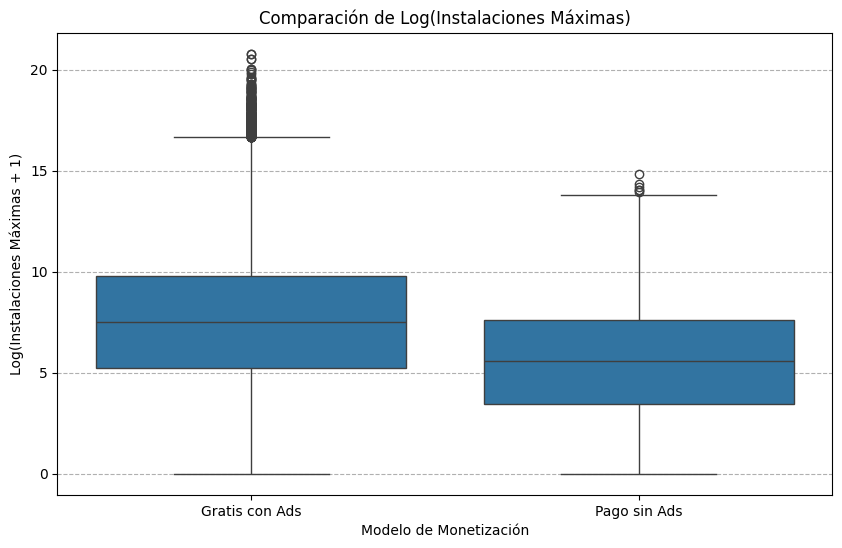


Análisis para la categoría: GAMES
Tamaño Grupo A en GAMES: 27469
Tamaño Grupo B en GAMES: 820
Mediana de max_installs_log - Grupo A (GAMES): 7.58
Mediana de max_installs_log - Grupo B (GAMES): 7.11
Estadístico Mann-Whitney U (GAMES): 12669708.00, P-valor: 0.0000
En 'GAMES', la diferencia en medianas de log(instalaciones) es significativa.
Específicamente, en 'GAMES', el Grupo A tiende a tener más instalaciones (log).

Análisis para la categoría: COMMUNICATION_AND_SOCIAL
Tamaño Grupo A en COMMUNICATION_AND_SOCIAL: 4083
Tamaño Grupo B en COMMUNICATION_AND_SOCIAL: 64
Mediana de max_installs_log - Grupo A (COMMUNICATION_AND_SOCIAL): 7.70
Mediana de max_installs_log - Grupo B (COMMUNICATION_AND_SOCIAL): 5.58
Estadístico Mann-Whitney U (COMMUNICATION_AND_SOCIAL): 182780.50, P-valor: 0.0000
En 'COMMUNICATION_AND_SOCIAL', la diferencia en medianas de log(instalaciones) es significativa.
Específicamente, en 'COMMUNICATION_AND_SOCIAL', el Grupo A tiende a tener más instalaciones (log).
--- Fin 

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


print("--- Testeando Hipótesis 1: Monetización y Adopción ---")

# 1. Crear los grupos
grupo_A = df_sample[(df_sample['Price'] == 0) & (df_sample['Ad Supported'] == True)]
grupo_B = df_sample[(df_sample['Price'] > 0) & (df_sample['Ad Supported'] == False)]

print(f"Tamaño Grupo A (Gratis con Ads): {len(grupo_A)}")
print(f"Tamaño Grupo B (Pago sin Ads): {len(grupo_B)}")

if len(grupo_A) > 1 and len(grupo_B) > 1:
    # 2. Comparar usando max_installs_log para la prueba estadística debido a la posible asimetría
    # de Maximum Installs. Para visualización, podemos usar la escala original o log.

    # 3. Prueba estadística (Mann-Whitney U)
    # Compara si la distribución de una muestra es mayor/menor que la otra (mediana)
    # H0: Las medianas son iguales
    # H1: Las medianas son diferentes
    stat_total, p_value_total = mannwhitneyu(grupo_A['max_installs_log'], grupo_B['max_installs_log'], alternative='two-sided')
    print(f"\nComparación General:")
    print(f"Mediana de max_installs_log - Grupo A: {grupo_A['max_installs_log'].median():.2f}")
    print(f"Mediana de max_installs_log - Grupo B: {grupo_B['max_installs_log'].median():.2f}")
    print(f"Estadístico Mann-Whitney U: {stat_total:.2f}, P-valor: {p_value_total:.4f}")
    if p_value_total < 0.05:
        print("La diferencia en las medianas de log(instalaciones) es estadísticamente significativa.")
        # Para ver si el Grupo A es mayor:
        stat_greater, p_value_greater = mannwhitneyu(grupo_A['max_installs_log'], grupo_B['max_installs_log'], alternative='greater')
        if p_value_greater < 0.05:
            print("Específicamente, el Grupo A (Gratis con Ads) tiende a tener más instalaciones (log).")
        else:
            # Podría ser que el Grupo B sea mayor o la diferencia no sea direccional clara con este test
             stat_less, p_value_less = mannwhitneyu(grupo_A['max_installs_log'], grupo_B['max_installs_log'], alternative='less')
             if p_value_less < 0.05:
                  print("Específicamente, el Grupo B (Pago sin Ads) tiende a tener más instalaciones (log).")
    else:
        print("No hay una diferencia estadísticamente significativa en las medianas de log(instalaciones).")

    # 4. Visualización (usando escala log para el eje y para mejor visualización de distribuciones sesgadas)
    plt.figure(figsize=(10, 6))
    # Creamos un DataFrame temporal para facilitar la visualización con seaborn
    df_plot_h1 = pd.concat([
        grupo_A[['max_installs_log']].assign(Tipo='Gratis con Ads'),
        grupo_B[['max_installs_log']].assign(Tipo='Pago sin Ads')
    ])
    sns.boxplot(x='Tipo', y='max_installs_log', data=df_plot_h1)
    plt.title('Comparación de Log(Instalaciones Máximas)')
    plt.ylabel('Log(Instalaciones Máximas + 1)')
    plt.xlabel('Modelo de Monetización')
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # 5. Análisis por categorías de alto volumen
    high_volume_categories = ['GAMES', 'COMMUNICATION_AND_SOCIAL'] # Ajusta según tus Category_General
    for category in high_volume_categories:
        print(f"\nAnálisis para la categoría: {category}")
        grupo_A_cat = grupo_A[grupo_A['Category_General'] == category]
        grupo_B_cat = grupo_B[grupo_B['Category_General'] == category]

        print(f"Tamaño Grupo A en {category}: {len(grupo_A_cat)}")
        print(f"Tamaño Grupo B en {category}: {len(grupo_B_cat)}")

        if len(grupo_A_cat) > 1 and len(grupo_B_cat) > 1:
            stat_cat, p_value_cat = mannwhitneyu(grupo_A_cat['max_installs_log'], grupo_B_cat['max_installs_log'], alternative='two-sided')
            print(f"Mediana de max_installs_log - Grupo A ({category}): {grupo_A_cat['max_installs_log'].median():.2f}")
            print(f"Mediana de max_installs_log - Grupo B ({category}): {grupo_B_cat['max_installs_log'].median():.2f}")
            print(f"Estadístico Mann-Whitney U ({category}): {stat_cat:.2f}, P-valor: {p_value_cat:.4f}")
            if p_value_cat < 0.05:
                print(f"En '{category}', la diferencia en medianas de log(instalaciones) es significativa.")
                stat_cat_greater, p_cat_greater = mannwhitneyu(grupo_A_cat['max_installs_log'], grupo_B_cat['max_installs_log'], alternative='greater')
                if p_cat_greater < 0.05:
                     print(f"Específicamente, en '{category}', el Grupo A tiende a tener más instalaciones (log).")

            else:
                print(f"En '{category}', no hay diferencia significativa en medianas de log(instalaciones).")
        else:
            print(f"No hay suficientes datos en uno o ambos grupos para la categoría '{category}' para realizar la comparación.")
else:
    print("No hay suficientes datos en uno o ambos grupos principales (A o B) para realizar la comparación.")
print("--- Fin Test Hipótesis 1 ---")

Conclusión: El Grupo A (Gratis con Ads) tiene más Installs que el B (Pago sin Ads), pero la categoría no parece afectar.

### Hipótesis 2: Calidad Percibida y Popularidad

H2: "Un Rating promedio más alto se correlaciona positivamente y de forma significativa con un mayor Rating_Count_log (número de valoraciones, proxy de compromiso/popularidad) y con Maximum Installs (o max_installs_log), sugiriendo que la calidad percibida es un motor clave para la adopción y el engagement."


--- Testeando Hipótesis 2: Calidad Percibida y Popularidad ---

Correlación Spearman entre Rating y Rating_Count_log:
Coeficiente: 0.7920, P-valor: 0.0000
La correlación es estadísticamente significativa.

Correlación Spearman entre Rating y max_installs_log:
Coeficiente: 0.5933, P-valor: 0.0000
La correlación es estadísticamente significativa.


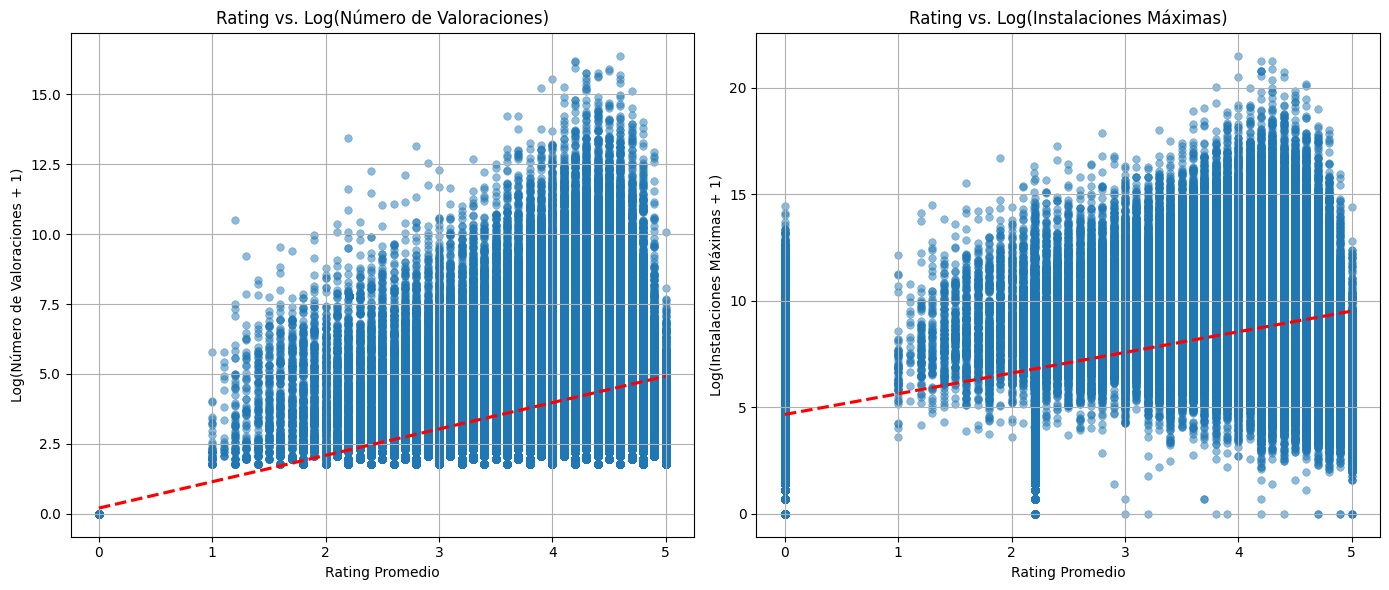

--- Fin Test Hipótesis 2 ---


In [196]:
from scipy.stats import spearmanr

print("\n--- Testeando Hipótesis 2: Calidad Percibida y Popularidad ---")

# Asegurarse de que no haya NaNs en las columnas relevantes para la correlación
df_h2 = df_sample[['Rating', 'Rating_Count_log', 'max_installs_log']].dropna()

if len(df_h2) > 20: # Necesitamos suficientes puntos para una correlación significativa
    # 1. Correlación Rating vs. Rating_Count_log
    corr_rating_counts, p_value_rc = spearmanr(df_h2['Rating'], df_h2['Rating_Count_log'])
    print(f"\nCorrelación Spearman entre Rating y Rating_Count_log:")
    print(f"Coeficiente: {corr_rating_counts:.4f}, P-valor: {p_value_rc:.4f}")
    if p_value_rc < 0.05:
        print("La correlación es estadísticamente significativa.")
    else:
        print("La correlación no es estadísticamente significativa.")

    # 2. Correlación Rating vs. max_installs_log
    corr_rating_installs, p_value_ri = spearmanr(df_h2['Rating'], df_h2['max_installs_log'])
    print(f"\nCorrelación Spearman entre Rating y max_installs_log:")
    print(f"Coeficiente: {corr_rating_installs:.4f}, P-valor: {p_value_ri:.4f}")
    if p_value_ri < 0.05:
        print("La correlación es estadísticamente significativa.")
    else:
        print("La correlación no es estadísticamente significativa.")

    # 3. Visualizaciones
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='Rating', y='Rating_Count_log', data=df_h2, alpha=0.5, s=30, edgecolor=None)
    # Añadir línea de regresión (opcional, puede ser no lineal)
    sns.regplot(x='Rating', y='Rating_Count_log', data=df_h2, scatter=False, color='red', line_kws={'linestyle':'--'})
    plt.title('Rating vs. Log(Número de Valoraciones)')
    plt.xlabel('Rating Promedio')
    plt.ylabel('Log(Número de Valoraciones + 1)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Rating', y='max_installs_log', data=df_h2, alpha=0.5, s=30, edgecolor=None)
    sns.regplot(x='Rating', y='max_installs_log', data=df_h2, scatter=False, color='red', line_kws={'linestyle':'--'})
    plt.title('Rating vs. Log(Instalaciones Máximas)')
    plt.xlabel('Rating Promedio')
    plt.ylabel('Log(Instalaciones Máximas + 1)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes datos después de eliminar NaNs para testear la Hipótesis 2.")
print("--- Fin Test Hipótesis 2 ---")

Conclusión: La hipótesis no es rechazada.

### Hipótesis 3: Categorías y Oportunidades de Mercado (Tolerancia al Precio)

H3: "Ciertas Category_General (por ejemplo, 'PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS' o 'EDUCATION_APPS') muestran una mayor tolerancia a precios (Price > 0) sin una caída drástica en Maximum Installs, en comparación con categorías más saturadas o de entretenimiento ('GAMES', 'MEDIA_AND_ENTERTAINMENT_APPS') donde se espera gratuidad."


--- Testeando Hipótesis 3: Categorías y Tolerancia al Precio ---
Número de aplicaciones de pago para análisis: 4844


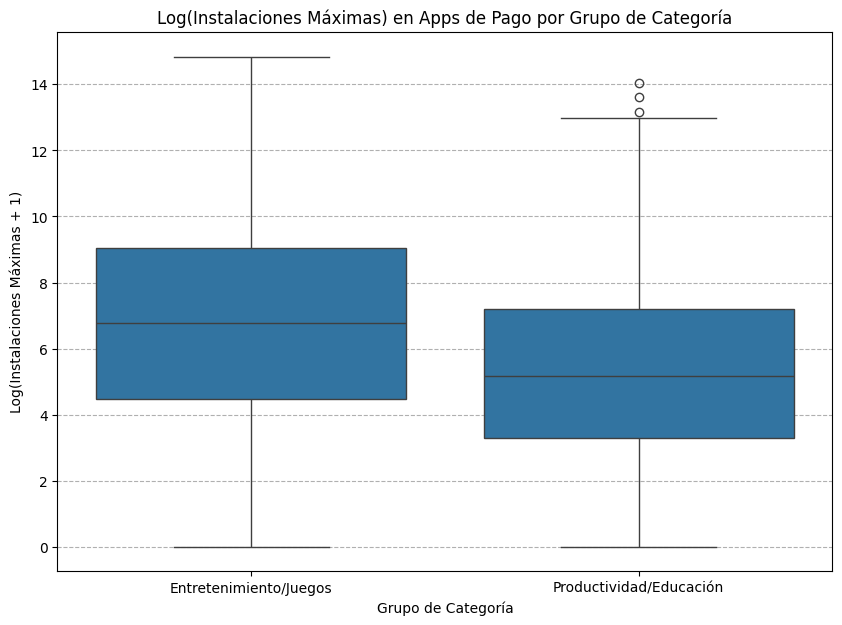


Comparando medianas de log(instalaciones) entre 'Productividad/Educación' y 'Entretenimiento/Juegos' (solo apps de pago):
Mediana Productividad/Educación: 5.16 (N=1469)
Mediana Entretenimiento/Juegos: 6.77 (N=1342)
Estadístico Mann-Whitney U: 722862.50, P-valor: 0.0000
La diferencia en medianas de log(instalaciones) entre estos grupos de categorías es estadísticamente significativa.
Específicamente, el grupo 'Productividad/Educación' tiende a tener MENOS instalaciones (log) que 'Entretenimiento/Juegos' entre las apps de pago.
--- Fin Test Hipótesis 3 ---


In [197]:
from scipy.stats import kruskal

print("\n--- Testeando Hipótesis 3: Categorías y Tolerancia al Precio ---")

# 1. Filtrar apps de pago
df_paid_apps = df_sample[df_sample['Price'] > 0].copy() # Usar .copy() para evitar SettingWithCopyWarning

if not df_paid_apps.empty:
    print(f"Número de aplicaciones de pago para análisis: {len(df_paid_apps)}")

    # 2. Definir grupos de categorías
    # Ajusta estas listas según tus Category_General y lo que quieras comparar
    cat_grupo_productividad_educacion = ['PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS', 'EDUCATION_APPS']
    cat_grupo_entretenimiento_juegos = ['GAMES', 'MEDIA_AND_ENTERTAINMENT_APPS'] # Ajusta MEDIA_AND_ENTERTAINMENT_APPS si ese es tu nombre

    # Crear una columna para el grupo de categoría para facilitar el análisis
    def asignar_grupo_h3(categoria):
        if categoria in cat_grupo_productividad_educacion:
            return 'Productividad/Educación'
        elif categoria in cat_grupo_entretenimiento_juegos:
            return 'Entretenimiento/Juegos'
        else:
            return 'Otras Categorías de Pago' # O None si quieres excluirlas

    df_paid_apps['Grupo_H3'] = df_paid_apps['Category_General'].apply(asignar_grupo_h3)

    # Filtrar para solo los grupos de interés si no quieres "Otras"
    df_paid_apps_filtrado_h3 = df_paid_apps[df_paid_apps['Grupo_H3'].isin(['Productividad/Educación', 'Entretenimiento/Juegos'])]

    if len(df_paid_apps_filtrado_h3['Grupo_H3'].unique()) > 1 and df_paid_apps_filtrado_h3.groupby('Grupo_H3').size().min() > 1:
        # 3. Visualización
        plt.figure(figsize=(10, 7))
        sns.boxplot(x='Grupo_H3', y='max_installs_log', data=df_paid_apps_filtrado_h3)
        plt.title('Log(Instalaciones Máximas) en Apps de Pago por Grupo de Categoría')
        plt.ylabel('Log(Instalaciones Máximas + 1)')
        plt.xlabel('Grupo de Categoría')
        plt.grid(axis='y', linestyle='--')
        plt.show()

        # 4. Prueba estadística (Kruskal-Wallis para >2 grupos, o Mann-Whitney U para 2)
        # Aquí comparamos los dos grupos definidos
        grupo_prod_edu = df_paid_apps_filtrado_h3[df_paid_apps_filtrado_h3['Grupo_H3'] == 'Productividad/Educación']['max_installs_log'].dropna()
        grupo_ent_juegos = df_paid_apps_filtrado_h3[df_paid_apps_filtrado_h3['Grupo_H3'] == 'Entretenimiento/Juegos']['max_installs_log'].dropna()

        if len(grupo_prod_edu) > 1 and len(grupo_ent_juegos) > 1:
            print("\nComparando medianas de log(instalaciones) entre 'Productividad/Educación' y 'Entretenimiento/Juegos' (solo apps de pago):")
            print(f"Mediana Productividad/Educación: {grupo_prod_edu.median():.2f} (N={len(grupo_prod_edu)})")
            print(f"Mediana Entretenimiento/Juegos: {grupo_ent_juegos.median():.2f} (N={len(grupo_ent_juegos)})")

            stat_h3, p_value_h3 = mannwhitneyu(grupo_prod_edu, grupo_ent_juegos, alternative='two-sided')
            print(f"Estadístico Mann-Whitney U: {stat_h3:.2f}, P-valor: {p_value_h3:.4f}")
            if p_value_h3 < 0.05:
                print("La diferencia en medianas de log(instalaciones) entre estos grupos de categorías es estadísticamente significativa.")
                # Podrías hacer un test 'greater' para ver si Productividad/Educación tiene más
                stat_h3_greater, p_value_h3_greater = mannwhitneyu(grupo_prod_edu, grupo_ent_juegos, alternative='greater')
                if p_value_h3_greater < 0.05:
                    print("Específicamente, el grupo 'Productividad/Educación' tiende a tener MÁS instalaciones (log) que 'Entretenimiento/Juegos' entre las apps de pago.")
                else: # Chequear si es menor
                    stat_h3_less, p_value_h3_less = mannwhitneyu(grupo_prod_edu, grupo_ent_juegos, alternative='less')
                    if p_value_h3_less < 0.05:
                         print("Específicamente, el grupo 'Productividad/Educación' tiende a tener MENOS instalaciones (log) que 'Entretenimiento/Juegos' entre las apps de pago.")

            else:
                print("No hay diferencia significativa en medianas de log(instalaciones) entre estos grupos de categorías para apps de pago.")
        else:
            print("No hay suficientes datos en uno de los grupos de categorías de pago para la prueba estadística.")
    else:
        print("No se formaron al menos dos grupos de categorías con suficientes datos para la comparación de apps de pago.")
else:
    print("No hay aplicaciones de pago en el dataset para testear la Hipótesis 3.")
print("--- Fin Test Hipótesis 3 ---")

Conclusión: Nuestra hipótesis parece ser falsa.

### Hipótesis 4: Características de la App y Retención/Satisfacción

H4: "Un Active_Life_log más prolongado (indicando actualizaciones recientes y mantenimiento continuo) se asocia con Ratings más altos Y un Inactive_Time_log menor, lo que sugiere que el soporte y la evolución de la app son cruciales para la satisfacción y retención del usuario."


--- Testeando Hipótesis 4: Ciclo de Vida de la App y Satisfacción ---

Correlación Spearman entre Active_Life_log y Rating:
Coeficiente: 0.2669, P-valor: 0.0000
La correlación positiva es estadísticamente significativa: a mayor vida activa (log), mayor rating.

Correlación Spearman entre Active_Life_log e Inactive_Time_log:
Coeficiente: -0.2830, P-valor: 0.0000
La correlación negativa es estadísticamente significativa: a mayor vida activa (log), menor tiempo inactivo (log).


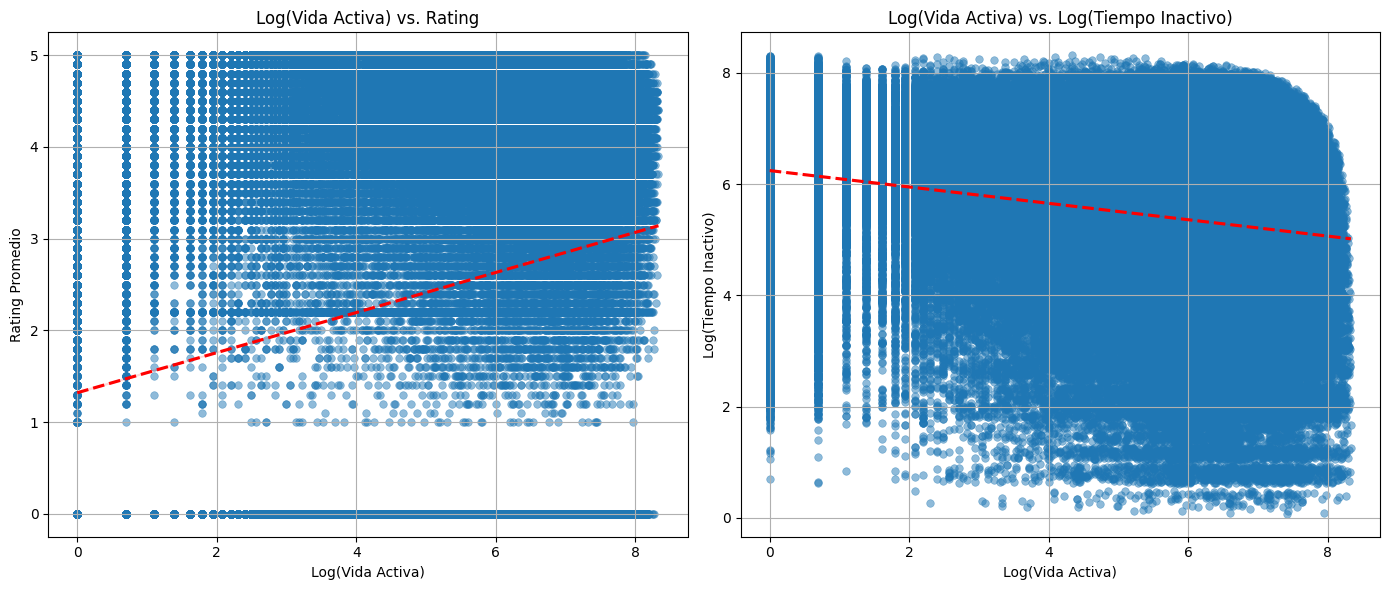

--- Fin Test Hipótesis 4 ---


In [198]:
print("\n--- Testeando Hipótesis 4: Ciclo de Vida de la App y Satisfacción ---")

# Asegurarse de que no haya NaNs
df_h4 = df_sample[['Active_Life_log', 'Rating', 'Inactive_Time_log']].dropna()

if len(df_h4) > 20:
    # 1. Correlación Active_Life_log vs. Rating
    corr_al_rating, p_value_alr = spearmanr(df_h4['Active_Life_log'], df_h4['Rating'])
    print(f"\nCorrelación Spearman entre Active_Life_log y Rating:")
    print(f"Coeficiente: {corr_al_rating:.4f}, P-valor: {p_value_alr:.4f}")
    if p_value_alr < 0.05 and corr_al_rating > 0: # Esperamos correlación positiva
        print("La correlación positiva es estadísticamente significativa: a mayor vida activa (log), mayor rating.")
    elif p_value_alr < 0.05 and corr_al_rating < 0:
        print("La correlación negativa es estadísticamente significativa (inesperado para esta parte de la hipótesis).")
    else:
        print("La correlación no es estadísticamente significativa.")

    # 2. Correlación Active_Life_log vs. Inactive_Time_log
    # Esperamos una correlación negativa si ambas se derivan de 'Last Updated' y la fecha actual.
    corr_al_it, p_value_alit = spearmanr(df_h4['Active_Life_log'], df_h4['Inactive_Time_log'])
    print(f"\nCorrelación Spearman entre Active_Life_log e Inactive_Time_log:")
    print(f"Coeficiente: {corr_al_it:.4f}, P-valor: {p_value_alit:.4f}")
    if p_value_alit < 0.05 and corr_al_it < 0: # Esperamos correlación negativa
        print("La correlación negativa es estadísticamente significativa: a mayor vida activa (log), menor tiempo inactivo (log).")
    elif p_value_alit < 0.05 and corr_al_it > 0:
         print("La correlación positiva es estadísticamente significativa (inesperado si ambas miden aspectos opuestos del ciclo de vida).")
    else:
        print("La correlación no es estadísticamente significativa.")


    # 3. Visualizaciones
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x='Active_Life_log', y='Rating', data=df_h4, alpha=0.5, s=30, edgecolor=None)
    sns.regplot(x='Active_Life_log', y='Rating', data=df_h4, scatter=False, color='red', line_kws={'linestyle':'--'})
    plt.title('Log(Vida Activa) vs. Rating')
    plt.xlabel('Log(Vida Activa)')
    plt.ylabel('Rating Promedio')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Active_Life_log', y='Inactive_Time_log', data=df_h4, alpha=0.5, s=30, edgecolor=None)
    sns.regplot(x='Active_Life_log', y='Inactive_Time_log', data=df_h4, scatter=False, color='red', line_kws={'linestyle':'--'})
    plt.title('Log(Vida Activa) vs. Log(Tiempo Inactivo)')
    plt.xlabel('Log(Vida Activa)')
    plt.ylabel('Log(Tiempo Inactivo)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes datos después de eliminar NaNs para testear la Hipótesis 4.")
print("--- Fin Test Hipótesis 4 ---")

Conclusión: Ambas relaciones son significativas por lo que la hipótesis se valida.

## K-Means

In [154]:
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gc


# 1. Identificar variables numéricas y categóricas
# Excluir variables que no son útiles para clustering o ya fueron procesadas/transformadas
# Asegúrate de ajustar esta lista según las variables finales que quieras usar
numerical_features = ['Size_log', 'Rating', 'Rating_Count_log', 'max_installs_log', 'Price', 'Active_Life_log', 'Inactive_Time_log','Min_Age']
# 'Category' es la variable categórica que nos preocupa por su cardinalidad
categorical_features = ['Category_General', 'Ad Supported','In App Purchases']

# Asegúrate de que las columnas existan en df_sample
numerical_features = [col for col in numerical_features if col in df_sample.columns]
categorical_features = [col for col in categorical_features if col in df_sample.columns]

print(f"Variables numéricas para clustering: {numerical_features}")
print(f"Variables categóricas para clustering: {categorical_features}")

# Estrategia de preprocesamiento:
# - Escalar variables numéricas
# - Manejar variables categóricas

# One-Hot Encoding para todas las categóricas y RobustScaler para las numéricas por la precencia de outliers.
preprocessor_onehot = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)



Variables numéricas para clustering: ['Size_log', 'Rating', 'Rating_Count_log', 'max_installs_log', 'Price', 'Active_Life_log', 'Inactive_Time_log']
Variables categóricas para clustering: ['Ad Supported', 'In App Purchases']


In [140]:
# Crear el pipeline: preprocesamiento + K-Means
# Vamos a probar diferentes números de clusters (k)
for col in numerical_features:
  print(f"NaN count in '{col}': {df_sample[col].isna().sum()}")
for col in categorical_features:
  print(f"NaN count in '{col}': {df_sample[col].isna().sum()}")

# Rango de k a probar
k_range = range(2, 7) # Por ejemplo, de 2 a 10 clusters

# Listas para almacenar los resultados del método del codo y silueta
sse = [] # Sum of squared errors (for elbow method)
silhouette_scores = []

print("\nEntrenando K-Means para diferentes valores de k...")

preprocessor = preprocessor_onehot

for k in k_range:
    print(f"Probando k = {k}...")
    # Crear el pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('cluster', KMeans(n_clusters=k, random_state=42, n_init=10))]) # n_init para robustez

    # Entrenar el pipeline (preprocesar y luego clusterear)
    pipeline.fit(df_sample)

    # Obtener la suma de cuadrados dentro de los clusters (Inertia) para el método del codo
    sse.append(pipeline['cluster'].inertia_)

    # Calcular el coeficiente de silueta (requiere al menos 2 clusters)
    if k > 1:
        # Obtener los datos preprocesados
        X_preprocessed = pipeline['preprocessor'].transform(df_sample)

        # Obtener las etiquetas de los clusters
        labels = pipeline['cluster'].labels_
        # Calcular el score de silueta. Manejar si hay un solo cluster (debería ser handled por k > 1)
        # y si hay solo un punto (handled por el algoritmo/score func)
        if len(np.unique(labels)) > 1 and X_preprocessed.shape[0] > 1:
             silhouette_avg = silhouette_score(X_preprocessed, labels)
             silhouette_scores.append(silhouette_avg)
        else:
             silhouette_scores.append(-1) # Indicador de que no se pudo calcular
             print(f"Advertencia: No se pudo calcular el score de silueta para k={k} (quizás solo 1 cluster o muy pocas muestras).")

    # Liberar memoria
    del pipeline
    del X_preprocessed
    del labels
    gc.collect()

print("Entrenamiento de K-Means completado.")


NaN count in 'Size_log': 0
NaN count in 'Rating': 0
NaN count in 'Rating_Count_log': 0
NaN count in 'max_installs_log': 0
NaN count in 'Price': 0
NaN count in 'Active_Life_log': 0
NaN count in 'Inactive_Time_log': 0
NaN count in 'Ad Supported': 0
NaN count in 'In App Purchases': 0

Entrenando K-Means para diferentes valores de k...
Probando k = 2...
Probando k = 3...
Probando k = 4...
Probando k = 5...
Probando k = 6...
Probando k = 7...
Entrenamiento de K-Means completado.


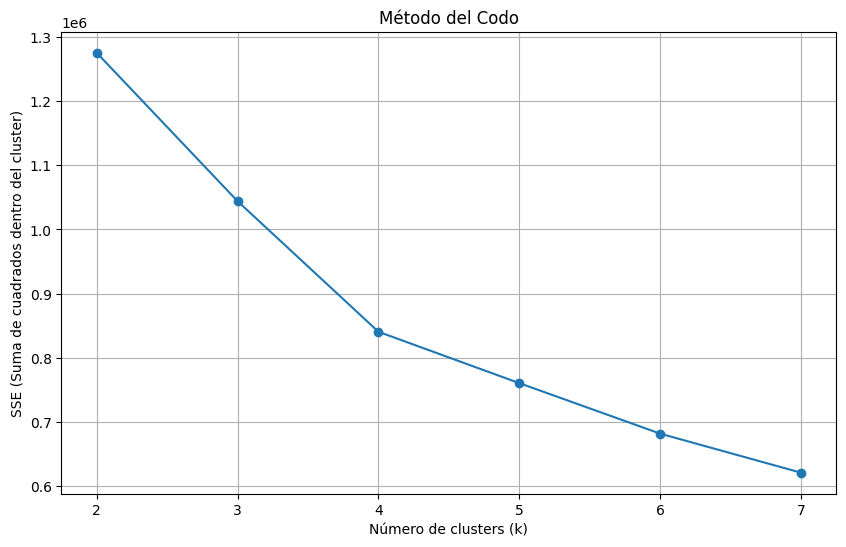

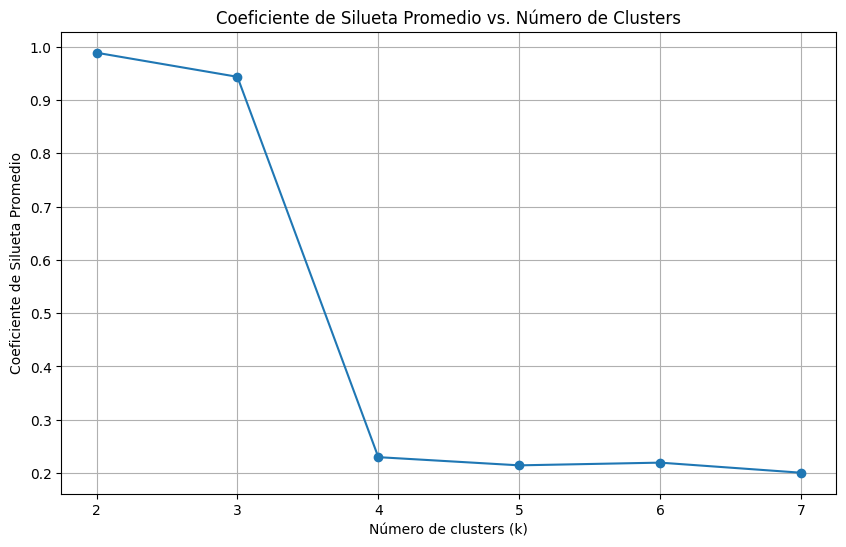

In [144]:
# 3. Visualizar resultados para el método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('SSE (Suma de cuadrados dentro del cluster)')
plt.title('Método del Codo')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# 4. Visualizar resultados para el coeficiente de silueta
# Asegúrate de que la lista silhouette_scores tenga la longitud correcta para los valores de k > 1
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o') # k_range[1:] porque silueta requiere k > 1
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Coeficiente de Silueta Promedio vs. Número de Clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [155]:
k_optimo = 3
preprocessor = preprocessor_onehot

print(f"\nEntrenando el modelo K-Means final con k = {k_optimo}...")
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('cluster', KMeans(n_clusters=k_optimo, random_state=42, n_init=10))])
final_pipeline.fit(df_sample)

# Puedes añadir las etiquetas de cluster al DataFrame original si lo necesitas
df_sample['Cluster_Label'] = final_pipeline['cluster'].labels_
print("\nPrimeras filas del DataFrame con las etiquetas de cluster:")
print(df_sample[['Category', 'Size', 'Rating', 'Cluster_Label']].head())
print("\nDistribución de puntos por cluster:")
print(df_sample['Cluster_Label'].value_counts())


Entrenando el modelo K-Means final con k = 3...

Primeras filas del DataFrame con las etiquetas de cluster:
                 Category   Size  Rating  Cluster_Label
14758              Sports  0.078     3.3              0
133951              Tools  0.036     3.8              0
4450    Books & Reference  1.000     0.0              0
82303            Shopping  0.529     5.0              0
58856       Entertainment  0.091     4.2              0

Distribución de puntos por cluster:
Cluster_Label
0    248735
1       121
2        11
Name: count, dtype: int64



Loadings of Original Variables on Principal Components:
     Size_log    Rating  Rating_Count_log  max_installs_log     Price  \
PC1 -0.001631 -0.000485         -0.001825         -0.009208  0.999828   
PC2  0.202490  0.339254          0.575548          0.587939  0.011044   

     Active_Life_log  Inactive_Time_log  Ad Supported_False  \
PC1         0.002074           0.006210            0.010214   
PC2         0.227910          -0.243715           -0.143097   

     Ad Supported_True  In App Purchases_False  In App Purchases_True  
PC1          -0.010214                0.000704              -0.000704  
PC2           0.143097               -0.085330               0.085330  


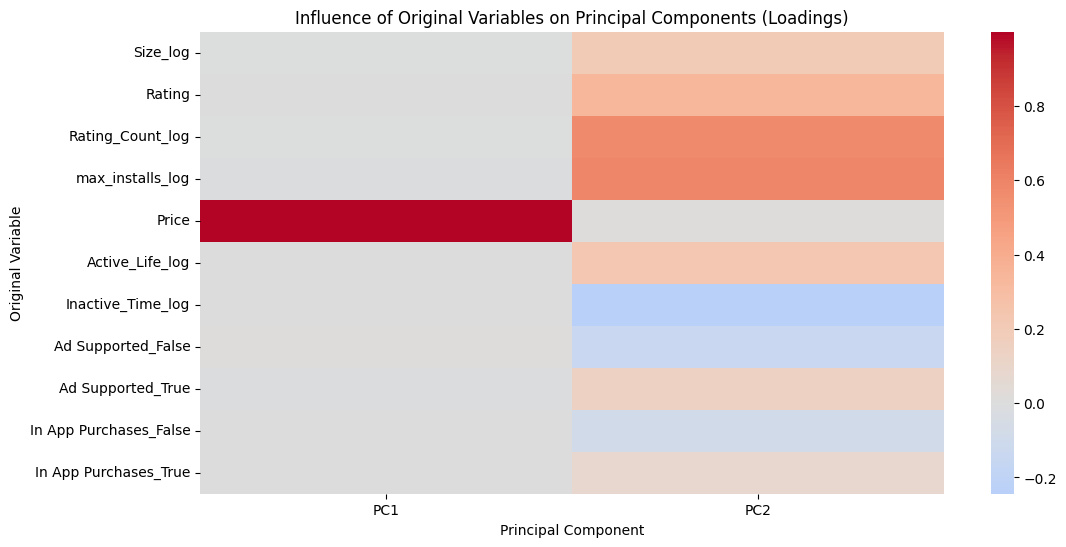

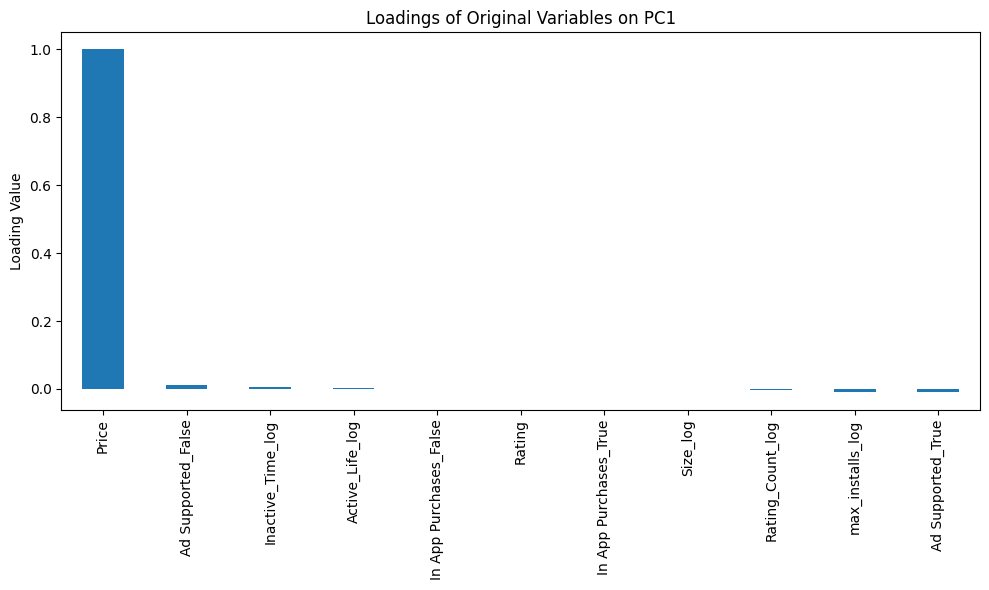

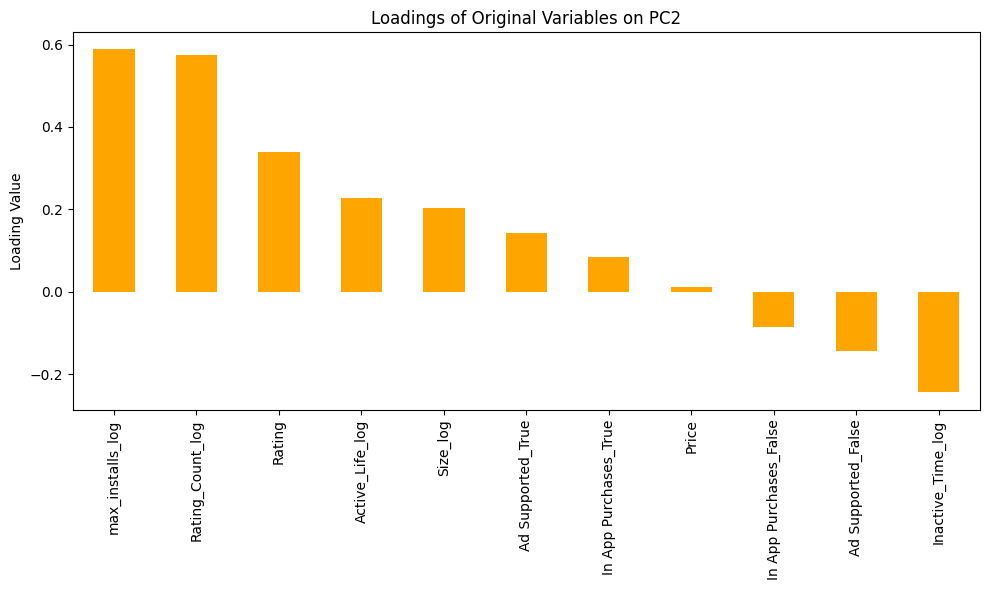

In [158]:
# prompt: plot the influence of the original variables on each primary component

# Access the loadings (components_) from the fitted PCA object
# The columns of the components_ array correspond to the original features in the preprocessed data
# and the rows correspond to the principal components.
# The absolute value of the loadings indicates the strength of the influence.

# Get the feature names after preprocessing (including one-hot encoded columns)
# This requires accessing the ColumnTransformer and its transformers
feature_names = []
# Numerical features from the scaler
feature_names.extend(numerical_features) # These names are unchanged

# Categorical features from the one-hot encoder
# Access the fitted OneHotEncoder
onehot_encoder = final_pipeline['preprocessor'].named_transformers_['cat']
# Get the feature names generated by the OneHotEncoder
categorical_feature_names = list(onehot_encoder.get_feature_names_out(categorical_features))
feature_names.extend(categorical_feature_names)


# Create a DataFrame for easier interpretation of loadings
loadings_df = pd.DataFrame(pca.components_, columns=feature_names, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print("\nLoadings of Original Variables on Principal Components:")
print(loadings_df)

# Visualize the loadings
plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df.T, cmap='coolwarm', annot=False, fmt=".2f", center=0)
plt.title('Influence of Original Variables on Principal Components (Loadings)')
plt.xlabel('Principal Component')
plt.ylabel('Original Variable')
plt.show()

# Optional: Visualize the loadings for the first few components individually
# For PC1
plt.figure(figsize=(10, 6))
loadings_df.loc['PC1'].sort_values(ascending=False).plot(kind='bar')
plt.title('Loadings of Original Variables on PC1')
plt.ylabel('Loading Value')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# For PC2
if pca.n_components_ > 1:
    plt.figure(figsize=(10, 6))
    loadings_df.loc['PC2'].sort_values(ascending=False).plot(kind='bar', color='orange')
    plt.title('Loadings of Original Variables on PC2')
    plt.ylabel('Loading Value')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Add more plots for other components if needed

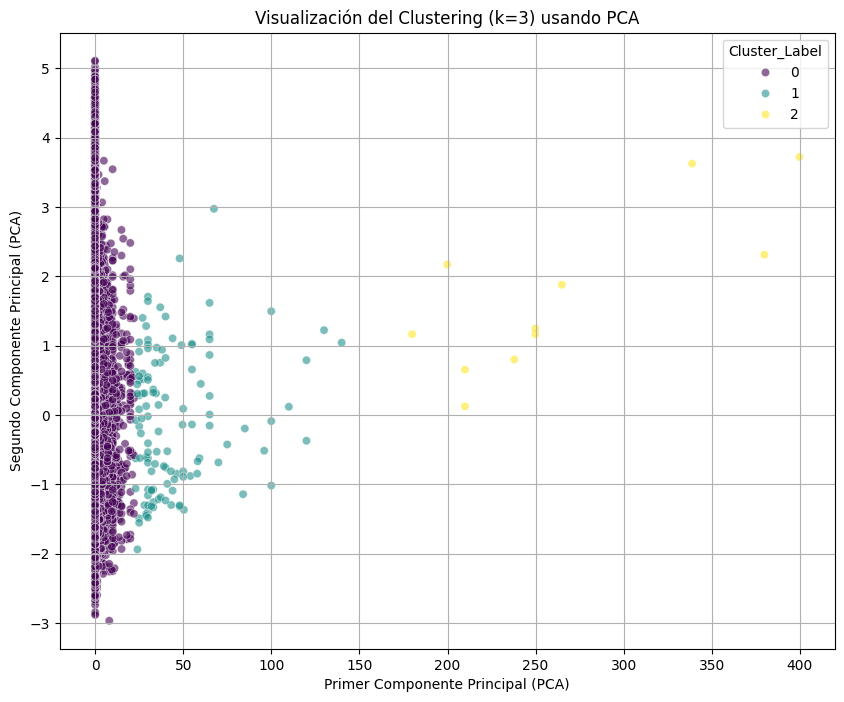


Explained variance ratio by PCA components:
[0.6058641 0.1404099]
Total explained variance by the first 2 components: 0.7463


In [156]:
from sklearn.decomposition import PCA

# Get the preprocessed data
X_preprocessed = final_pipeline['preprocessor'].transform(df_sample)

# Apply PCA to reduce dimensions to 2 for visualization
# n_components=2 means we want to reduce the dimensionality to 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)

# Create a DataFrame with the PCA results and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA_Component_1', 'PCA_Component_2'])
pca_df['Cluster_Label'] = df_sample['Cluster_Label'].reset_index(drop=True) # Ensure index alignment

plt.close('all')
# Visualize the clusters in the 2D PCA space
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PCA_Component_1',
    y='PCA_Component_2',
    hue='Cluster_Label',
    data=pca_df,
    palette='viridis', # Or any other color palette
    legend='full',
    alpha=0.6
)
plt.title(f'Visualización del Clustering (k={k_optimo}) usando PCA')
plt.xlabel('Primer Componente Principal (PCA)')
plt.ylabel('Segundo Componente Principal (PCA)')
plt.grid(True)
plt.show()

# Optional: Explain the variance ratio of the PCA components
print("\nExplained variance ratio by PCA components:")
print(pca.explained_variance_ratio_)
print(f"Total explained variance by the first 2 components: {pca.explained_variance_ratio_.sum():.4f}")

El primer componente principal esta fuertemente influenciado por el precio de manera positiva.
El segundo es más complejo de interpretar pero cuanto mas alto 'mejor'.

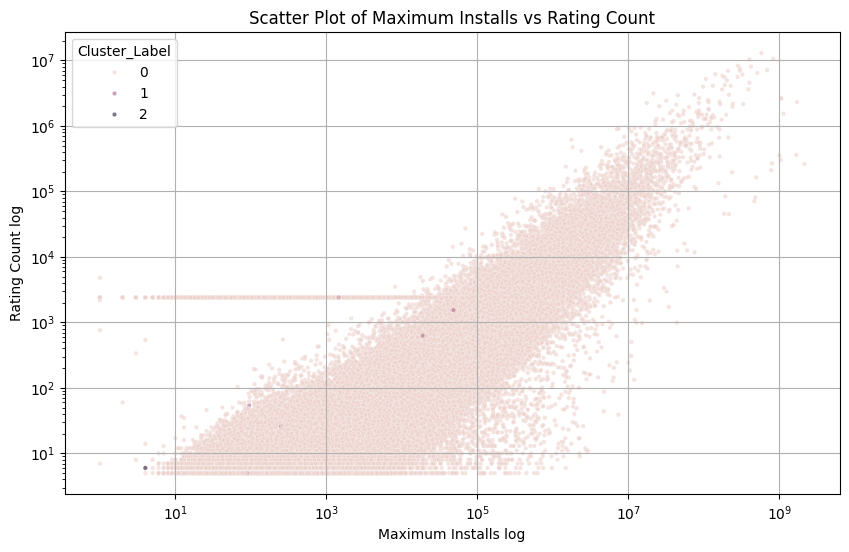

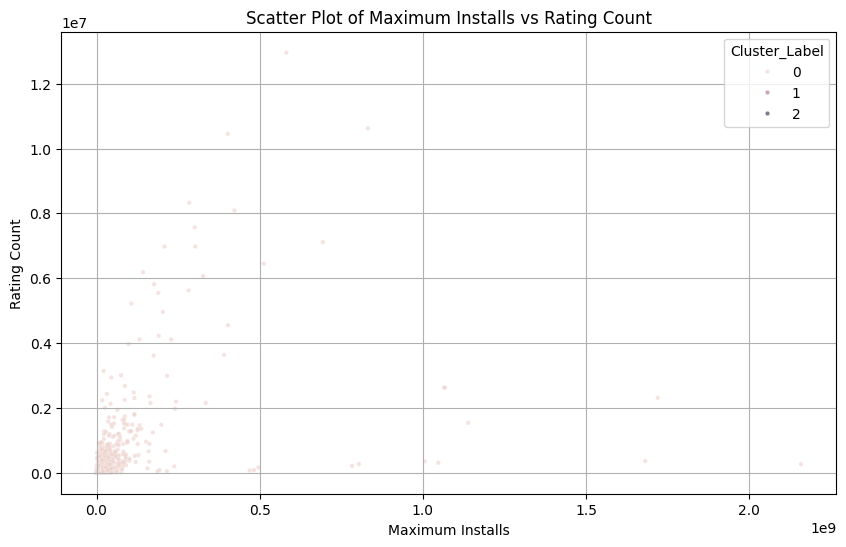

In [157]:
plt.close('all')
gc.collect()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Maximum Installs',
    y='Rating Count',
    hue = 'Cluster_Label',
    data=df_sample,
    alpha=0.6,  # Adjust alpha for better visibility of dense areas
    s=10  # Adjust size of points
)
plt.title('Scatter Plot of Maximum Installs vs Rating Count')
plt.xlabel('Maximum Installs log')
plt.ylabel('Rating Count log')
# Use log scales for both axes due to large range of values
plt.xscale('log',)
plt.yscale('log')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Maximum Installs',
    y='Rating Count',
    hue='Cluster_Label',
    data=df_sample,
    alpha=0.6,  # Adjust alpha for better visibility of dense areas
    s=10  # Adjust size of points
)
plt.title('Scatter Plot of Maximum Installs vs Rating Count')
plt.xlabel('Maximum Installs')
plt.ylabel('Rating Count')
plt.grid(True)
plt.show()

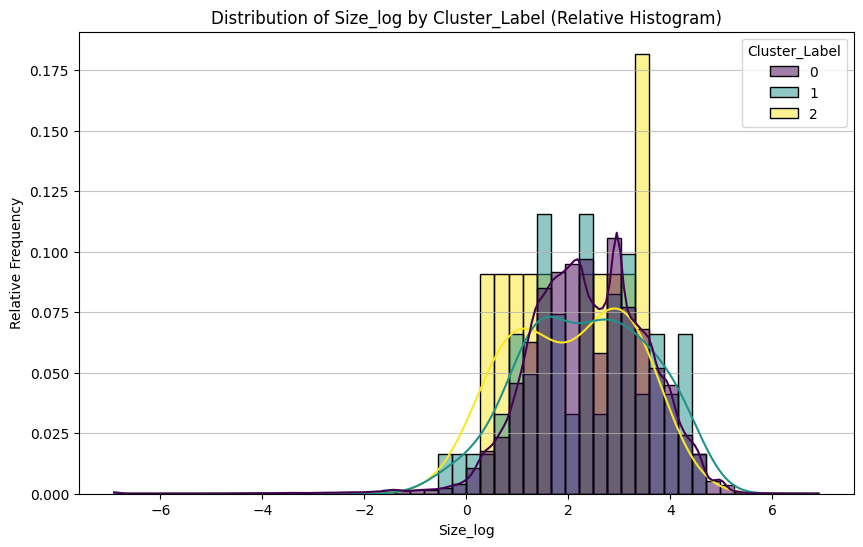

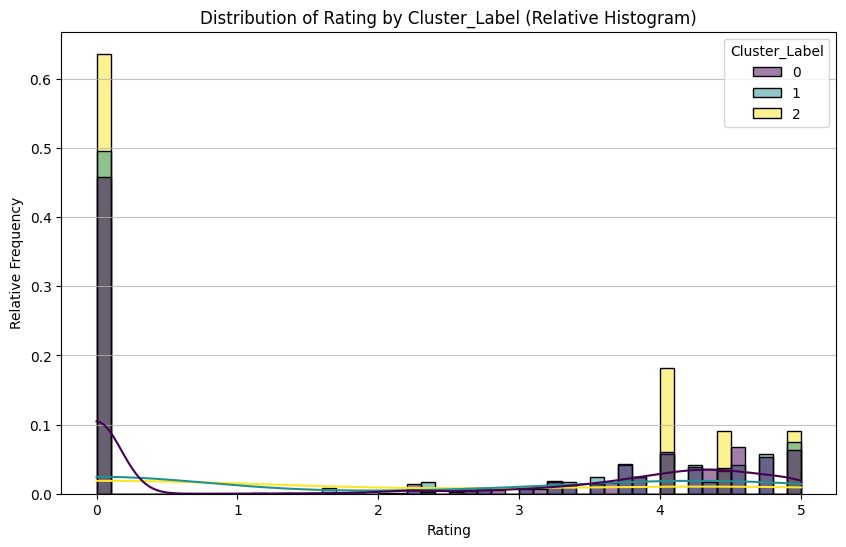

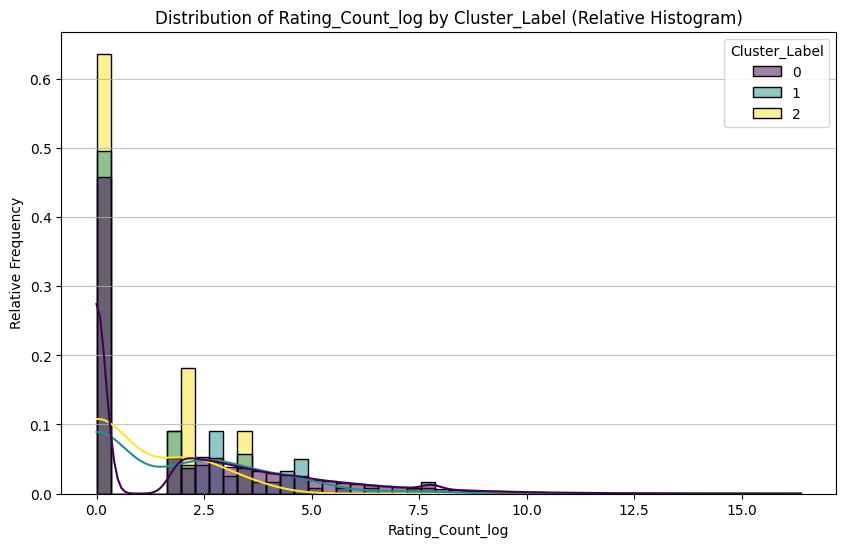

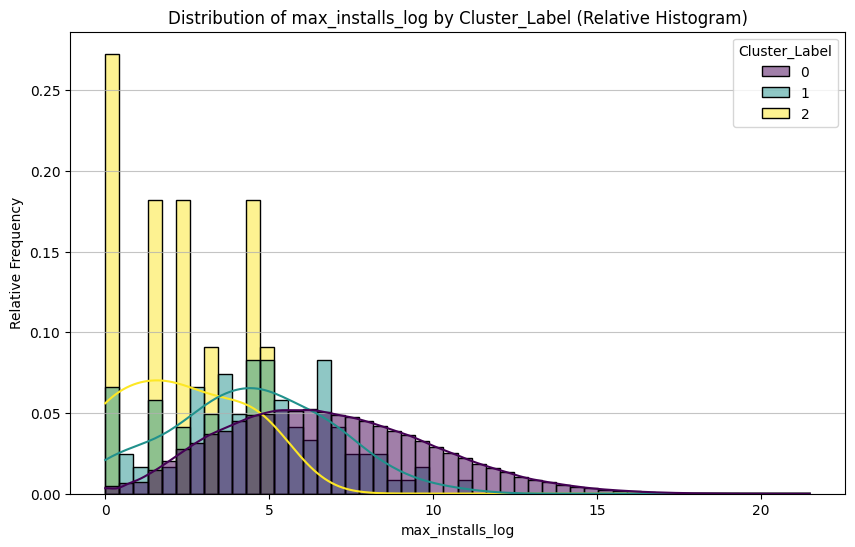

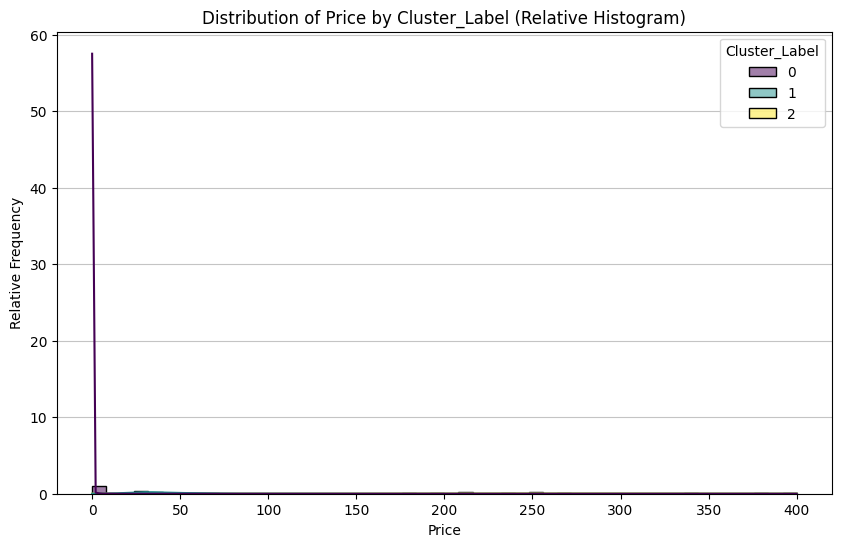

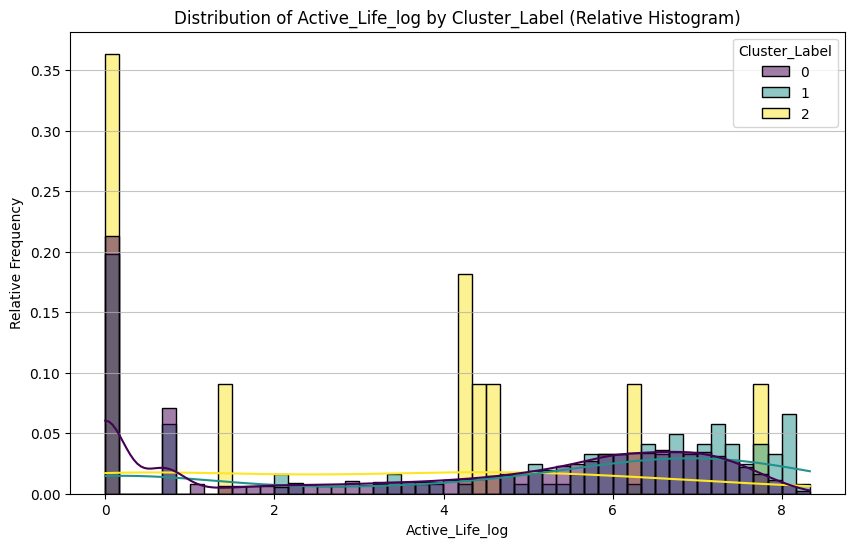

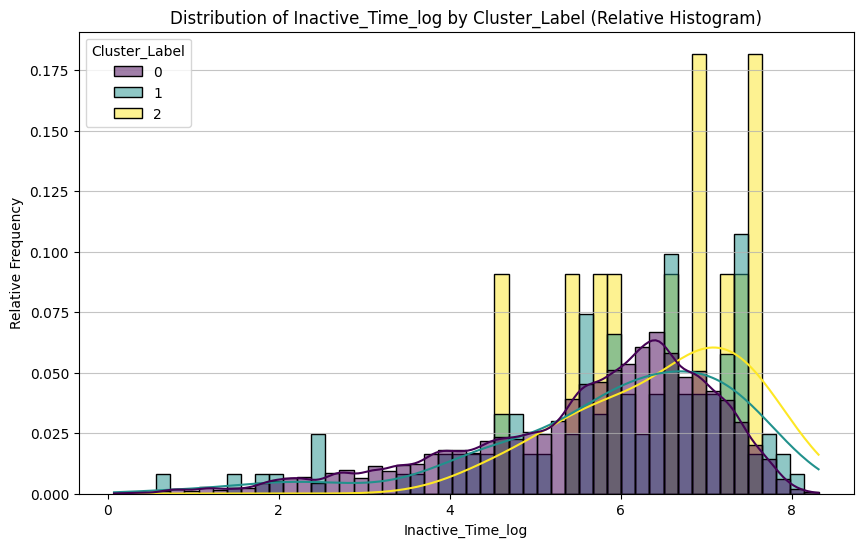

In [159]:
# prompt: plot the distribution with a relative histogram of all numerical features dividing hue by Cluster_Label

# Get numerical features used for clustering
# Make sure this list matches the one used in the ColumnTransformer for numerical features
numerical_features_for_clustering = ['Size_log', 'Rating', 'Rating_Count_log', 'max_installs_log', 'Price', 'Active_Life_log', 'Inactive_Time_log']
# Ensure these columns exist in the DataFrame
numerical_features_for_clustering = [col for col in numerical_features_for_clustering if col in df_sample.columns]

# Plot the distribution of each numerical feature, divided by Cluster_Label
for col in numerical_features_for_clustering:
    plt.close('all')
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df_sample,
        x=col,
        hue='Cluster_Label',          # Divide distributions by cluster label
        bins=50,                      # Adjust number of bins as needed
        kde=True,                     # Add Kernel Density Estimate
        stat='probability',           # Show relative frequency
        common_norm=False,            # Normalize each histogram independently within hue categories
        palette='viridis'             # Choose a color palette
    )

    plt.title(f'Distribution of {col} by Cluster_Label (Relative Histogram)')
    plt.xlabel(col)
    plt.ylabel('Relative Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()




Plotting distribution for categorical feature: Ad Supported


<Figure size 1200x700 with 0 Axes>

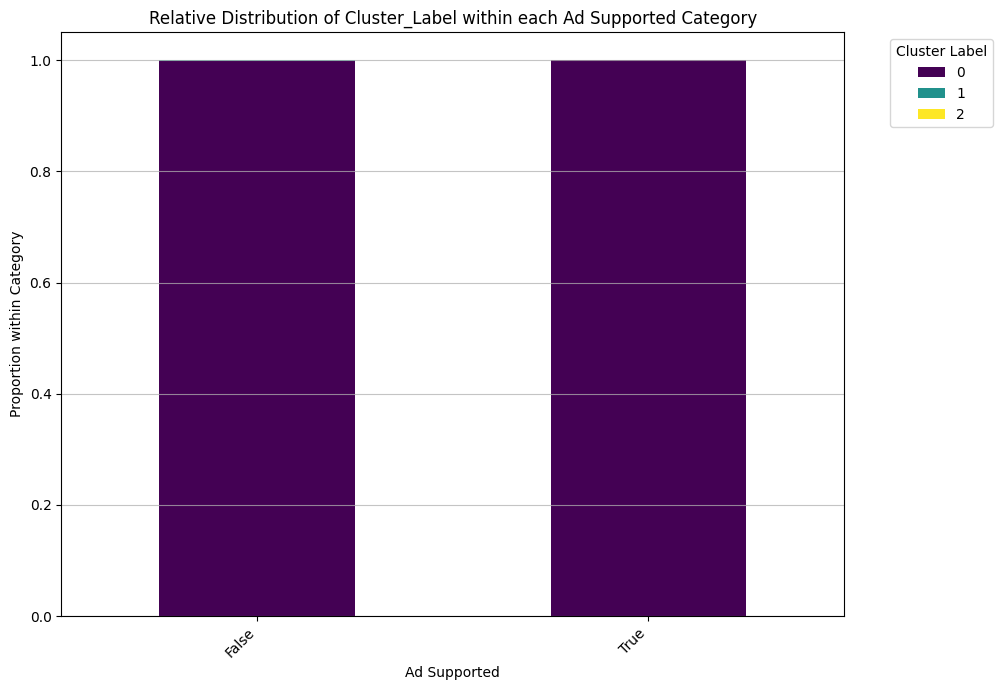

<Figure size 1200x700 with 0 Axes>

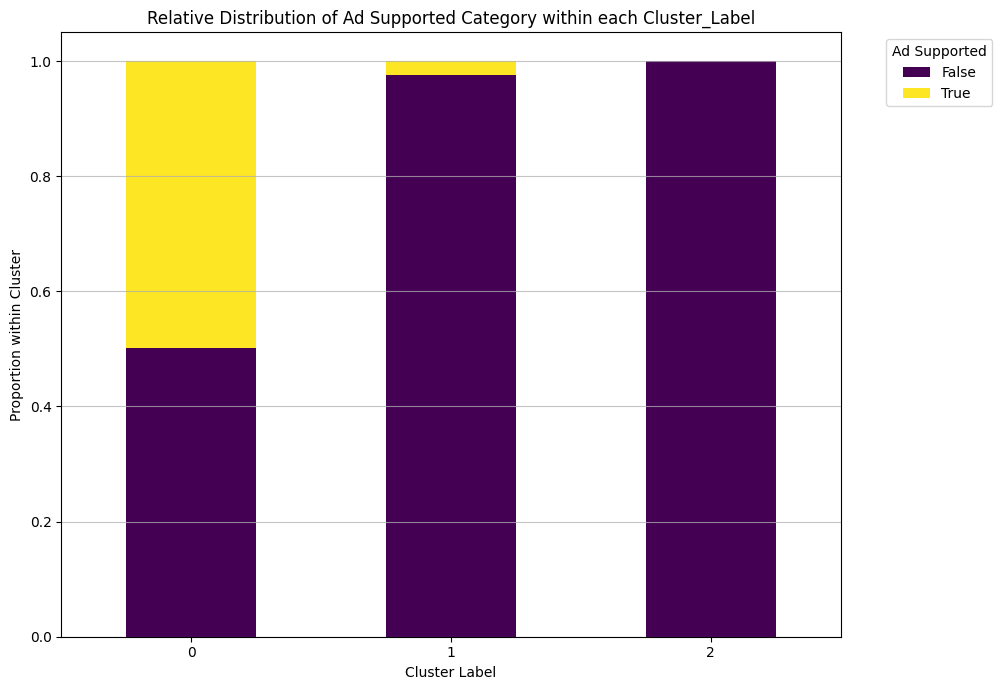


Plotting distribution for categorical feature: In App Purchases


<Figure size 1200x700 with 0 Axes>

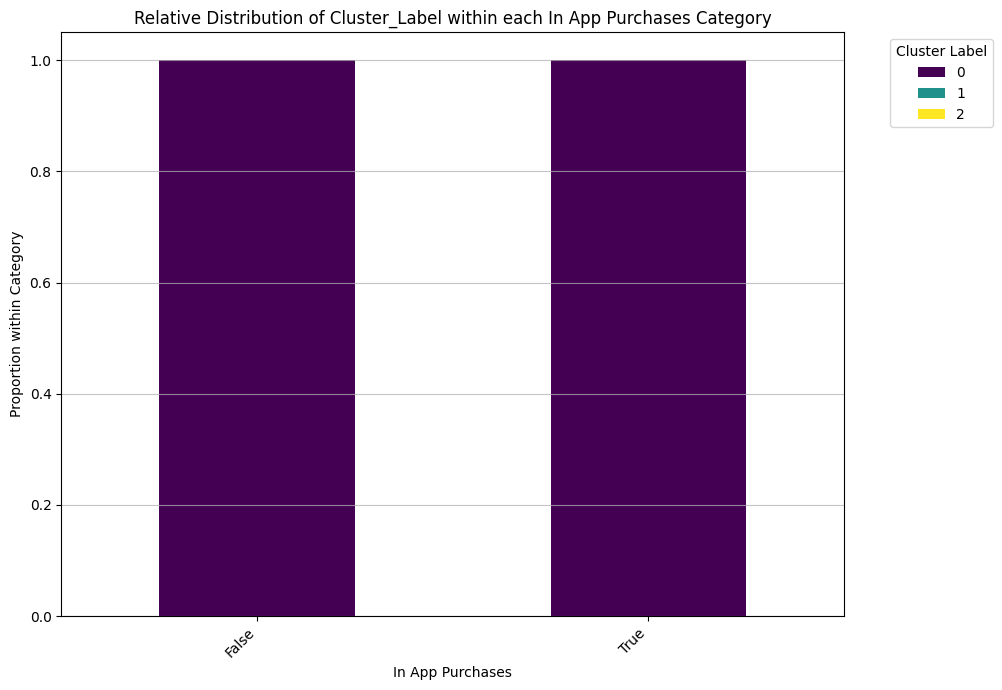

<Figure size 1200x700 with 0 Axes>

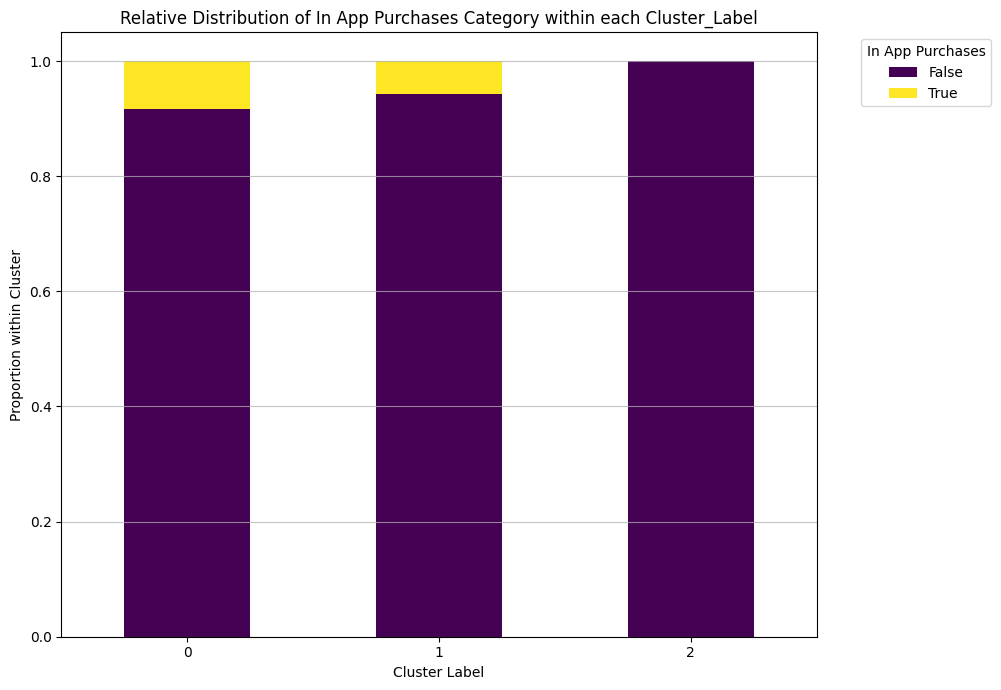


Plotting distribution for categorical feature: Free


<Figure size 1200x700 with 0 Axes>

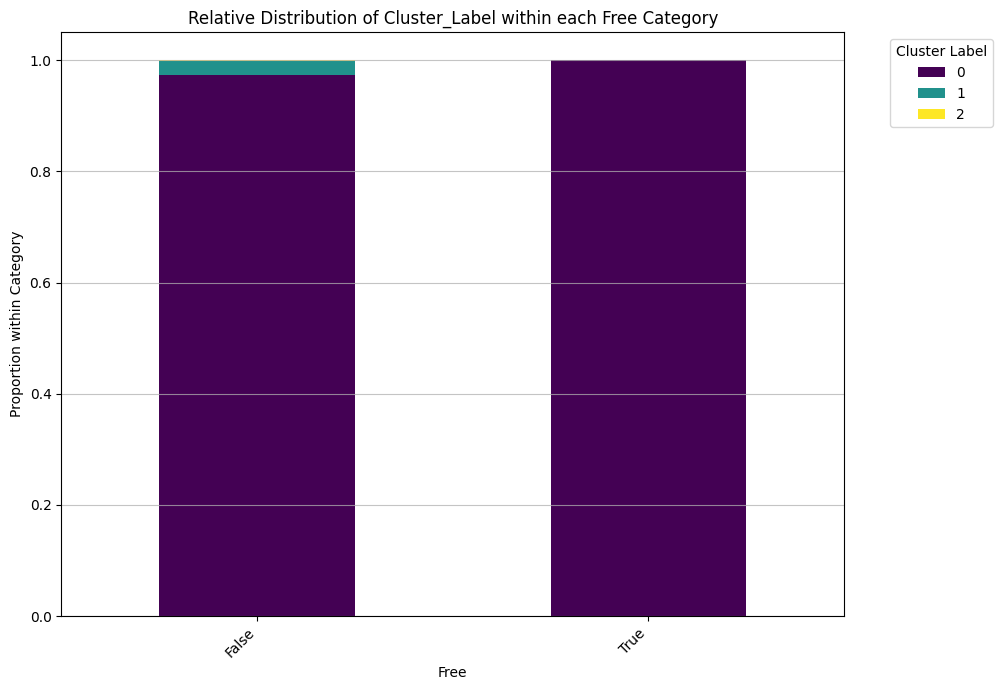

<Figure size 1200x700 with 0 Axes>

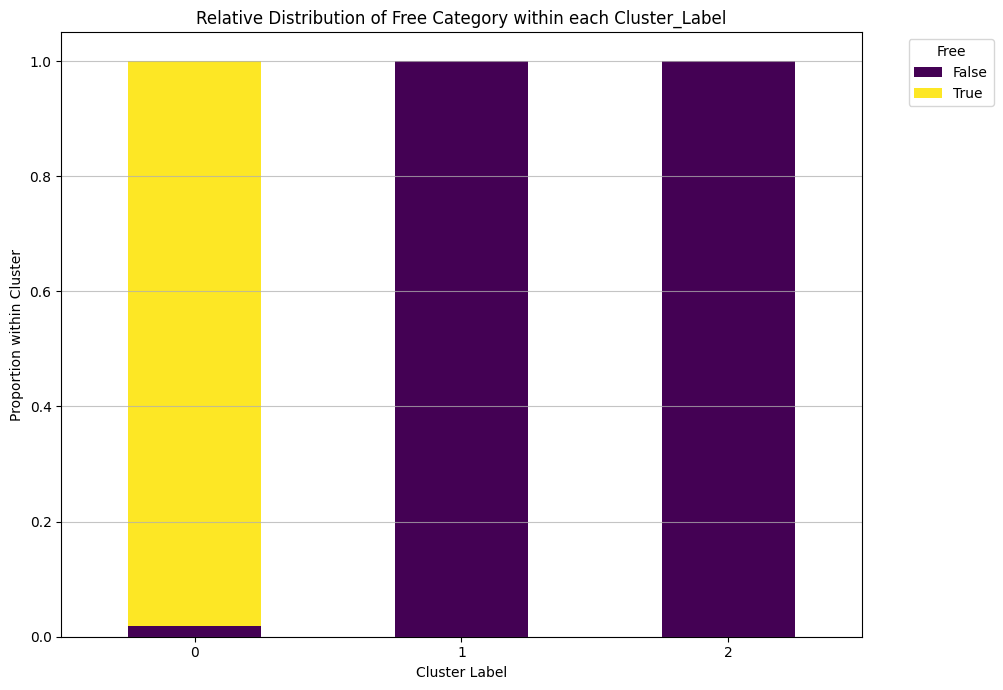


Plotting distribution for categorical feature: Editors Choice


<Figure size 1200x700 with 0 Axes>

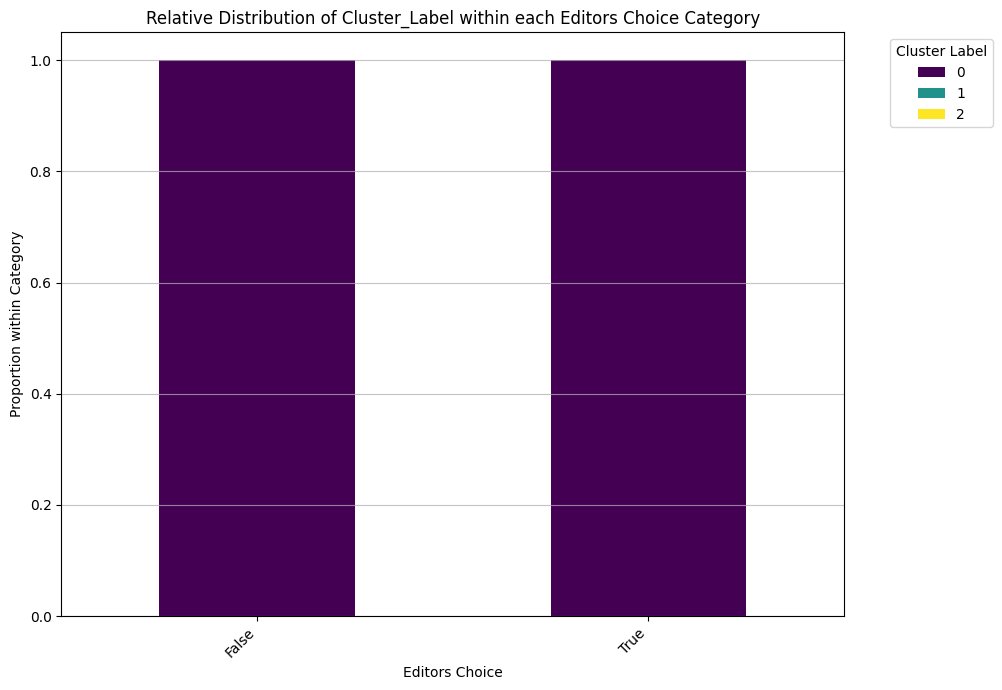

<Figure size 1200x700 with 0 Axes>

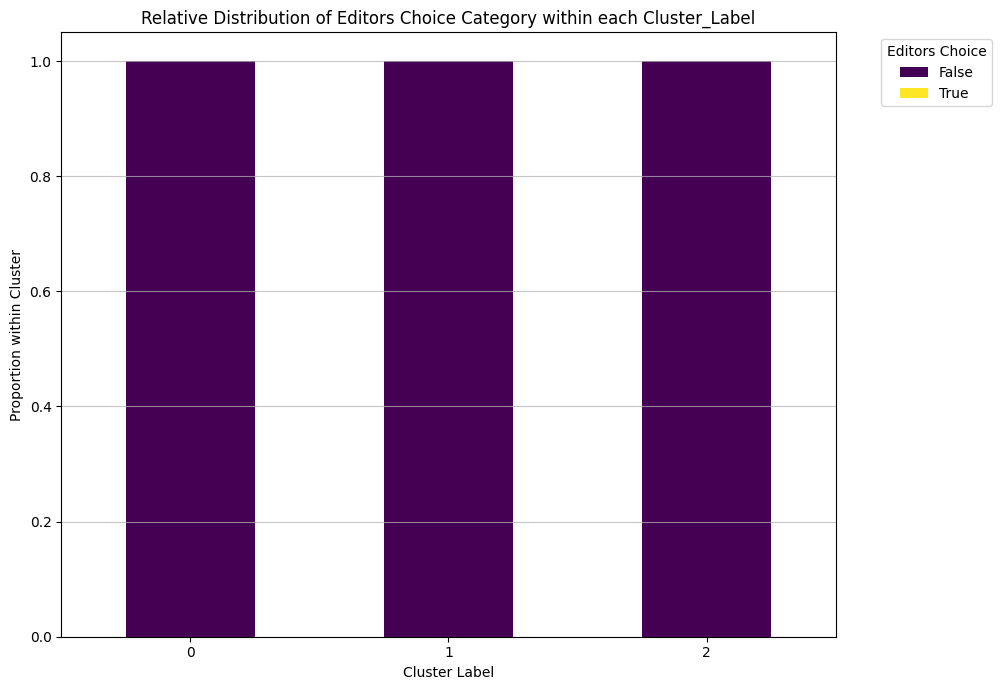


Plotting distribution for categorical feature: Content Rating


<Figure size 1200x700 with 0 Axes>

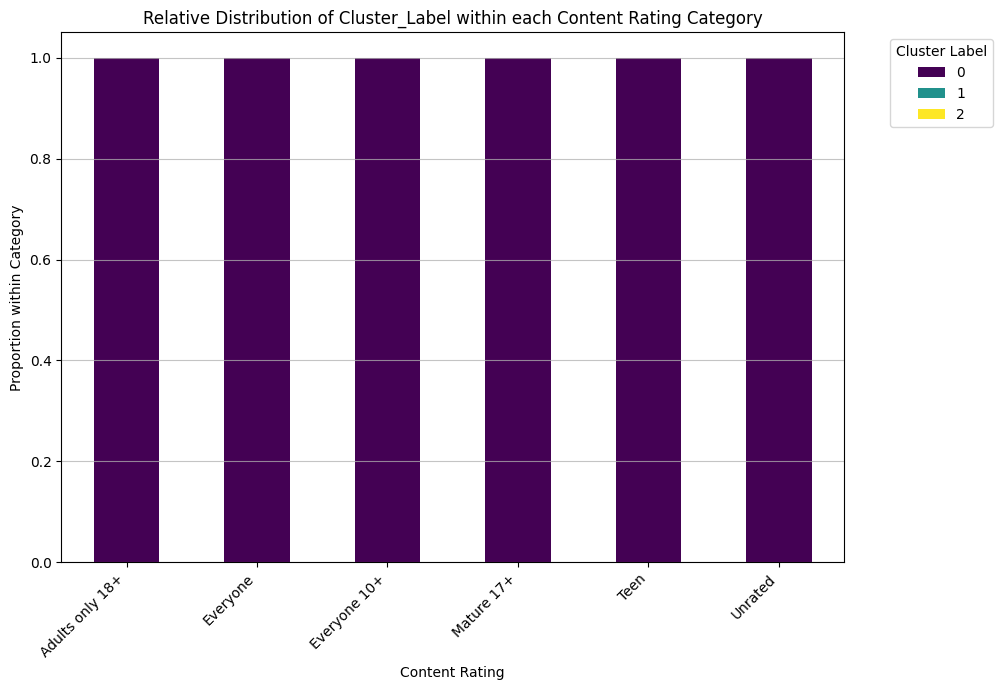

<Figure size 1200x700 with 0 Axes>

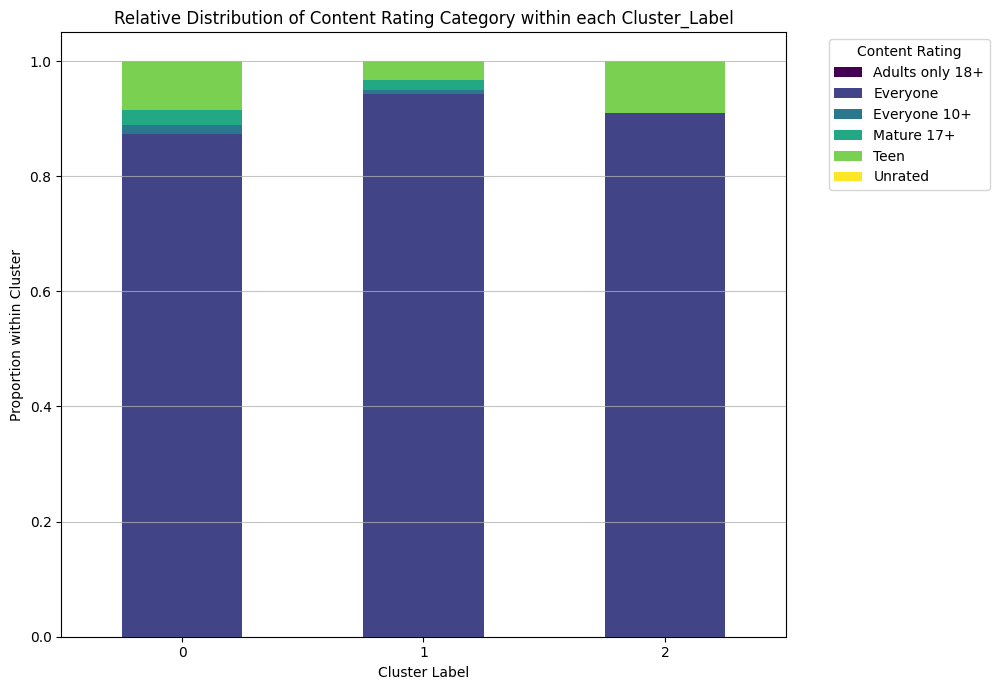

In [160]:
# prompt: plot for each Cluster_Label the distribution of each categorical feature

categorical_features_to_plot = ['Category_General', 'Ad Supported', 'In App Purchases', 'Free', 'Editors Choice', 'Content Rating']
# Ensure these columns exist in the DataFrame
categorical_features_to_plot = [col for col in categorical_features_to_plot if col in df_sample.columns and col != 'Cluster_Label']

for col in categorical_features_to_plot:
    plt.close('all')
    gc.collect()

    print(f"\nPlotting distribution for categorical feature: {col}")

    # Create a contingency table of the categorical feature and the cluster label
    # This counts how many instances of each category fall into each cluster
    contingency_table = pd.crosstab(df_sample[col], df_sample['Cluster_Label'])

    # Calculate the proportion of each cluster within each category
    # Divide each row by its sum to get proportions that sum to 1 within each category
    proportion_within_category = contingency_table.divide(contingency_table.sum(axis=1), axis=0)

    # Plot the stacked bar chart showing the proportion of clusters within each category
    plt.figure(figsize=(12, 7))
    proportion_within_category.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis')

    plt.title(f'Relative Distribution of Cluster_Label within each {col} Category')
    plt.xlabel(col)
    plt.ylabel('Proportion within Category')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
    plt.grid(axis='y', alpha=0.75)
    plt.show()

    # Optional: Also plot the count of each category within each cluster
    # Calculate the proportion of each category within each cluster
    # Divide each column by its sum to get proportions that sum to 1 within each cluster
    proportion_within_cluster = contingency_table.divide(contingency_table.sum(axis=0), axis=1)

    plt.figure(figsize=(12, 7))
    proportion_within_cluster.T.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis') # Transpose to have clusters on x-axis

    plt.title(f'Relative Distribution of {col} Category within each Cluster_Label')
    plt.xlabel('Cluster Label')
    plt.ylabel('Proportion within Cluster')
    plt.xticks(rotation=0, ha='center')
    plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Modelos de Regresión

Advertencia: Las siguientes features no fueron clasificadas como numéricas ni categóricas y podrían no ser procesadas correctamente por el preprocesador actual: ['Min_Age']

Ajustando el pipeline XGBoost...
Pipeline ajustado.

--- Métricas de Rendimiento del Modelo (XGBoost) ---
Error Absoluto Medio (MAE): 549,406.12
Error Cuadrático Medio (MSE): 159,785,668,313,088.00
Raíz del Error Cuadrático Medio (RMSE): 12,640,635.60
Coeficiente de Determinación (R²): -0.1049


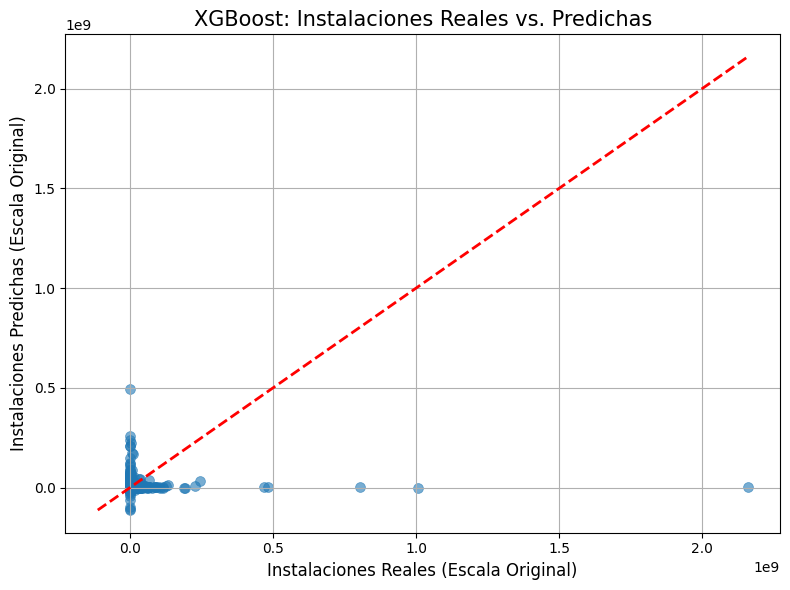


--- Análisis de Residuos ---


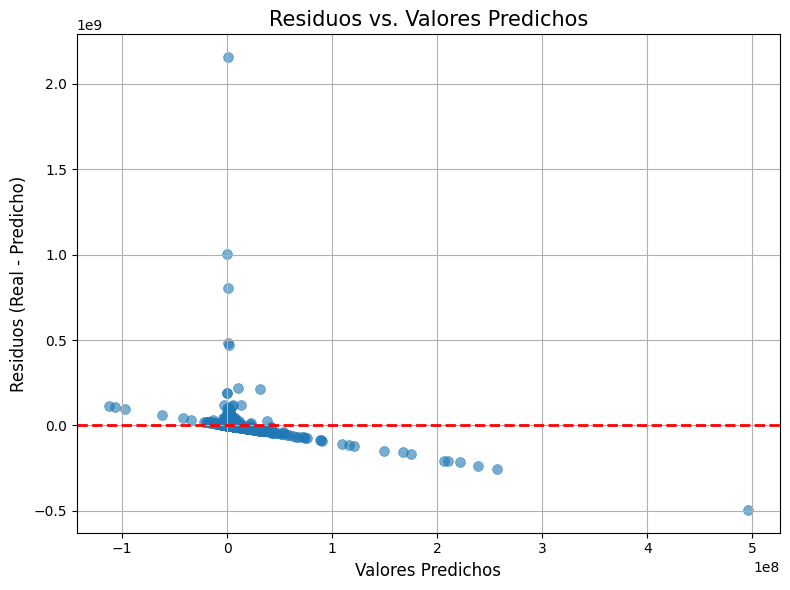

Interpretación del gráfico de Residuos vs. Predichos:
- Busca una dispersión aleatoria de puntos alrededor de la línea horizontal en cero.
- Patrones como un embudo (heterocedasticidad) o una curva pueden indicar problemas con el modelo.


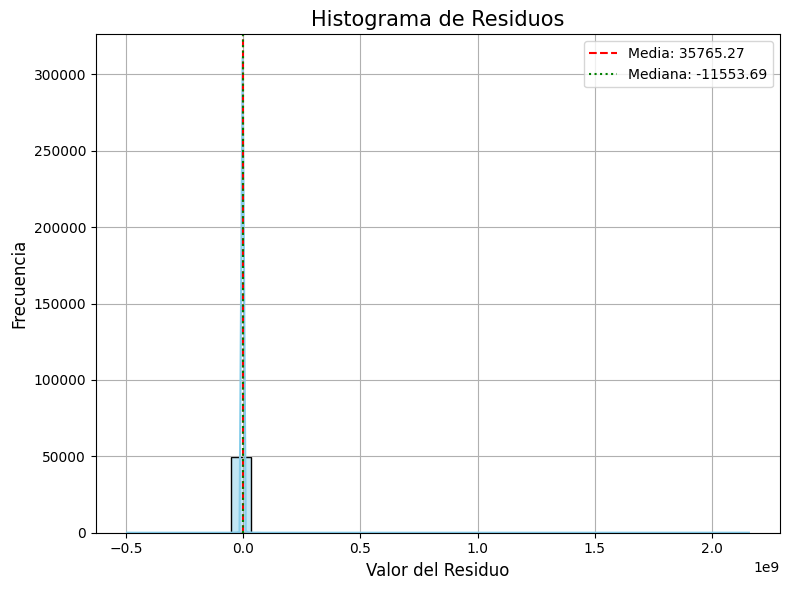

Interpretación del Histograma de Residuos:
- Idealmente, los residuos deberían distribuirse aproximadamente de forma normal alrededor de cero.
- Una fuerte asimetría o múltiples modas pueden indicar problemas.

--- Importancia de las Características (XGBoost) ---


<ipython-input-180-fa8553d43eb4>:186: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(n_top_features), palette='viridis')


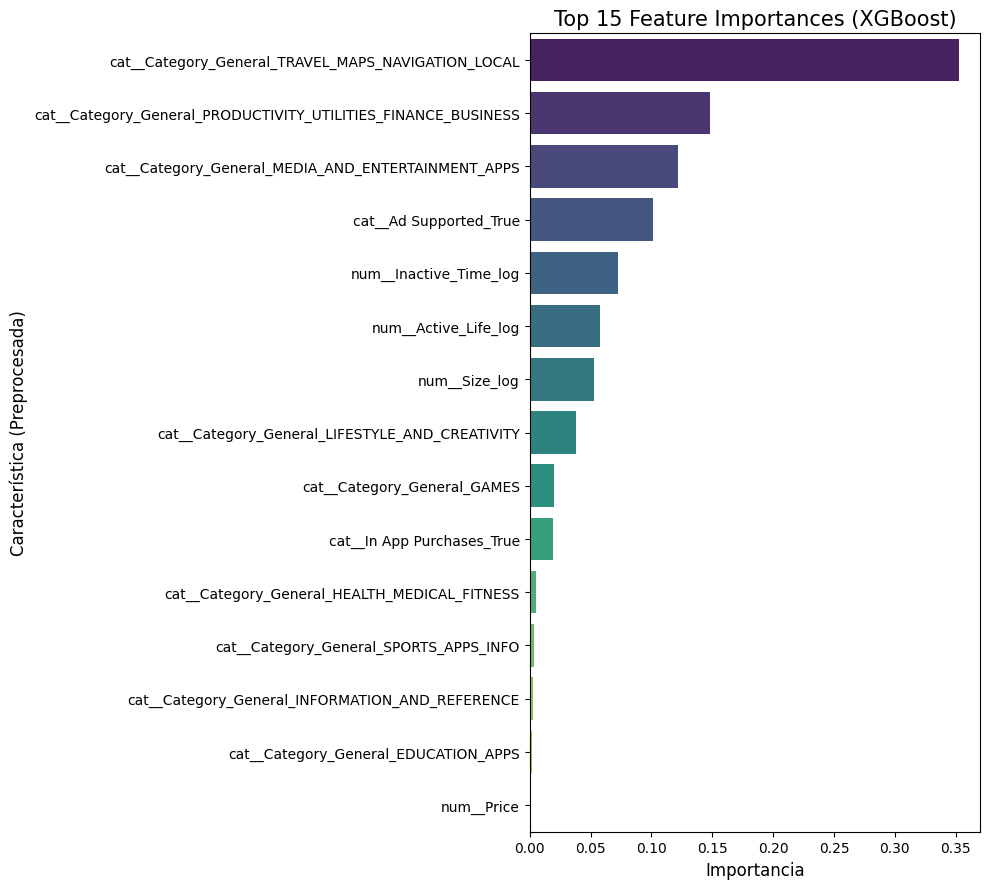


Top 10 Características Más Importantes:
                                                          feature  importance
13             cat__Category_General_TRAVEL_MAPS_NAVIGATION_LOCAL    0.352349
11  cat__Category_General_PRODUCTIVITY_UTILITIES_FINANCE_BUSINESS    0.148186
10             cat__Category_General_MEDIA_AND_ENTERTAINMENT_APPS    0.122018
14                                         cat__Ad Supported_True    0.101142
3                                          num__Inactive_Time_log    0.072908
2                                            num__Active_Life_log    0.057986
0                                                   num__Size_log    0.053071
9                  cat__Category_General_LIFESTYLE_AND_CREATIVITY    0.038100
6                                     cat__Category_General_GAMES    0.019773
4                                      cat__In App Purchases_True    0.019457

--- Comparación con Modelo Baseline ---
Modelo Baseline (Prediciendo la Media de y_train):
MAE (Base

In [180]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler # Importado RobustScaler
from sklearn.impute import SimpleImputer # Usando SimpleImputer como en tu código
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc # Aunque no es estrictamente necesario aquí, es bueno para el hábito si trabajas con bucles después

# --- ASUMIMOS QUE df_sample YA ESTÁ CARGADO Y PREPROCESADO ---
# Ejemplo:
# df_sample = pd.read_csv('tu_dataset_preprocesado.csv')
# Asegúrate de que las columnas _log y Category_General existen

target = 'Maximum Installs'
potential_features = [
    'Size_log',
    'Price',
    'In App Purchases', # Booleano o 0/1
    'Min_Age',
    'Category_General', # Categórica (será OHE)
    'Ad Supported', # Booleano o 0/1
    'Active_Life_log',
    'Inactive_Time_log',
]

# Filtrar características para asegurar que existen en el DataFrame
features = [f for f in potential_features if f in df_sample.columns]
if len(features) != len(potential_features):
    missing_features = [f for f in potential_features if f not in df_sample.columns]
    print(f"Advertencia: Las siguientes características potenciales no se encontraron en df_sample y serán excluidas: {missing_features}")
    print(f"Características finalmente usadas: {features}")

if not features:
    raise ValueError("No features selected or found in the DataFrame. Stopping.")
if target not in df_sample.columns:
    raise ValueError(f"Target column '{target}' not found in DataFrame. Stopping.")

X = df_sample[features]
y = df_sample[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Especificar test_size

# Identificar tipos de columnas para el preprocesador DESPUÉS del split, usando X_train
numeric_features = [col for col in features if X_train[col].dtype in ['int64', 'float64', 'int32', 'float32']]
categorical_features = [col for col in features if X_train[col].dtype in ['object', 'category', 'bool']]

# Asegurarse de que todas las features estén en alguna lista o decidir qué hacer con las restantes
processed_features = set(numeric_features + categorical_features)
unprocessed_features = [f for f in features if f not in processed_features]
if unprocessed_features:
    print(f"Advertencia: Las siguientes features no fueron clasificadas como numéricas ni categóricas y podrían no ser procesadas correctamente por el preprocesador actual: {unprocessed_features}")
    # Podrías decidir añadirlas a numéricas o categóricas si su dtype no fue capturado, o revisar su tipo.

# Definición del Preprocesador
# (Usando RobustScaler como discutimos para la sensibilidad a outliers)
# (SimpleImputer para numéricas)
# (OneHotEncoder para categóricas)

# Creamos pipelines separados para numéricas y categóricas para más claridad
# y para asegurar que la imputación ocurra antes del escalado en las numéricas.
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler()) # O StandardScaler() si prefieres y los outliers no son un gran problema
])

categorical_pipeline = Pipeline(steps=[
    # SimpleImputer para categóricas si hubiera NaNs, llenando con la más frecuente o una constante
    ('imputer', SimpleImputer(strategy='most_frequent')), # O strategy='constant', fill_value='Missing'
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop' # O 'drop' si estás seguro de que todas las features están cubiertas
)
# Nota: No es necesario ajustar (fit) el preprocesador por separado si es parte de un pipeline mayor.
# El pipeline mayor se encargará de ajustarlo con X_train.

# Definir el pipeline del modelo XGBoost
pipe = Pipeline([
    ('prep', preprocessor),
    ('reg', XGBRegressor(n_estimators=100, random_state=42, verbosity=0, early_stopping_rounds=10)) # Añadido early_stopping
])

# Ajustar el pipeline (esto ajustará el preprocesador con X_train y luego el regresor)
print("\nAjustando el pipeline XGBoost...")
# Crear datos de evaluación para early stopping
# X_train_eval, X_val_eval, y_train_eval, y_val_eval = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
# eval_set = [(X_val_eval, y_val_eval)] # Necesitaría preprocesar X_val_eval antes de pasarlo a XGBoost si no está en el pipeline
# Para usar early_stopping DENTRO de un pipeline de scikit-learn con XGBoost,
# los parámetros de fit para el estimador XGBoost deben prefijarse con `reg__` (o el nombre del paso).
# Ejemplo: `pipe.fit(X_train, y_train, reg__eval_set=eval_set, reg__verbose=False)`
# Para simplificar aquí, lo quitaré de la inicialización y lo ajustaré sin él,
# o el usuario puede añadir la lógica de eval_set si ya la tiene.
# Por ahora, quitamos early_stopping_rounds para un fit simple del pipeline.
pipe.named_steps['reg'].set_params(early_stopping_rounds=None) # Asegurar que no se usa si no se provee eval_set
pipe.fit(X_train, y_train)
print("Pipeline ajustado.")

y_pred = pipe.predict(X_test)

# --- INICIO DE LA SECCIÓN DE EVALUACIÓN DEL MODELO COMPLETA ---

print("\n--- Métricas de Rendimiento del Modelo (XGBoost) ---")
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Error Absoluto Medio (MAE): {mae:,.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:,.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:,.2f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")

# --- Gráfico de Valores Reales vs. Predichos ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, s=50, edgecolor=None)
plt.plot([min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())],
         [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())],
         'r--', lw=2) # Línea de referencia y=x
plt.title("XGBoost: Instalaciones Reales vs. Predichas", fontsize=15)
plt.xlabel("Instalaciones Reales (Escala Original)", fontsize=12)
plt.ylabel("Instalaciones Predichas (Escala Original)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Análisis de Residuos ---
print("\n--- Análisis de Residuos ---")
residuals = y_test - y_pred

# 1. Gráfico de Residuos vs. Valores Predichos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, s=50, edgecolor=None)
plt.axhline(y=0, color='r', linestyle='--', lw=2) # Línea en cero para referencia
plt.title("Residuos vs. Valores Predichos", fontsize=15)
plt.xlabel("Valores Predichos", fontsize=12)
plt.ylabel("Residuos (Real - Predicho)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Interpretación del gráfico de Residuos vs. Predichos:")
print("- Busca una dispersión aleatoria de puntos alrededor de la línea horizontal en cero.")
print("- Patrones como un embudo (heterocedasticidad) o una curva pueden indicar problemas con el modelo.")

# 2. Histograma de Residuos
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma de Residuos", fontsize=15)
plt.xlabel("Valor del Residuo", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.axvline(x=residuals.mean(), color='r', linestyle='--', lw=1.5, label=f'Media: {residuals.mean():.2f}')
plt.axvline(x=np.median(residuals), color='g', linestyle=':', lw=1.5, label=f'Mediana: {np.median(residuals):.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Interpretación del Histograma de Residuos:")
print("- Idealmente, los residuos deberían distribuirse aproximadamente de forma normal alrededor de cero.")
print("- Una fuerte asimetría o múltiples modas pueden indicar problemas.")

# --- Importancia de las Características (Específico de XGBoost) ---
print("\n--- Importancia de las Características (XGBoost) ---")
try:
    # Obtener nombres de características después del preprocesamiento
    feature_names_transformed = pipe.named_steps['prep'].get_feature_names_out()

    importances = pipe.named_steps['reg'].feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': feature_names_transformed,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    # Graficar las N características más importantes
    n_top_features = 20
    plt.figure(figsize=(10, max(6, n_top_features * 0.45))) # Ajustar altura dinámicamente
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(n_top_features), palette='viridis')
    plt.title(f"Top {min(n_top_features, len(feature_importance_df))} Feature Importances (XGBoost)", fontsize=15)
    plt.xlabel("Importancia", fontsize=12)
    plt.ylabel("Característica (Preprocesada)", fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Características Más Importantes:")
    print(feature_importance_df.head(10))

except Exception as e:
    print(f"No se pudieron obtener o graficar las importancias de las características: {e}")
    print("Asegúrate de que tu versión de scikit-learn sea lo suficientemente reciente para `get_feature_names_out()`.")
    print("Alternativamente, si el preprocesador es complejo, la obtención de nombres puede requerir un enfoque manual.")

# --- Comparación con un Modelo Baseline ---
print("\n--- Comparación con Modelo Baseline ---")
# Baseline: predecir siempre la media del target del conjunto de entrenamiento
baseline_prediction = np.full_like(y_test, fill_value=y_train.mean())

mae_baseline = mean_absolute_error(y_test, baseline_prediction)
mse_baseline = mean_squared_error(y_test, baseline_prediction)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_test, baseline_prediction) # Debería ser cercano a 0 o negativo

print("Modelo Baseline (Prediciendo la Media de y_train):")
print(f"MAE (Baseline): {mae_baseline:,.2f}")
print(f"MSE (Baseline): {mse_baseline:,.2f}")
print(f"RMSE (Baseline): {rmse_baseline:,.2f}")
print(f"R² (Baseline) : {r2_baseline:.4f}")

print("\nResumen Comparativo:")
print(f"                            XGBoost Model        |   Baseline Model")
print(f"---------------------------|----------------------|--------------------")
print(f"R² Coef. Determinación:    {r2:>7.4f}            |   {r2_baseline:>7.4f}")
print(f"RMSE:                      {rmse:>10,.2f}         |   {rmse_baseline:>10,.2f}")
print(f"MAE:                       {mae:>10,.2f}         |   {mae_baseline:>10,.2f}")

print("\n--- Fin de la Evaluación del Modelo ---")

Características finalmente usadas: ['Size_log', 'Price', 'In App Purchases', 'Min_Age', 'Category_General', 'Ad Supported', 'Active_Life_log', 'Inactive_Time_log']

Ajustando el pipeline XGBoost con target logarítmico...
Pipeline ajustado.

--- Métricas de Rendimiento del Modelo (XGBoost) ---
Métricas en Escala Logarítmica (Target: max_installs_log):
MAE (log): 1.96
MSE (log): 5.99
RMSE (log): 2.45
R² (log) : 0.4016

Métricas en Escala Original (Target: Maximum Installs):
MAE (original): 284,672
MSE (original): 144,645,056,283,354
RMSE (original): 12,026,847
R² (original) : -0.0002


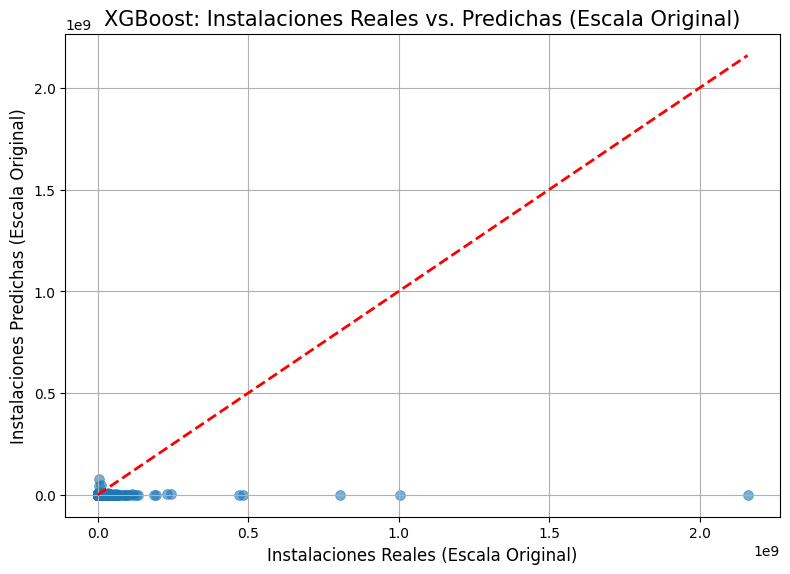


--- Análisis de Residuos (en Escala Logarítmica) ---


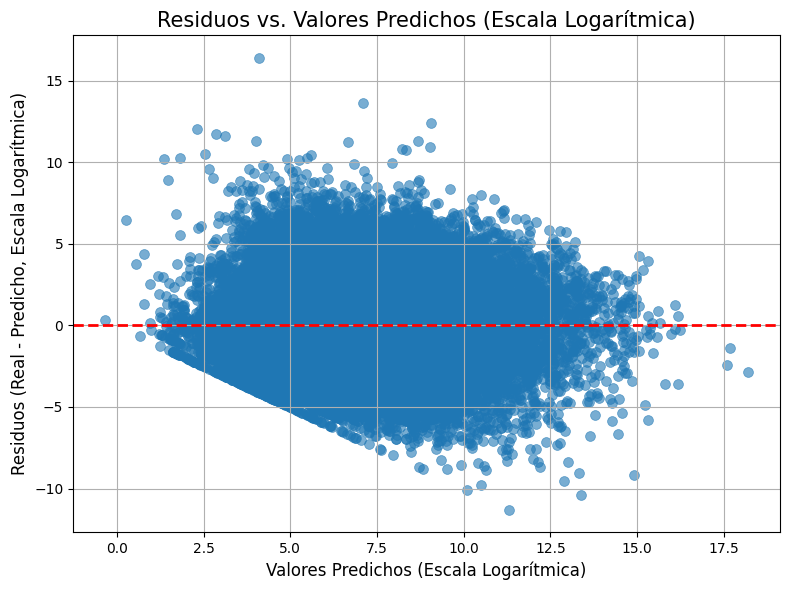

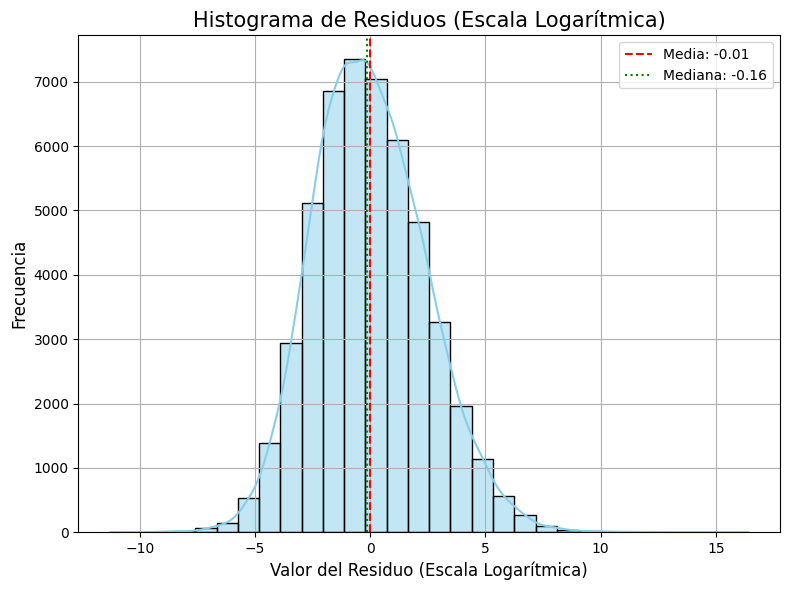


--- Importancia de las Características (XGBoost) ---


<ipython-input-182-1dea8edd6665>:201: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(n_top_features), palette='viridis')


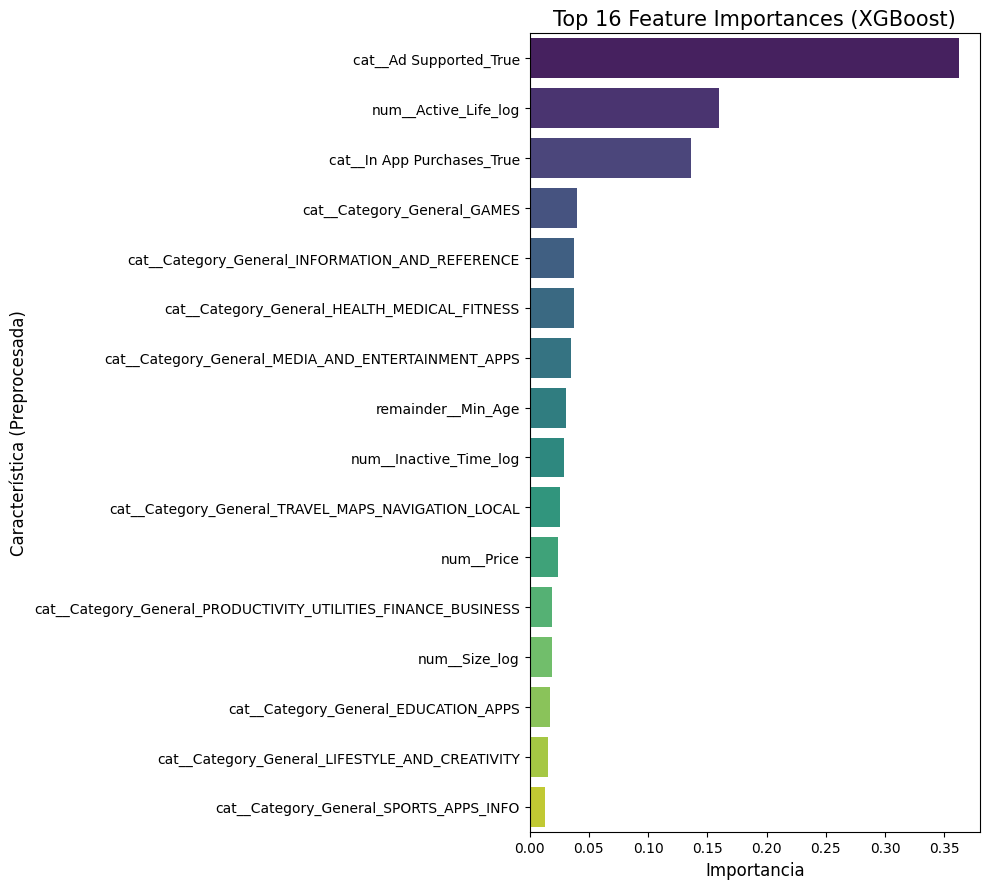

                                               feature  importance
14                              cat__Ad Supported_True    0.361917
2                                 num__Active_Life_log    0.159361
4                           cat__In App Purchases_True    0.136113
6                          cat__Category_General_GAMES    0.039936
8      cat__Category_General_INFORMATION_AND_REFERENCE    0.037310
7         cat__Category_General_HEALTH_MEDICAL_FITNESS    0.037297
10  cat__Category_General_MEDIA_AND_ENTERTAINMENT_APPS    0.035207
15                                  remainder__Min_Age    0.030667
3                               num__Inactive_Time_log    0.029379
13  cat__Category_General_TRAVEL_MAPS_NAVIGATION_LOCAL    0.025924

--- Comparación con Modelo Baseline (en Escala Logarítmica) ---
Modelo Baseline (Prediciendo la Media de y_train_log):
MAE (Baseline, log): 2.56
RMSE (Baseline, log): 3.16
R² (Baseline, log) : -0.0000

Resumen Comparativo (Escala Logarítmica):
                  

14941

In [182]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler # Asegúrate de importar RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc


target = 'max_installs_log' # Target ahora es logarítmico
potential_features = [
    'Size_log',
    'Price',
    'In App Purchases', # Booleano o 0/1
    'Min_Age',
    'Category_General', # Categórica (será OHE)
    'Ad Supported', # Booleano o 0/1
    'Active_Life_log',
    'Inactive_Time_log',
]

# Filtrar características
features = [f for f in potential_features if f in df_sample.columns]
if len(features) != len(potential_features):
    missing_features = [f for f in potential_features if f not in df_sample.columns]
    print(f"Advertencia: Las siguientes características potenciales no se encontraron y serán excluidas: {missing_features}")
print(f"Características finalmente usadas: {features}")

if not features:
    raise ValueError("No features selected or found. Stopping.")
if target not in df_sample.columns:
    raise ValueError(f"Target column '{target}' not found. Stopping.")

X = df_sample[features]
y = df_sample[target] # y está en escala logarítmica

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar tipos de columnas
numeric_features = [col for col in features if X_train[col].dtype in ['int64', 'float64', 'int32', 'float32']]
categorical_features = [col for col in features if X_train[col].dtype in ['object', 'category', 'bool']]

# Pipelines de preprocesamiento
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# Pipeline del modelo
pipe = Pipeline([
    ('prep', preprocessor),
    ('reg', XGBRegressor(n_estimators=100, random_state=42, verbosity=0)) # Considera early_stopping
])

print("\nAjustando el pipeline XGBoost con target logarítmico...")
pipe.fit(X_train, y_train) # y_train está en escala logarítmica
print("Pipeline ajustado.")

y_pred_log = pipe.predict(X_test) # y_pred_log también está en escala logarítmica

# --- INICIO DE LA SECCIÓN DE EVALUACIÓN DEL MODELO COMPLETA ---

# --- Revertir la transformación logarítmica para interpretación y algunas métricas ---
# Asumimos que la transformación fue np.log1p(x) para manejar ceros. Si fue np.log(x), usa np.exp(x).
# Si fue un log diferente, usa la inversa correspondiente.
# ¡IMPORTANTE! Si tu 'max_installs_log' se creó con np.log(x) y x podía ser 0 (lo que daría -inf),
# necesitarías haber usado np.log1p(x) = np.log(x+1) o manejar los ceros antes del log.
# Si usaste log(x+c), la inversa es exp(y) - c.
# Aquí asumiré que usaste np.log1p() para crear 'max_installs_log' a partir de 'Maximum Installs' originales.
# Si no, ajusta la transformación inversa.
try:
    y_test_original_scale = np.expm1(y_test)  # Inversa de np.log1p(x)
    y_pred_original_scale = np.expm1(y_pred_log)
    # Evitar valores negativos si expm1 da algo muy cercano a -1 por errores de flotante
    y_pred_original_scale[y_pred_original_scale < 0] = 0
except OverflowError:
    print("OverflowError al revertir la transformación logarítmica. Los valores predichos en escala log son muy grandes.")
    print("Evaluando en escala logarítmica y mostrando advertencia.")
    # Si hay overflow, no podemos volver a la escala original fácilmente para todas las métricas.
    # Continuaremos con algunas métricas en escala log y otras con advertencia.
    y_test_original_scale = None # Marcar como no disponible
    y_pred_original_scale = None


print("\n--- Métricas de Rendimiento del Modelo (XGBoost) ---")
# Métricas en la ESCALA LOGARÍTMICA (donde el modelo fue entrenado)
print("Métricas en Escala Logarítmica (Target: max_installs_log):")
mae_log = mean_absolute_error(y_test, y_pred_log)
mse_log = mean_squared_error(y_test, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test, y_pred_log)

print(f"MAE (log): {mae_log:,.2f}")
print(f"MSE (log): {mse_log:,.2f}")
print(f"RMSE (log): {rmse_log:,.2f}")
print(f"R² (log) : {r2_log:.4f}")

# Métricas en la ESCALA ORIGINAL (si fue posible la reversión)
if y_test_original_scale is not None and y_pred_original_scale is not None:
    print("\nMétricas en Escala Original (Target: Maximum Installs):")
    mae_orig = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
    mse_orig = mean_squared_error(y_test_original_scale, y_pred_original_scale)
    rmse_orig = np.sqrt(mse_orig)
    r2_orig = r2_score(y_test_original_scale, y_pred_original_scale) # R² en escala original puede ser diferente

    print(f"MAE (original): {mae_orig:,.0f}") # Sin decimales para instalaciones
    print(f"MSE (original): {mse_orig:,.0f}")
    print(f"RMSE (original): {rmse_orig:,.0f}")
    print(f"R² (original) : {r2_orig:.4f}")
else:
    print("\nNo se pudieron calcular métricas en la escala original debido a overflow o error previo.")


# --- Gráfico de Valores Reales vs. Predichos (EN ESCALA ORIGINAL si es posible) ---
if y_test_original_scale is not None and y_pred_original_scale is not None:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_original_scale, y=y_pred_original_scale, alpha=0.6, s=50, edgecolor=None)
    min_val = min(y_test_original_scale.min(), y_pred_original_scale.min())
    max_val = max(y_test_original_scale.max(), y_pred_original_scale.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2) # Línea de referencia y=x
    plt.title("XGBoost: Instalaciones Reales vs. Predichas (Escala Original)", fontsize=15)
    plt.xlabel("Instalaciones Reales (Escala Original)", fontsize=12)
    plt.ylabel("Instalaciones Predichas (Escala Original)", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    # Si no se pudo transformar, graficar en escala logarítmica
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred_log, alpha=0.6, s=50, edgecolor=None)
    min_val_log = min(y_test.min(), y_pred_log.min())
    max_val_log = max(y_test.max(), y_pred_log.max())
    plt.plot([min_val_log, max_val_log], [min_val_log, max_val_log], 'r--', lw=2)
    plt.title("XGBoost: Reales vs. Predichas (Escala Logarítmica)", fontsize=15)
    plt.xlabel("Reales (Escala Logarítmica)", fontsize=12)
    plt.ylabel("Predichas (Escala Logarítmica)", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Análisis de Residuos (EN ESCALA LOGARÍTMICA, donde el modelo opera) ---
print("\n--- Análisis de Residuos (en Escala Logarítmica) ---")
residuals_log = y_test - y_pred_log # Residuos en la escala de entrenamiento/predicción

# 1. Gráfico de Residuos vs. Valores Predichos (escala log)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_log, y=residuals_log, alpha=0.6, s=50, edgecolor=None)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title("Residuos vs. Valores Predichos (Escala Logarítmica)", fontsize=15)
plt.xlabel("Valores Predichos (Escala Logarítmica)", fontsize=12)
plt.ylabel("Residuos (Real - Predicho, Escala Logarítmica)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Histograma de Residuos (escala log)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_log, kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma de Residuos (Escala Logarítmica)", fontsize=15)
plt.xlabel("Valor del Residuo (Escala Logarítmica)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.axvline(x=residuals_log.mean(), color='r', linestyle='--', lw=1.5, label=f'Media: {residuals_log.mean():.2f}')
plt.axvline(x=np.median(residuals_log), color='g', linestyle=':', lw=1.5, label=f'Mediana: {np.median(residuals_log):.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Importancia de las Características (XGBoost) ---
# (Esta parte no cambia, ya que se basa en el modelo entrenado en la escala que sea)
print("\n--- Importancia de las Características (XGBoost) ---")
try:
    feature_names_transformed = pipe.named_steps['prep'].get_feature_names_out()
    importances = pipe.named_steps['reg'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names_transformed,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    n_top_features = 20
    plt.figure(figsize=(10, max(6, n_top_features * 0.45)))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(n_top_features), palette='viridis')
    plt.title(f"Top {min(n_top_features, len(feature_importance_df))} Feature Importances (XGBoost)", fontsize=15)
    plt.xlabel("Importancia", fontsize=12)
    plt.ylabel("Característica (Preprocesada)", fontsize=12)
    plt.tight_layout()
    plt.show()
    print(feature_importance_df.head(10))
except Exception as e:
    print(f"No se pudieron obtener o graficar las importancias de las características: {e}")

# --- Comparación con un Modelo Baseline ---
print("\n--- Comparación con Modelo Baseline (en Escala Logarítmica) ---")
baseline_prediction_log = np.full_like(y_test, fill_value=y_train.mean()) # y_train está en escala log

mae_baseline_log = mean_absolute_error(y_test, baseline_prediction_log)
rmse_baseline_log = np.sqrt(mean_squared_error(y_test, baseline_prediction_log))
r2_baseline_log = r2_score(y_test, baseline_prediction_log)

print("Modelo Baseline (Prediciendo la Media de y_train_log):")
print(f"MAE (Baseline, log): {mae_baseline_log:,.2f}")
print(f"RMSE (Baseline, log): {rmse_baseline_log:,.2f}")
print(f"R² (Baseline, log) : {r2_baseline_log:.4f}")

print("\nResumen Comparativo (Escala Logarítmica):")
print(f"                            XGBoost Model        |   Baseline Model")
print(f"---------------------------|----------------------|--------------------")
print(f"R² Coef. Determinación:    {r2_log:>7.4f}            |   {r2_baseline_log:>7.4f}")
print(f"RMSE (log):                {rmse_log:>10,.2f}         |   {rmse_baseline_log:>10,.2f}")
print(f"MAE (log):                 {mae_log:>10,.2f}         |   {mae_baseline_log:>10,.2f}")

if y_test_original_scale is not None and y_pred_original_scale is not None:
    # Baseline en escala original
    baseline_pred_orig_scale = np.full_like(y_test_original_scale, fill_value=np.expm1(y_train.mean()))
    baseline_pred_orig_scale[baseline_pred_orig_scale < 0] = 0

    rmse_baseline_orig = np.sqrt(mean_squared_error(y_test_original_scale, baseline_pred_orig_scale))
    print(f"\nResumen Comparativo (Escala Original):")
    print(f"RMSE (original, XGBoost):  {rmse_orig:>10,.0f}")
    print(f"RMSE (original, Baseline): {rmse_baseline_orig:>10,.0f}")


print("\n--- Fin de la Evaluación del Modelo ---")
gc.collect()

Características finalmente usadas: ['Size_log', 'Price', 'In App Purchases', 'Min_Age', 'Category_General', 'Ad Supported', 'Active_Life_log', 'Inactive_Time_log']

Ajustando el pipeline RandomForestRegressor con target logarítmico...
Pipeline ajustado.
OOB Score: 0.3753 (similar a un R² en datos no vistos por cada árbol)

--- Métricas de Rendimiento del Modelo (RandomForestRegressor) ---
Métricas en Escala Logarítmica (Target: max_installs_log):
MAE (log): 1.9547
MSE (log): 6.1340
RMSE (log): 2.4767
R² (log) : 0.3871

Métricas en Escala Original (Target: Maximum Installs):
MAE (original): 282,047
MSE (original): 144,496,531,790,899
RMSE (original): 12,020,671
R² (original) : 0.0008


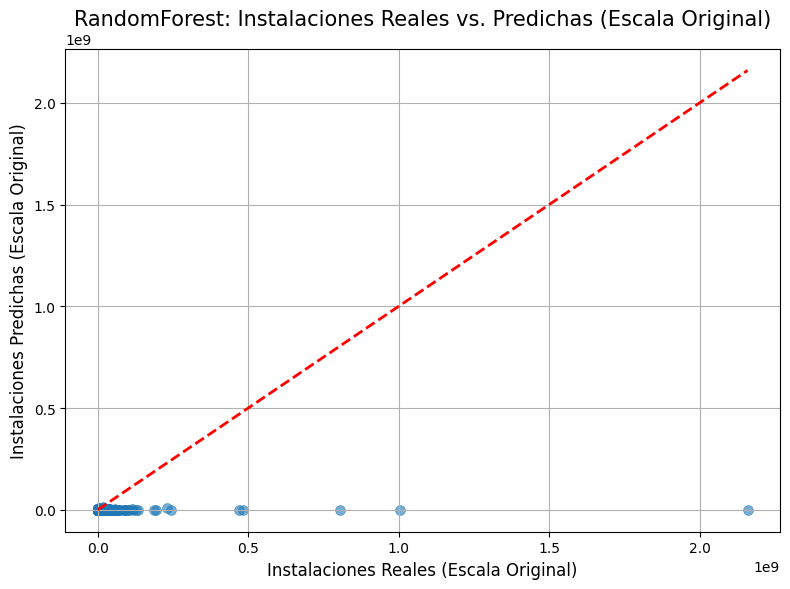


--- Análisis de Residuos (en Escala Logarítmica) ---


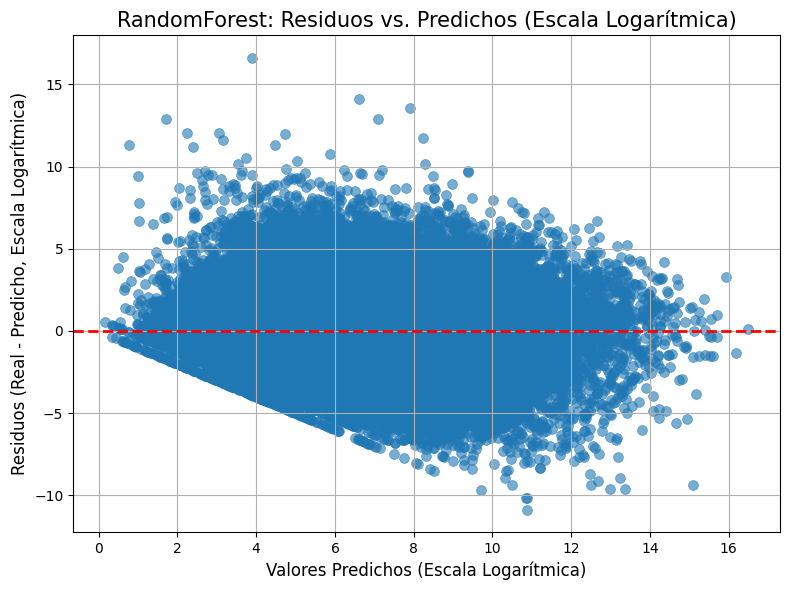

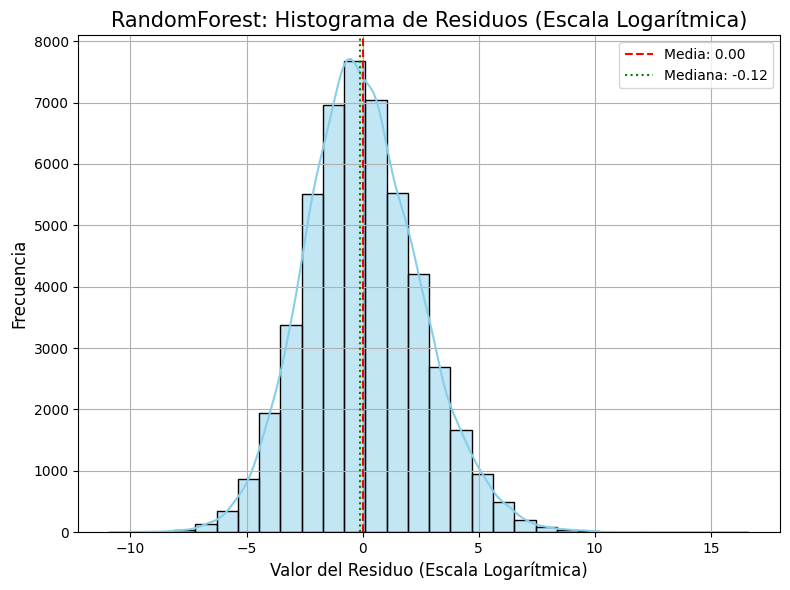


--- Importancia de las Características (RandomForest) ---


<ipython-input-184-5be31067ae5d>:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(n_top_features), palette='mako')


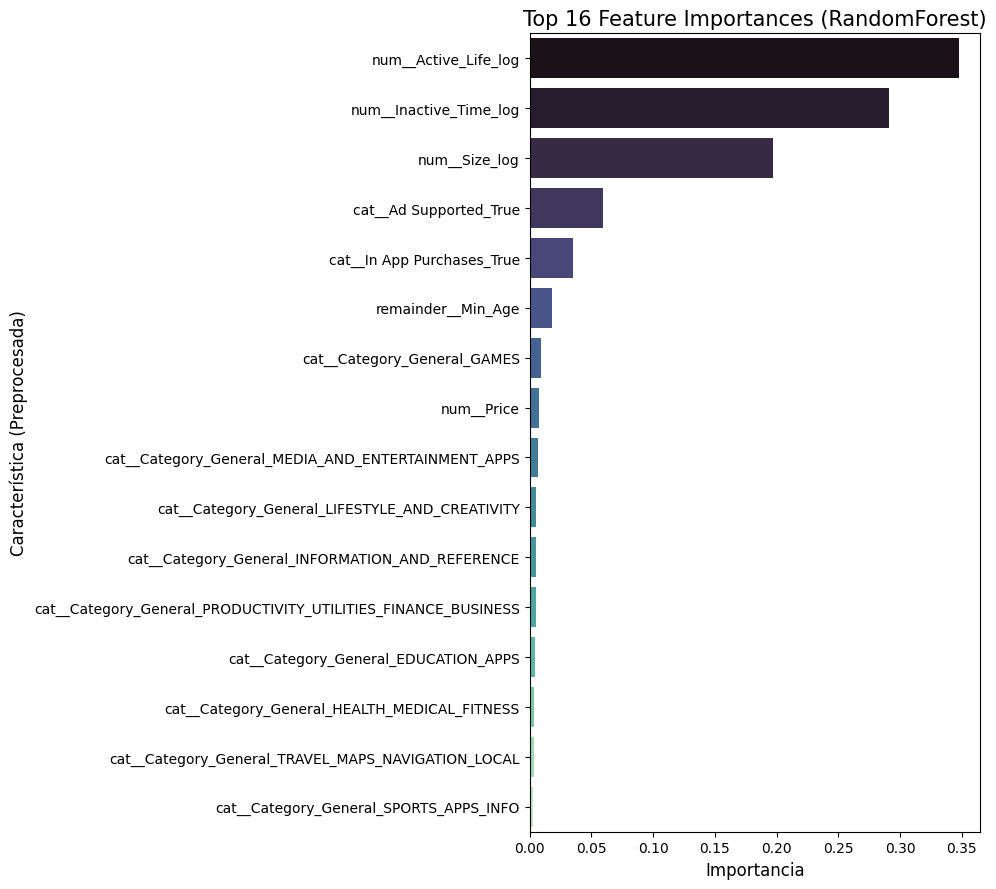

                                               feature  importance
2                                 num__Active_Life_log    0.347447
3                               num__Inactive_Time_log    0.290792
0                                        num__Size_log    0.197339
14                              cat__Ad Supported_True    0.059392
4                           cat__In App Purchases_True    0.035448
15                                  remainder__Min_Age    0.017953
6                          cat__Category_General_GAMES    0.009121
1                                           num__Price    0.007516
10  cat__Category_General_MEDIA_AND_ENTERTAINMENT_APPS    0.006975
9       cat__Category_General_LIFESTYLE_AND_CREATIVITY    0.005013

--- Comparación con Modelo Baseline (en Escala Logarítmica) ---
Modelo Baseline (Prediciendo la Media de y_train_log):
MAE (Baseline, log): 2.5629
RMSE (Baseline, log): 3.1637
R² (Baseline, log) : -0.0000

Resumen Comparativo (Escala Logarítmica):
              

20901

In [184]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler # RobustScaler ya está
from sklearn.impute import SimpleImputer # Asumiendo que podrías necesitarlo en el preprocesador
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc


target = 'max_installs_log' # Target ahora es logarítmico
potential_features = [
    'Size_log',
    'Price',
    'In App Purchases', # Booleano o 0/1
    'Min_Age',
    'Category_General', # Categórica (será OHE)
    'Ad Supported', # Booleano o 0/1
    'Active_Life_log',
    'Inactive_Time_log',
]

# Filtrar características
features = [f for f in potential_features if f in df_sample.columns]
if len(features) != len(potential_features):
    missing_features = [f for f in potential_features if f not in df_sample.columns]
    print(f"Advertencia: Las siguientes características potenciales no se encontraron y serán excluidas: {missing_features}")
print(f"Características finalmente usadas: {features}")

if not features:
    raise ValueError("No features selected or found. Stopping.")
if target not in df_sample.columns:
    raise ValueError(f"Target column '{target}' not found. Stopping.")

X = df_sample[features]
y = df_sample[target] # y está en escala logarítmica

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identificar tipos de columnas para el preprocesador
numeric_features = [col for col in features if X_train[col].dtype in ['int64', 'float64', 'int32', 'float32']]
# Tratar booleanos como categóricos para OHE
categorical_features = [col for col in features if X_train[col].dtype in ['object', 'category', 'bool']]
# Asegurar que no haya solapamiento si alguna booleana también fue capturada como numérica
numeric_features = [col for col in numeric_features if col not in categorical_features]


# Pipelines de preprocesamiento
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # O 'median' que es más robusto a outliers
    ('scaler', RobustScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# Define el pipeline con RandomForestRegressor
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('reg_rf', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
                                     oob_score=True, # Útil para evaluar sin test set si es necesario
                                     max_features='sqrt')) # Común para regresión
])

print("\nAjustando el pipeline RandomForestRegressor con target logarítmico...")
pipe_rf.fit(X_train, y_train) # y_train está en escala logarítmica
print("Pipeline ajustado.")
if hasattr(pipe_rf.named_steps['reg_rf'], 'oob_score_') and pipe_rf.named_steps['reg_rf'].oob_score_:
    print(f"OOB Score: {pipe_rf.named_steps['reg_rf'].oob_score_:.4f} (similar a un R² en datos no vistos por cada árbol)")


y_pred_rf_log = pipe_rf.predict(X_test) # y_pred_rf_log también está en escala logarítmica


# --- INICIO DE LA SECCIÓN DE EVALUACIÓN DEL MODELO COMPLETA ---

# --- Revertir la transformación logarítmica para interpretación ---
# Asumimos que la transformación original fue np.log1p(x) para 'max_installs_log'
# Si fue np.log(x) y no había ceros, usa np.exp().
# Si fue otra, usa la inversa correspondiente.
try:
    y_test_original_scale = np.expm1(y_test)
    y_pred_rf_original_scale = np.expm1(y_pred_rf_log)
    # Corregir posibles valores negativos resultantes de la imprecisión de punto flotante en expm1(0) -> -0.0
    y_pred_rf_original_scale[y_pred_rf_original_scale < 0] = 0
except OverflowError:
    print("OverflowError al revertir la transformación logarítmica. Los valores predichos en escala log son muy grandes.")
    print("Se evaluará principalmente en escala logarítmica.")
    y_test_original_scale = None
    y_pred_rf_original_scale = None


print("\n--- Métricas de Rendimiento del Modelo (RandomForestRegressor) ---")
# Métricas en la ESCALA LOGARÍTMICA
print("Métricas en Escala Logarítmica (Target: max_installs_log):")
mae_rf_log = mean_absolute_error(y_test, y_pred_rf_log)
mse_rf_log = mean_squared_error(y_test, y_pred_rf_log)
rmse_rf_log = np.sqrt(mse_rf_log)
r2_rf_log = r2_score(y_test, y_pred_rf_log)

print(f"MAE (log): {mae_rf_log:,.4f}") # Más decimales para escala log
print(f"MSE (log): {mse_rf_log:,.4f}")
print(f"RMSE (log): {rmse_rf_log:,.4f}")
print(f"R² (log) : {r2_rf_log:.4f}")

# Métricas en la ESCALA ORIGINAL
if y_test_original_scale is not None and y_pred_rf_original_scale is not None:
    print("\nMétricas en Escala Original (Target: Maximum Installs):")
    mae_rf_orig = mean_absolute_error(y_test_original_scale, y_pred_rf_original_scale)
    mse_rf_orig = mean_squared_error(y_test_original_scale, y_pred_rf_original_scale)
    rmse_rf_orig = np.sqrt(mse_rf_orig)
    r2_rf_orig = r2_score(y_test_original_scale, y_pred_rf_original_scale)

    print(f"MAE (original): {mae_rf_orig:,.0f}")
    print(f"MSE (original): {mse_rf_orig:,.0f}")
    print(f"RMSE (original): {rmse_rf_orig:,.0f}")
    print(f"R² (original) : {r2_rf_orig:.4f}")
else:
    print("\nNo se pudieron calcular métricas en la escala original debido a error previo.")

# --- Gráfico de Valores Reales vs. Predichos (EN ESCALA ORIGINAL si es posible) ---
if y_test_original_scale is not None and y_pred_rf_original_scale is not None:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test_original_scale, y=y_pred_rf_original_scale, alpha=0.6, s=50, edgecolor=None)
    min_val = min(y_test_original_scale.min(), y_pred_rf_original_scale.min())
    max_val = max(y_test_original_scale.max(), y_pred_rf_original_scale.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.title("RandomForest: Instalaciones Reales vs. Predichas (Escala Original)", fontsize=15)
    plt.xlabel("Instalaciones Reales (Escala Original)", fontsize=12)
    plt.ylabel("Instalaciones Predichas (Escala Original)", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else: # Graficar en escala logarítmica si no se pudo revertir
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred_rf_log, alpha=0.6, s=50, edgecolor=None)
    min_val_log = min(y_test.min(), y_pred_rf_log.min())
    max_val_log = max(y_test.max(), y_pred_rf_log.max())
    plt.plot([min_val_log, max_val_log], [min_val_log, max_val_log], 'r--', lw=2)
    plt.title("RandomForest: Reales vs. Predichas (Escala Logarítmica)", fontsize=15)
    plt.xlabel("Reales (Escala Logarítmica)", fontsize=12)
    plt.ylabel("Predichas (Escala Logarítmica)", fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Análisis de Residuos (EN ESCALA LOGARÍTMICA) ---
print("\n--- Análisis de Residuos (en Escala Logarítmica) ---")
residuals_rf_log = y_test - y_pred_rf_log # y_test y y_pred_rf_log están en escala log

# 1. Gráfico de Residuos vs. Valores Predichos (escala log)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf_log, y=residuals_rf_log, alpha=0.6, s=50, edgecolor=None)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title("RandomForest: Residuos vs. Predichos (Escala Logarítmica)", fontsize=15)
plt.xlabel("Valores Predichos (Escala Logarítmica)", fontsize=12)
plt.ylabel("Residuos (Real - Predicho, Escala Logarítmica)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Histograma de Residuos (escala log)
plt.figure(figsize=(8, 6))
sns.histplot(residuals_rf_log, kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title("RandomForest: Histograma de Residuos (Escala Logarítmica)", fontsize=15)
plt.xlabel("Valor del Residuo (Escala Logarítmica)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.axvline(x=residuals_rf_log.mean(), color='r', linestyle='--', lw=1.5, label=f'Media: {residuals_rf_log.mean():.2f}')
plt.axvline(x=np.median(residuals_rf_log), color='g', linestyle=':', lw=1.5, label=f'Mediana: {np.median(residuals_rf_log):.2f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Importancia de las Características (RandomForest) ---
print("\n--- Importancia de las Características (RandomForest) ---")
try:
    preprocessor_fitted = pipe_rf.named_steps['prep']
    feature_names_out = preprocessor_fitted.get_feature_names_out()

    rf_model = pipe_rf.named_steps['reg_rf']
    importances = rf_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'feature': feature_names_out,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    n_top_features = 20
    plt.figure(figsize=(10, max(6, n_top_features * 0.45)))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(n_top_features), palette='mako')
    plt.title(f"Top {min(n_top_features, len(feature_importance_df))} Feature Importances (RandomForest)", fontsize=15)
    plt.xlabel("Importancia", fontsize=12)
    plt.ylabel("Característica (Preprocesada)", fontsize=12)
    plt.tight_layout()
    plt.show()
    print(feature_importance_df.head(10))
except Exception as e:
    print(f"No se pudieron obtener o graficar las importancias de las características: {e}")

# --- Comparación con un Modelo Baseline (en Escala Logarítmica) ---
print("\n--- Comparación con Modelo Baseline (en Escala Logarítmica) ---")
baseline_prediction_log = np.full_like(y_test, fill_value=y_train.mean()) # y_train está en escala log

mae_baseline_log = mean_absolute_error(y_test, baseline_prediction_log)
rmse_baseline_log = np.sqrt(mean_squared_error(y_test, baseline_prediction_log))
r2_baseline_log = r2_score(y_test, baseline_prediction_log)

print("Modelo Baseline (Prediciendo la Media de y_train_log):")
print(f"MAE (Baseline, log): {mae_baseline_log:,.4f}")
print(f"RMSE (Baseline, log): {rmse_baseline_log:,.4f}")
print(f"R² (Baseline, log) : {r2_baseline_log:.4f}")

print("\nResumen Comparativo (Escala Logarítmica):")
print(f"                            RandomForest Model   |   Baseline Model")
print(f"---------------------------|----------------------|--------------------")
print(f"R² Coef. Determinación:    {r2_rf_log:>7.4f}            |   {r2_baseline_log:>7.4f}")
print(f"RMSE (log):                {rmse_rf_log:>10,.4f}         |   {rmse_baseline_log:>10,.4f}")
print(f"MAE (log):                 {mae_rf_log:>10,.4f}         |   {mae_baseline_log:>10,.4f}")

if y_test_original_scale is not None and y_pred_rf_original_scale is not None:
    baseline_pred_orig_scale = np.full_like(y_test_original_scale, fill_value=np.expm1(y_train.mean()))
    baseline_pred_orig_scale[baseline_pred_orig_scale < 0] = 0

    rmse_baseline_orig = np.sqrt(mean_squared_error(y_test_original_scale, baseline_pred_orig_scale))
    print(f"\nResumen Comparativo (Escala Original):")
    print(f"RMSE (original, RandomForest): {rmse_rf_orig:>10,.0f}")
    print(f"RMSE (original, Baseline):   {rmse_baseline_orig:>10,.0f}")

print("\n--- Fin de la Evaluación del Modelo ---")
gc.collect()

# Modelo de Regresión Logística


--- Iniciando sección de Regresión Logística para 'No_Ratings' ---
Target de clasificación binaria creado: 'is_No_Ratings' (1: No tiene ratings, 0: Tiene ratings)
Distribución del target binario:
is_No_Ratings
0    0.54245
1    0.45755
Name: proportion, dtype: float64
Características finalmente usadas para clasificación: ['Size_log', 'Price', 'In App Purchases', 'Min_Age', 'Category_General', 'Ad Supported', 'Active_Life_log', 'Inactive_Time_log', 'Cluster_Label']

Dimensiones de X_train_cls: (199093, 9), y_train_cls: (199093,)
Dimensiones de X_test_cls: (49774, 9), y_test_cls: (49774,)
Variables numéricas para clasificación: ['Size_log', 'Price', 'Active_Life_log', 'Inactive_Time_log']
Variables categóricas para clasificación: ['In App Purchases', 'Category_General', 'Ad Supported', 'Cluster_Label']

Ajustando el pipeline de Regresión Logística para 'No_Ratings'...
Pipeline de Regresión Logística ajustado.

--- Métricas de Evaluación de Regresión Logística ('No_Ratings') ---

Reporte

<Figure size 600x600 with 0 Axes>

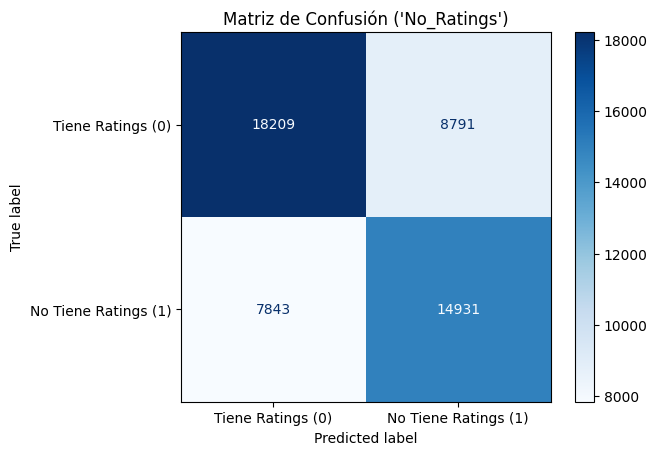


Exactitud (Accuracy): 0.6658
Precisión (Clase 1: 'No Tiene Ratings'): 0.6294
Sensibilidad (Recall Clase 1: 'No Tiene Ratings'): 0.6556
Especificidad (Clase 0: 'Tiene Ratings'): 0.6744
F1-Score (Clase 1: 'No Tiene Ratings'): 0.6422


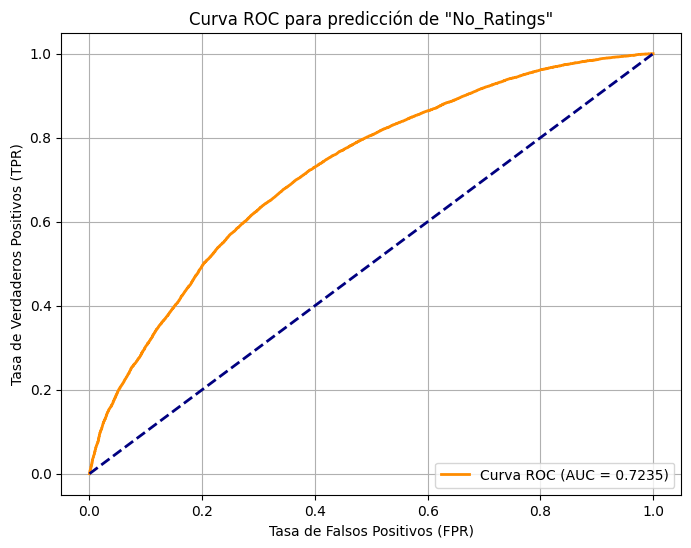


Área Bajo la Curva ROC (AUC): 0.7235


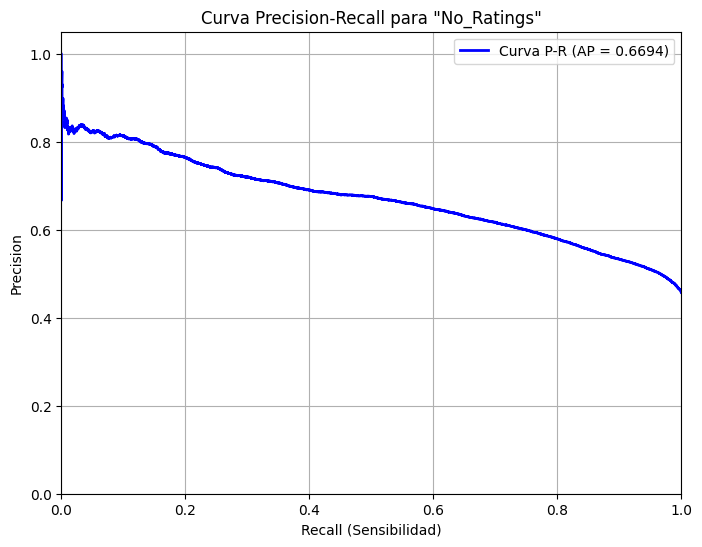


Average Precision (AP): 0.6694

--- Evaluación con Validación Cruzada (Cross-Validation) ---
Scores de Validación Cruzada (AUC-ROC): [0.68167901 0.71962447 0.72251387 0.72862686 0.73837544]
Media de los Scores de CV (AUC-ROC): 0.7182 (+/- 0.0387)

--- Análisis de Coeficientes del Modelo (Regresión Logística para 'No_Ratings') ---

Coeficientes del Modelo (ordenados por magnitud):
                                                          feature  coefficient
2                                            num__Active_Life_log    -1.510994
4                                      cat__In App Purchases_True    -0.852497
7                    cat__Category_General_HEALTH_MEDICAL_FITNESS     0.674660
16                                           cat__Cluster_Label_2     0.574454
14                                         cat__Ad Supported_True    -0.570469
9                  cat__Category_General_LIFESTYLE_AND_CREATIVITY     0.415685
13             cat__Category_General_TRAVEL_MAPS_NAVIGATION_LOC

<ipython-input-199-63c99b11bfe7>:215: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=top_coefficients_to_plot, palette='coolwarm')


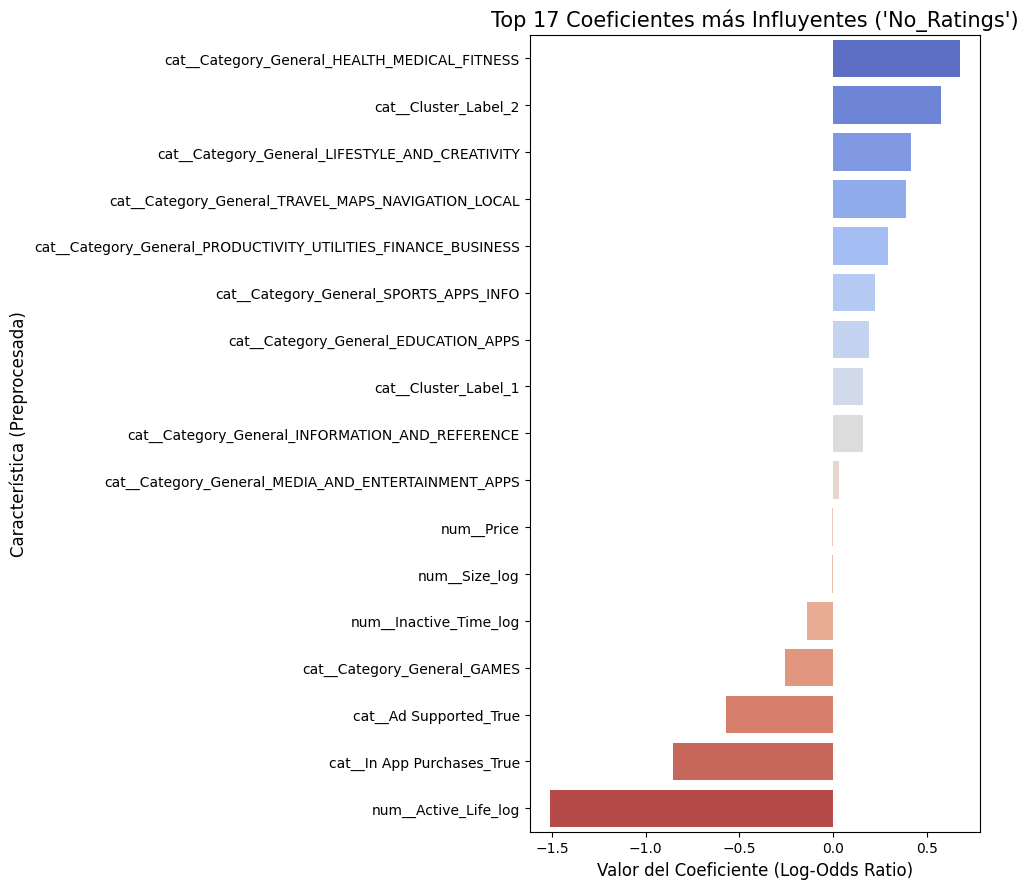


Interpretación de los Coeficientes:
- Un coeficiente positivo indica que al aumentar el valor de la característica, aumenta el log-odds de la clase positiva (que la app NO tenga ratings).
- Un coeficiente negativo indica que al aumentar el valor de la característica, disminuye el log-odds de la clase positiva (es decir, aumenta la probabilidad de que SÍ tenga ratings).

--- Fin de la sección de Regresión Logística para 'No_Ratings' ---


26668

In [199]:
# --- Regresión Logística y sus Métricas de Análisis de Modelo ---

# Importar las bibliotecas necesarias
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             ConfusionMatrixDisplay, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Limpiar plots anteriores y liberar memoria si es necesario
plt.close('all')
gc.collect()

print("\n--- Iniciando sección de Regresión Logística para 'No_Ratings' ---")

# 1. Definir el Target para Clasificación Binaria
# ASUNCIÓN: df_sample tiene una columna 'No_Ratings' que es booleana (True/False) o 0/1.
# True o 1 significaría que la app NO tiene ratings.
# False o 0 significaría que la app SÍ tiene ratings.

if 'No_Ratings' in df_sample.columns:
    df_sample['is_No_Ratings'] = df_sample['No_Ratings'].astype(int) # Convertir a 0/1
    target_classification = 'is_No_Ratings'
    print(f"Target de clasificación binaria creado: '{target_classification}' (1: No tiene ratings, 0: Tiene ratings)")
    print("Distribución del target binario:")
    print(df_sample[target_classification].value_counts(normalize=True)) # normalize=True para ver proporciones
else:
    # MODIFICACIÓN: Mensaje de error actualizado
    raise ValueError("La columna 'No_Ratings' no se encontró en el DataFrame. No se puede crear un target de clasificación binaria.")

# 2. Seleccionar Características (Features) para la Clasificación
potential_features_classification = [
    'Size_log',
    'Price',
    'In App Purchases',
    'Min_Age',
    'Category_General',
    'Ad Supported',
    'Active_Life_log',
    'Inactive_Time_log',
    'Cluster_Label' # Si la calculaste y quieres incluirla
]

features_classification = [f for f in potential_features_classification if f in df_sample.columns]
if len(features_classification) != len(potential_features_classification):
    missing_features_classification = [f for f in potential_features_classification if f not in df_sample.columns]
    print(f"Advertencia: Las siguientes características potenciales de clasificación no se encontraron: {missing_features_classification}")
print(f"Características finalmente usadas para clasificación: {features_classification}")

if not features_classification:
    raise ValueError("No features selected or found for classification. Stopping.")

X_cls = df_sample[features_classification]
y_cls = df_sample[target_classification]

# 3. Dividir los datos
# Usamos stratify=y_cls para mantener proporciones en train/test, útil si hay desbalance
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

print(f"\nDimensiones de X_train_cls: {X_train_cls.shape}, y_train_cls: {y_train_cls.shape}")
print(f"Dimensiones de X_test_cls: {X_test_cls.shape}, y_test_cls: {y_test_cls.shape}")

# 4. Identificar tipos de columnas para el preprocesador
numeric_features_cls = [col for col in features_classification if X_train_cls[col].dtype in ['int64', 'float64', 'int32', 'float32']]
# Tratar booleanas y Cluster_Label (si es int) como categóricas para OHE
categorical_features_cls = [
    col for col in features_classification if
    X_train_cls[col].dtype in ['object', 'category', 'bool'] or col == 'Cluster_Label'
]
# Asegurar que no haya solapamiento si alguna booleana o Cluster_Label fue capturada como numérica
numeric_features_cls = [col for col in numeric_features_cls if col not in categorical_features_cls]

print(f"Variables numéricas para clasificación: {numeric_features_cls}")
print(f"Variables categóricas para clasificación: {categorical_features_cls}")

# 5. Definir el Pipeline de Preprocesamiento y Modelo
numeric_pipeline_cls = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', RobustScaler())
])

categorical_pipeline_cls = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # MODIFICACIÓN: sparse_output=True es más eficiente en memoria
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=True))
])

preprocessor_cls = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline_cls, numeric_features_cls),
        ('cat', categorical_pipeline_cls, categorical_features_cls)
    ],
    remainder='drop'
)

log_reg_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # Añadido class_weight='balanced'

pipe_log_reg = Pipeline([
    ('prep', preprocessor_cls),
    ('classifier', log_reg_model)
])

# 6. Entrenar el Modelo
print("\nAjustando el pipeline de Regresión Logística para 'No_Ratings'...")
pipe_log_reg.fit(X_train_cls, y_train_cls)
print("Pipeline de Regresión Logística ajustado.")

# 7. Realizar Predicciones
y_pred_cls = pipe_log_reg.predict(X_test_cls)
y_pred_proba_cls = pipe_log_reg.predict_proba(X_test_cls)[:, 1] # Probabilidades para la clase positiva (1: No Ratings)

# 8. Evaluar el Modelo
print("\n--- Métricas de Evaluación de Regresión Logística ('No_Ratings') ---")
print("\nReporte de Clasificación:")
# MODIFICACIÓN: target_names para el reporte
print(classification_report(y_test_cls, y_pred_cls, target_names=['Tiene Ratings (0)', 'No Tiene Ratings (1)'], zero_division=0))

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test_cls, y_pred_cls)
# MODIFICACIÓN: display_labels para la matriz
disp_labels = ['Tiene Ratings (0)', 'No Tiene Ratings (1)']
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión ('No_Ratings')")
plt.show()

tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
precision_class1 = tp / (tp + fp) if (tp + fp) > 0 else 0 # Precisión para clase 1 (No Ratings)
recall_class1 = tp / (tp + fn) if (tp + fn) > 0 else 0    # Recall para clase 1 (No Ratings)
specificity_class0 = tn / (tn + fp) if (tn + fp) > 0 else 0 # Especificidad para clase 0 (Tiene Ratings)
f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1) if (precision_class1 + recall_class1) > 0 else 0

print(f"\nExactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Clase 1: 'No Tiene Ratings'): {precision_class1:.4f}")
print(f"Sensibilidad (Recall Clase 1: 'No Tiene Ratings'): {recall_class1:.4f}")
print(f"Especificidad (Clase 0: 'Tiene Ratings'): {specificity_class0:.4f}")
print(f"F1-Score (Clase 1: 'No Tiene Ratings'): {f1_class1:.4f}")

# Curva ROC y AUC
fpr, tpr, thresholds_roc = roc_curve(y_test_cls, y_pred_proba_cls)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC para predicción de "No_Ratings"')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"\nÁrea Bajo la Curva ROC (AUC): {roc_auc:.4f}")

# Curva Precision-Recall y AP
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test_cls, y_pred_proba_cls)
avg_precision = average_precision_score(y_test_cls, y_pred_proba_cls)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2, label=f'Curva P-R (AP = {avg_precision:.4f})')
plt.title('Curva Precision-Recall para "No_Ratings"')
plt.xlabel('Recall (Sensibilidad)')
plt.ylabel('Precision')
plt.legend(loc="best") # Ajustado a 'best'
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()
print(f"\nAverage Precision (AP): {avg_precision:.4f}")


# Validación Cruzada
print("\n--- Evaluación con Validación Cruzada (Cross-Validation) ---")
try:
    cv_scores_roc_auc = cross_val_score(pipe_log_reg, X_cls, y_cls, cv=5, scoring='roc_auc', n_jobs=-1)
    # También podrías usar 'f1', 'precision', 'recall' dependiendo de tu métrica principal si hay desbalance
    # cv_scores_f1 = cross_val_score(pipe_log_reg, X_cls, y_cls, cv=5, scoring='f1', n_jobs=-1) # Si la clase positiva es la minoritaria
    print(f"Scores de Validación Cruzada (AUC-ROC): {cv_scores_roc_auc}")
    print(f"Media de los Scores de CV (AUC-ROC): {cv_scores_roc_auc.mean():.4f} (+/- {cv_scores_roc_auc.std() * 2:.4f})")
except Exception as e:
    print(f"Error durante la Validación Cruzada: {e}")

# 9. Análisis de Coeficientes del Modelo
print("\n--- Análisis de Coeficientes del Modelo (Regresión Logística para 'No_Ratings') ---")
try:
    logistic_model_fitted = pipe_log_reg.named_steps['classifier']
    coefficients = logistic_model_fitted.coef_[0]
    intercept = logistic_model_fitted.intercept_[0]
    preprocessor_fitted = pipe_log_reg.named_steps['prep']
    feature_names_out = preprocessor_fitted.get_feature_names_out()

    coefficients_df = pd.DataFrame({
        'feature': feature_names_out,
        'coefficient': coefficients
    }).sort_values(by='coefficient', key=abs, ascending=False) # Ordenar por valor absoluto para ver más influyentes

    print("\nCoeficientes del Modelo (ordenados por magnitud):")
    print(coefficients_df.head(20)) # Mostrar los 20 más influyentes
    print(f"\nIntercept del Modelo: {intercept:.4f}")

    # Visualizar los coeficientes más influyentes
    n_top_coefficients = 20
    top_coefficients_to_plot = coefficients_df.head(n_top_coefficients).sort_values(by='coefficient', ascending=False)

    plt.figure(figsize=(10, max(6, n_top_coefficients * 0.45)))
    sns.barplot(x='coefficient', y='feature', data=top_coefficients_to_plot, palette='coolwarm')
    plt.title(f"Top {min(n_top_coefficients, len(coefficients_df))} Coeficientes más Influyentes ('No_Ratings')", fontsize=15)
    plt.xlabel("Valor del Coeficiente (Log-Odds Ratio)", fontsize=12)
    plt.ylabel("Característica (Preprocesada)", fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nInterpretación de los Coeficientes:")
    print("- Un coeficiente positivo indica que al aumentar el valor de la característica, aumenta el log-odds de la clase positiva (que la app NO tenga ratings).")
    print("- Un coeficiente negativo indica que al aumentar el valor de la característica, disminuye el log-odds de la clase positiva (es decir, aumenta la probabilidad de que SÍ tenga ratings).")
except Exception as e:
    print(f"No se pudieron obtener o analizar los coeficientes del modelo: {e}")

print("\n--- Fin de la sección de Regresión Logística para 'No_Ratings' ---")
gc.collect()

 El modelo de Regresión Logística actual provee una capacidad predictiva moderada. Aunque logra distinguir entre las clases mejor que el azar, su precisión, especialmente al identificar aplicaciones sin ratings, indica áreas donde se podría buscar una mejora para aumentar la confiabilidad de sus predicciones.